## Fastmarch ORCA Policy

In [4]:
import numpy as np
from crowd_sim.envs.policy.orca import ORCA
from crowd_sim.envs.utils.state import JointState
import CMap2D
import matplotlib.pyplot as plt
from map2d import gridshow

class Suicide(object):
    def __init__(self):
        pass

class FastmarchORCAPolicy(object):
    def __init__(self, suicide_if_stuck=False):
        self.simulator = ORCA()
        self.suicide_if_stuck = suicide_if_stuck
        self.map = CMap2D.CMap2D()
        self.grid_num = 100
        self.new = True

    def reset(self):
        self.new = True
        self.simulator.reset()        
    
    def predict(self, obs, env):
        self.simulator.time_step = env._get_dt()
        other_agent_states = [
            agent.get_observable_state() for agent in env.soadrl_sim.humans + env.soadrl_sim.other_robots]
        joint_state = JointState(env.soadrl_sim.robot.get_full_state(), other_agent_states)
        
        if self.new:
            #find an appropriate origin
            bbox = env.soadrl_sim.obstacle_vertices[-1]
            bbox_ll = np.array(bbox[-1])
            bbox_tr = np.array(bbox[1])
            self.map.origin[0] = bbox_ll[0] - 0.25
            self.map.origin[1] = bbox_ll[1] - 0.25
            
            #find the right resolution
            max_dim = max(bbox_tr-bbox_ll)
            #offset = 2*max_dim/self.grid_num
            self.map.set_resolution((max_dim+2*0.25)/self.grid_num)
            
            #initialise occupancy
            self.map._occupancy = np.ones((self.grid_num,self.grid_num), dtype = np.float32)
            bbox_ij = self.map.xy_to_ij(bbox)
            self.map._occupancy[bbox_ij[-1,0]:bbox_ij[1,0], bbox_ij[-1,1]:bbox_ij[1,1]] = 0
            
            radius = env.soadrl_sim.robot.radius*1.05
            for vertex in env.soadrl_sim.obstacle_vertices[:-1]:
                xy_min, xy_max = np.min(vertex, 0), np.max(vertex,0)
                xy_min -= radius
                xy_max += radius
                min_max_ij = self.map.xy_to_ij([xy_min,xy_max])
                self.map._occupancy[min_max_ij[0,0]:min_max_ij[1,0], min_max_ij[0,1]:min_max_ij[1,1]] = 1
            #self.map.HUGE_ = 100 * np.prod( self.map._occupancy.shape )
            #calculate the field
            goal = self.map.xy_to_ij([(env.soadrl_sim.robot.gx,env.soadrl_sim.robot.gy)])
            self.field = self.map.fastmarch(goal[0])
            
            plt.figure("occupancy", figsize=[8,8]) 
            grid = self.map.occupancy()
            gridshow(self.field)
            
            self.new = False
        
            # only for vizualisation atm
            robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
            robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
            gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8)
            plt.plot(gridfmpath8[:,0],  gridfmpath8[:,1] , '-o', color=plt.cm.winter(0.33) , mec=plt.cm.winter(0.33), mfc=[0,0,0,0])
            plt.show()
        robot_pos_xy = (joint_state.self_state.px, joint_state.self_state.py)
        robot_pos_ij = self.map.xy_to_ij([robot_pos_xy])
        gridfmpath8, jumps = CMap2D.path_from_dijkstra_field(self.field, robot_pos_ij[0], connectedness= 8) 
        
        if gridfmpath8.shape[0] > 15:
            virtual_goal = gridfmpath8[15]  # look forward in path
            virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
            virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
            print("vx: ", joint_state.self_state.vx,"vy: ", joint_state.self_state.vy, "v: ",
                  np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2))
            joint_state.self_state.gx = virtual_goal[0]
            joint_state.self_state.gy = virtual_goal[1]
            
            if np.sqrt(joint_state.self_state.vx**2+joint_state.self_state.vy**2) < 0.25:
                virtual_goal = gridfmpath8[8]  # look forward in path
                virtual_goal[0] = (virtual_goal[0]*self.map.resolution())+self.map.origin[0]
                virtual_goal[1] = (virtual_goal[1]*self.map.resolution())+self.map.origin[1]
                idx = np.argmin([virtual_goal[0] - robot_pos_xy[0],virtual_goal[0] - robot_pos_xy[0]])
                print("idx: ", idx)
                if idx == 0:
                    joint_state.self_state.gx = robot_pos_xy[0] + np.sign(virtual_goal[0] - robot_pos_xy[0])#*(virtual_goal[1] - robot_pos_xy[1]) #virtual_goal[0]
                elif idx == 1:
                    joint_state.self_state.gy = robot_pos_xy[1] + np.sign(virtual_goal[1] - robot_pos_xy[1])#*(virtual_goal[0] - robot_pos_xy[0]) #virtual_goal[1]
            
        action = self.simulator.predict(
            joint_state,
            env.soadrl_sim.obstacle_vertices,
            env.soadrl_sim.robot,
        )
        if self.suicide_if_stuck:
            if action.v < 0.02:
                return Suicide()
        vx = action.v * np.cos(action.r)
        vy = action.v * np.sin(action.r)
        return np.array([vx, vy]) #, 0.1*(np.random.random()-0.5)

## Play Policy

In [5]:
import os

def play_policy(env, n_sequences, episode_length=1000,
                         subset_index=0, n_subsets=1,
                         render=True,
                         policy=FastmarchORCAPolicy(),
                         archive_dir=os.path.expanduser("~/navrep/datasets/V/ian")
                         ):
    """
    if n_subsets is None, the whole set of sequences is generated (n_sequences)
    if n_subsets is a number > 1, this function only generates a portion of the sequences
    """
    indices = np.arange(n_sequences)
    if n_subsets > 1:  # when multiprocessing
        indices = np.array_split(indices, n_subsets)[subset_index]
    scans = []
    robotstates = []
    actions = []
    rewards = []
    dones = []
    for n in indices:
        policy.reset()
        obs = env.reset()
        for i in range(episode_length):
            # step
            action = policy.predict(obs, env)
            if isinstance(action, Suicide):
                obs = env.reset()
                rew = 0
                action = np.array([0, 0, 0])
                done = True
            else:
                obs, rew, done, _ = env.step(action)
            scans.append(obs[0])
            robotstates.append(obs[1])
            actions.append(action)
            rewards.append(rew)
            dones.append(done)
            if render:
                env.render(save_to_file=False)
            if done:
                policy.reset()
                obs = env.reset()
        dones[-1] = True

    scans = np.array(scans)
    robotstates = np.array(robotstates)
    actions = np.array(actions)
    rewards = np.array(rewards)
    dones = np.array(dones)
    data = dict(scans=scans, robotstates=robotstates, actions=actions, rewards=rewards, dones=dones)
        #if archive_dir is not None:
         #   make_dir_if_not_exists(archive_dir)
          #  archive_path = os.path.join(
           #     archive_dir, "{:03}_scans_robotstates_actions_rewards_dones.npz".format(n)
            #)
            #np.savez_compressed(archive_path, **data)
            #print(archive_path, "written.")
    env.close()
    return data

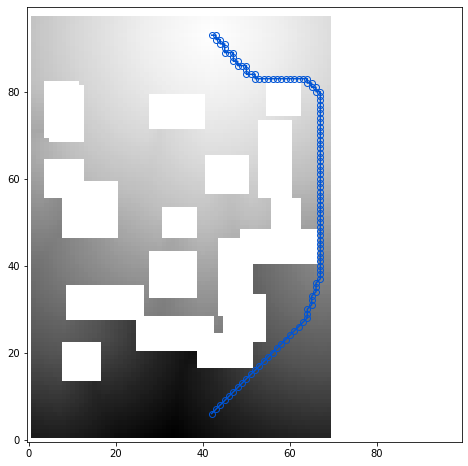

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.12679137289524084 vy:  0.3905969858169555 v:  0.4106605137701346
vx:  0.6043119430541992 vy:  0.4377758502960205 v:  0.746217541753305
vx:  0.6411378383636477 vy:  0.7458273768424987 v:  0.9835223453635273
vx:  0.6067259311676025 vy:  0.7947654724121094 v:  0.9998842491456887
vx:  0.6067194342613218 vy:  0.794757127761841 v:  0.9998736740401908
vx:  0.6067118644714353 vy:  0.7947471141815187 v:  0.9998611213514891
vx:  0.6067031621932985 vy:  0.7947359085083009 v:  0.9998469339293201
vx:  0.6066932678222657 vy:  0.7947224378585815 v:  0.9998302228162271
vx:  0.5996788740158083 vy:  0.785534381866455 v:  0.9882707205190191
vx:  0.5990031361579895 vy:  0.7846491932868959 v:  0.9871570866143258
vx:  0.6270830035209655 vy:  0.7789524197578432 v:  0.9999999827757371
vx:  0.6270830035209655 vy:  0.7789524197578432 v:  0.9999999827757371
vx:  0.6270830035209655 vy:  0.7789524197578432 v:  0.9999999827757371
vx:  0.6270830035209655 vy:  0.7789524197578

vx:  -0.059704661369323744 vy:  0.20840267837047577 v:  0.21678635321720227
idx:  0
vx:  -0.057316467165947 vy:  0.20006661117076874 v:  0.2081149353452093
idx:  0
vx:  -0.055023759603500436 vy:  0.19206394255161283 v:  0.1997903204596585
idx:  0
vx:  -0.05282285809516906 vy:  0.18438135087490082 v:  0.1917986884412812
idx:  0
vx:  -0.05070994794368744 vy:  0.17700609564781192 v:  0.1841267409067293
idx:  0
vx:  -0.04868160188198092 vy:  0.16992583870887756 v:  0.1767616729461202
idx:  0
vx:  -0.046734243631362915 vy:  0.1631288081407547 v:  0.1696911829566249
idx:  0
vx:  -0.0448649376630783 vy:  0.15660366415977478 v:  0.16290356122497576
idx:  0
vx:  -0.04307028651237491 vy:  0.15033955872058866 v:  0.15638744353866582
idx:  0
vx:  -0.0413475334644318 vy:  0.14432597160339355 v:  0.15013195730042245
idx:  0
vx:  -0.03969365358352663 vy:  0.1385529041290283 v:  0.14412665741422273
idx:  0
vx:  -0.038105830550193794 vy:  0.13301081955432895 v:  0.13836160031032577
idx:  0
vx:  -0.0365

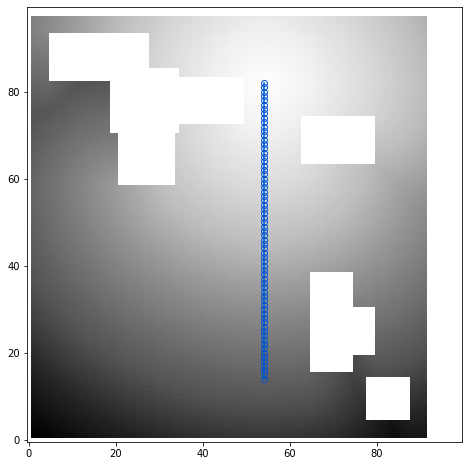

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.04657186567783349 vy:  0.3650759160518647 v:  0.3680344591934596
vx:  -0.11536224186420438 vy:  0.5822330713272095 v:  0.5935518479417368
vx:  0.011858731508254963 vy:  0.5065023899078369 v:  0.5066411950239886
vx:  0.004993121605366566 vy:  0.47825565934181213 v:  0.4782817234181518
vx:  0.012919463217258453 vy:  0.5511564612388611 v:  0.5513078607231773
vx:  0.04445397853851299 vy:  0.6281375885009767 v:  0.6297086519142999
vx:  0.0686893016099931 vy:  0.6815602779388428 v:  0.6850128704044481
vx:  0.07605576515197775 vy:  0.7124569416046143 v:  0.716504970710918
vx:  0.08124895393848418 vy:  0.7310264706611634 v:  0.735527765161462
vx:  0.08522738516330716 vy:  0.742971658706665 v:  0.7478439628847102
vx:  0.08856943994760495 vy:  0.7514187097549438 v:  0.7566205277828622
vx:  0.09164255112409568 vy:  0.758122980594635 v:  0.7636418079716601
vx:  0.09470761567354213 vy:  0.7641258835792542 v:  0.7699726608278655
vx:  0.0979982241988184 vy: 

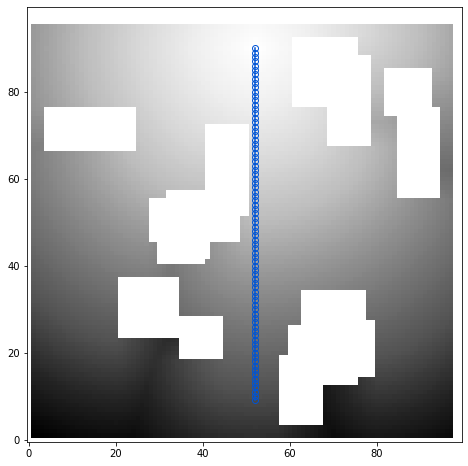

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.19792297482490545 vy:  0.49299412965774536 v:  0.5312407324749656
vx:  0.007225781679153387 vy:  0.8254342675209044 v:  0.8254658938554922
vx:  -0.011396866291761232 vy:  0.8515191078186035 v:  0.8515953731329585
vx:  -0.011396866291761232 vy:  0.8515191078186035 v:  0.8515953731329585
vx:  -0.011396866291761232 vy:  0.8515191078186035 v:  0.8515953731329585
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.008191022090613675 vy:  0.8515559434890747 v:  0.8515953368440067
vx:  -0.005872568581253346 vy:  0.8515750765800476 v:  0.8515953253242149
vx:  -0.005872568581253346 vy:  0.8515750765800476 v:  0.8515953253242149
vx:  -

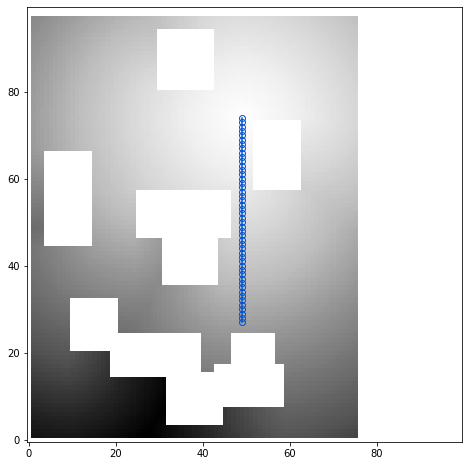

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.05777229368686675 vy:  -0.02265865541994572 v:  0.062056849608092574
idx:  0
vx:  -0.025974990800023086 vy:  0.07161587476730347 v:  0.07618092717831267
idx:  0
vx:  -0.0012397072277962745 vy:  0.14137159287929535 v:  0.1413770283576504
idx:  0
vx:  0.16508938372135157 vy:  0.17345561087131503 v:  0.23946054698057617
idx:  0
vx:  0.20075237751007077 vy:  0.21391485631465906 v:  0.2933616928436077
vx:  0.21395026147365567 vy:  0.24128210544586182 v:  0.3224775477347743
vx:  0.22369939088821414 vy:  0.25812646746635437 v:  0.3415709160488008
vx:  0.22878697514533997 vy:  0.268747478723526 v:  0.35294289526268474
vx:  0.22971032559871674 vy:  0.27576717734336853 v:  0.3589071882626445
vx:  0.22690877318382263 vy:  0.2809652090072632 v:  0.36114960891614234
vx:  0.21821279823780065 vy:  0.2867177724838257 v:  0.3603108468709455
vx:  0.2467595040798187 vy:  0.42312389612197876 v:  0.4898204613153284
vx:  0.3011624217033388 vy:  0.7506484985351562 v:

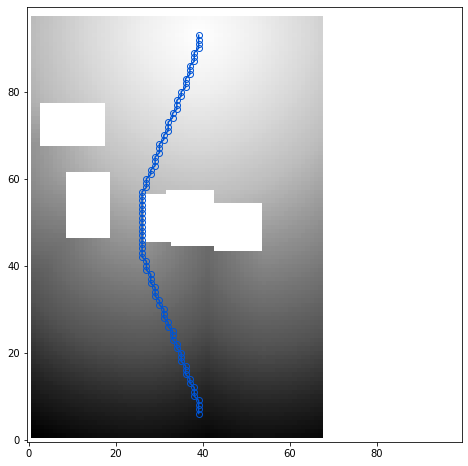

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.050226964056491824 vy:  0.3398667275905609 v:  0.3435580597824022
vx:  -0.30689963698387146 vy:  0.6754506826400757 v:  0.7419036405489438
vx:  -0.19374771416187292 vy:  0.7922333478927611 v:  0.8155806853134295
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.19374772906303395 vy:  0.7922333478927611 v:  0.8155806888533197
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.14524064958095556 vy:  0.8025440573692322 v:  0.8155806583713026
vx:  -0.1452406

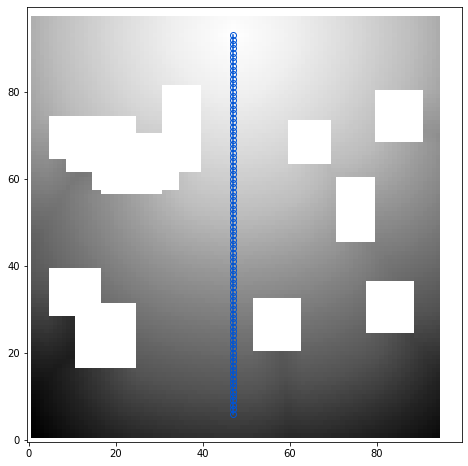

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.09334639459848412 vy:  0.4954030215740203 v:  0.5041207228127059
vx:  -0.026392154395580125 vy:  0.7842711210250853 v:  0.7847150674528839
vx:  0.1022001653909679 vy:  0.8983246088027954 v:  0.9041194481851591
vx:  0.10508099198341367 vy:  1.0337342023849487 v:  1.0390613148686965
vx:  0.14371936023235327 vy:  1.0467000007629395 v:  1.0565207740989926
vx:  0.15168486535549194 vy:  1.0518754720687862 v:  1.0627559960394697
vx:  0.14402538537979118 vy:  1.0531686544418335 v:  1.0629710844292142
vx:  0.12970510125160273 vy:  1.0488871335983276 v:  1.056876356211456
vx:  0.11105231940746299 vy:  1.0462684631347654 v:  1.052145576712729
vx:  0.09100548177957499 vy:  1.0431833267211914 v:  1.0471453819136216
vx:  0.0706860348582265 vy:  1.0399202108383176 v:  1.042319797583251
vx:  0.050667341798543875 vy:  1.0366361141204834 v:  1.0378736014678023
vx:  0.03288763761520397 vy:  1.0279163122177124 v:  1.0284422889161893
vx:  0.014420161955058075 vy:  1

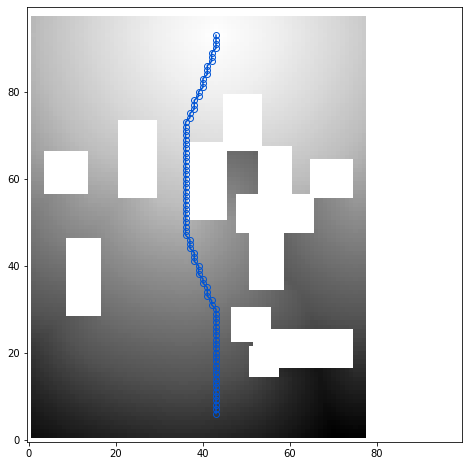

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.038853213191032354 vy:  0.70655357837677 v:  0.7076210364964332
vx:  -0.03422081470489508 vy:  0.9050435423851013 v:  0.9056902769556707
vx:  -0.0002519195550122026 vy:  0.9999999403953551 v:  0.9999999721270876
vx:  -0.0002519195550122026 vy:  0.9999999403953551 v:  0.9999999721270876
vx:  -0.0002519195550122026 vy:  0.9999999403953551 v:  0.9999999721270876
vx:  -0.0002519195550122026 vy:  0.9999999403953551 v:  0.9999999721270876
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.00018695300968828935 vy:  0.9999999999999998 v:  1.0000000174757135
vx:  -0.000138740419060885 vy:  0.9999999999999999 v:  1.0000000096244517
vx:  -0.000138740419060885 vy:  0.9999999999999999 v:  1.00000000962

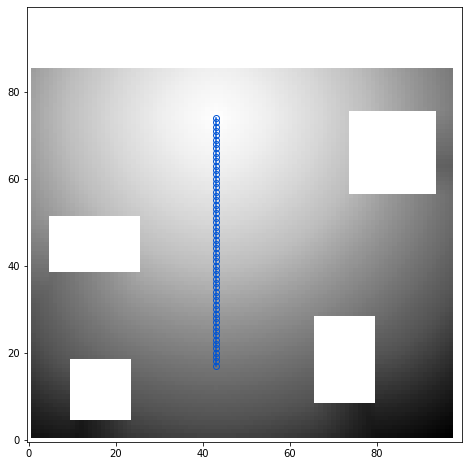

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.06613256782293322 vy:  0.36161503195762634 v:  0.36761249688302217
vx:  -0.021179385483264895 vy:  0.42165473103523254 v:  0.4221863078948002
vx:  0.020654749125242254 vy:  0.45712035894393926 v:  0.4575867581371456
vx:  0.09030544012784959 vy:  0.5177316665649414 v:  0.5255484288634077
vx:  0.0790164843201638 vy:  0.5058044791221619 v:  0.5119392306654768
vx:  0.07867041230201724 vy:  0.49270406365394587 v:  0.4989452155426294
vx:  0.04324236884713173 vy:  0.4828415215015412 v:  0.4847740064704735
vx:  -0.031170740723609924 vy:  0.4705875515937805 v:  0.47161876424956584
vx:  -0.13716143369674688 vy:  0.4826841950416565 v:  0.5017940723411936
vx:  -0.21747142076492312 vy:  0.5399322509765625 v:  0.5820830305842388
vx:  -0.23575313389301303 vy:  0.5763703584671022 v:  0.6227217117299451
vx:  -0.24594458937644964 vy:  0.5917198657989502 v:  0.6407972695203047
vx:  -0.18684248626232147 vy:  0.6240262389183043 v:  0.6513976216806525
vx:  -0.18636

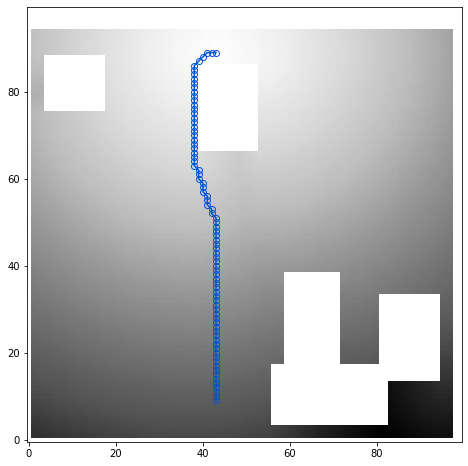

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1165772676467896 vy:  0.29864227771759033 v:  0.3205892533637732
vx:  -0.20910945534706116 vy:  0.7205705642700195 v:  0.750299075307946
vx:  -0.1769313514232636 vy:  0.8306470513343811 v:  0.8492815946474788
vx:  -0.1818825900554657 vy:  0.8990017771720886 v:  0.9172161533269343
vx:  -0.15311293303966522 vy:  0.9885991215705873 v:  1.000385822287654
vx:  -0.12750999629497534 vy:  1.0282864570617676 v:  1.036162070784193
vx:  -0.11796376109123236 vy:  1.0389254093170166 v:  1.045601001843112
vx:  -0.11495281010866187 vy:  1.0392627716064453 v:  1.0456009071337824
vx:  -0.11337029933929432 vy:  1.0394366979599 v:  1.045601010824904
vx:  -0.1125360131263734 vy:  1.039527416229248 v:  1.0456010727531966
vx:  -0.11209472268819792 vy:  1.0395749807357786 v:  1.0456009599394687
vx:  -0.11186049133539211 vy:  1.0396003723144531 v:  1.0456011207138909
vx:  -0.1117356866598131 vy:  1.0396137237548828 v:  1.0456010512106584
vx:  -0.11166893690824503 vy: 

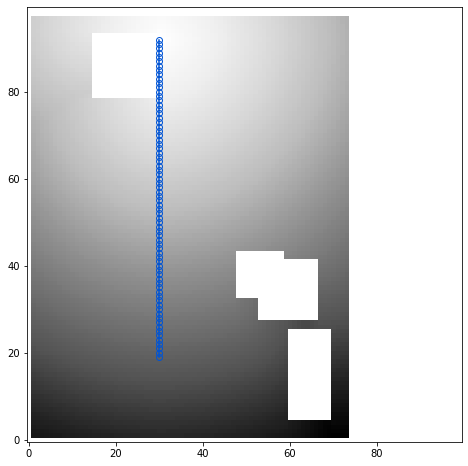

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.18487870693206793 vy:  0.5205380320549012 v:  0.5523947674376205
vx:  0.22011098265647883 vy:  0.6097679138183594 v:  0.6482790706234429
vx:  0.04382152855396268 vy:  0.6226049661636354 v:  0.6241452317020673
vx:  -0.15126919746398937 vy:  0.867290198802948 v:  0.8803832455476742
vx:  -0.1217937245965004 vy:  0.9333917498588562 v:  0.9413043450742515
vx:  -0.09284407645463938 vy:  0.9477590918540955 v:  0.9522958147155823
vx:  -0.0762545764446258 vy:  0.9533603787422179 v:  0.9564051297354351
vx:  -0.067470133304596 vy:  0.9563371539115906 v:  0.9587142279323183
vx:  -0.062199752777814865 vy:  0.9569991230964661 v:  0.9590183162239532
vx:  -0.05872145295143144 vy:  0.9563303589820862 v:  0.958131496480276
vx:  -0.05610982328653347 vy:  0.954823613166809 v:  0.9564708278510987
vx:  -0.05385514348745357 vy:  0.9527084827423097 v:  0.9542294428329111
vx:  -0.053913276642561014 vy:  0.9535320401191711 v:  0.9550549685395945
vx:  -0.05237237364053737

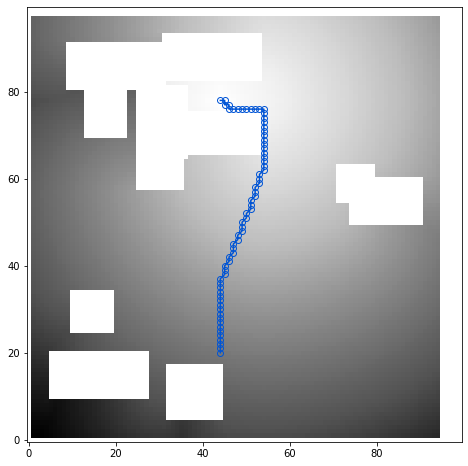

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.11140406131744385 vy:  0.24430218338966372 v:  0.2685040440793726
vx:  -0.18506433069705958 vy:  0.5597922801971437 v:  0.5895898603814926
vx:  -0.22223699092864982 vy:  0.6828442811965942 v:  0.718098595249924
vx:  -0.25075796246528614 vy:  0.7174835801124574 v:  0.7600409485486495
vx:  -0.2828570306301117 vy:  0.6768173575401307 v:  0.7335460689312493
vx:  -0.30514052510261547 vy:  0.6368134021759033 v:  0.7061459121532523
vx:  -0.3214990198612213 vy:  0.5997146368026733 v:  0.6804551898303726
vx:  -0.4163610041141509 vy:  0.6608952283859253 v:  0.7811139408884137
vx:  -0.2854909598827361 vy:  0.9141603708267212 v:  0.9577026008969666
vx:  -0.2514006793498993 vy:  0.9241168498992919 v:  0.9577025915415397
vx:  -0.2327472418546676 vy:  0.9289903044700623 v:  0.9577025970468777
vx:  -0.23016768693923953 vy:  0.905468463897705 v:  0.9342645788127842
vx:  -0.23559105396270758 vy:  0.869249701499939 v:  0.9006098979386093
vx:  -0.2429185658693314

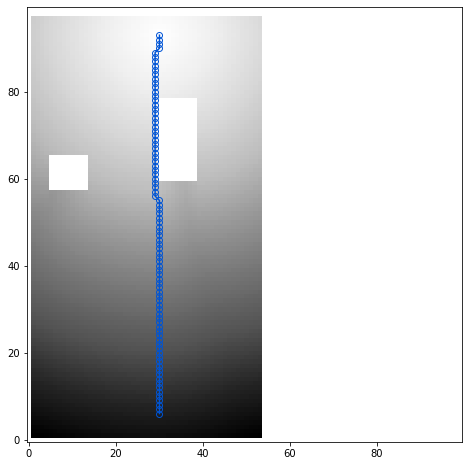

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.039701092988252584 vy:  0.44462162256240845 v:  0.4463905958177106
vx:  -0.08658228814601887 vy:  0.8674240112304688 v:  0.8717344250858495
vx:  -0.14761008322238928 vy:  0.9987615346908569 v:  1.0096104891724118
vx:  -0.17840282618999473 vy:  0.9979642629623414 v:  1.013785104715268
vx:  -0.19315056502819097 vy:  0.9972304701805114 v:  1.015763629702872
vx:  -0.1985743343830109 vy:  0.9964434504508971 v:  1.0160370643938859
vx:  -0.19789636135101316 vy:  0.9963727593421936 v:  1.015835442084567
vx:  -0.2783409059047697 vy:  0.9923369288444518 v:  1.0306339021438826
vx:  -0.02017820626497238 vy:  0.9458107352256774 v:  0.946025954652518
vx:  0.07970941066741985 vy:  0.9968181252479553 v:  0.9999999824858977
vx:  0.07970941066741985 vy:  0.9968181252479553 v:  0.9999999824858977
vx:  0.05963338166475271 vy:  0.9982203245162963 v:  0.9999999782430967
vx:  0.07906153798103321 vy:  0.9906893372535706 v:  0.9938390663159933
vx:  0.11713454872369783 

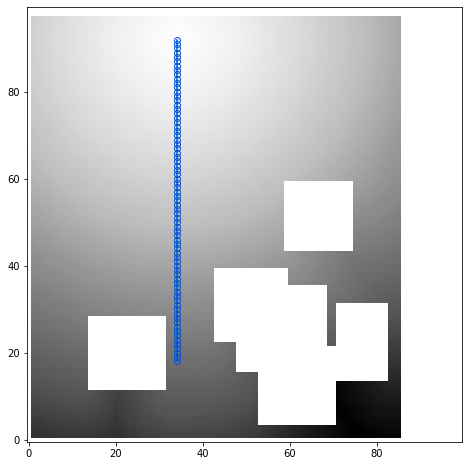

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.271945595741272 vy:  0.2716652452945709 v:  0.38439096314043947
vx:  0.2550163269042969 vy:  0.6051881909370421 v:  0.6567237420996815
vx:  0.1450631320476532 vy:  0.7976074814796448 v:  0.8106916841757887
vx:  0.1335674375295639 vy:  0.7996128797531127 v:  0.8106916909869496
vx:  0.1805489808321 vy:  0.7860895395278931 v:  0.8065573126782033
vx:  0.1860931813716888 vy:  0.7779176235198975 v:  0.7998665520797086
vx:  0.17861701548099523 vy:  0.7907698750495911 v:  0.8106917006515386
vx:  0.15928949415683738 vy:  0.7948886752128601 v:  0.8106917718408131
vx:  0.1419117599725723 vy:  0.798174262046814 v:  0.8106917417936913
vx:  0.11765785515308386 vy:  0.7282848954200745 v:  0.737727768066414
vx:  -0.05375683307647702 vy:  0.6741113066673279 v:  0.676251322275339
vx:  -0.15574322640895832 vy:  0.7787301540374757 v:  0.7941515002689995
vx:  -0.13244765996932978 vy:  0.7997991442680358 v:  0.8106917131704465
vx:  -0.10716064274311068 vy:  0.8035780

vx:  -0.5121663212776185 vy:  0.6284160614013671 v:  0.8106917335697063
vx:  -0.5121663212776185 vy:  0.6284160614013671 v:  0.8106917335697063
vx:  -0.5121663212776185 vy:  0.6284160614013671 v:  0.8106917335697063
vx:  -0.5398586988449097 vy:  0.604792296886444 v:  0.810691764539211


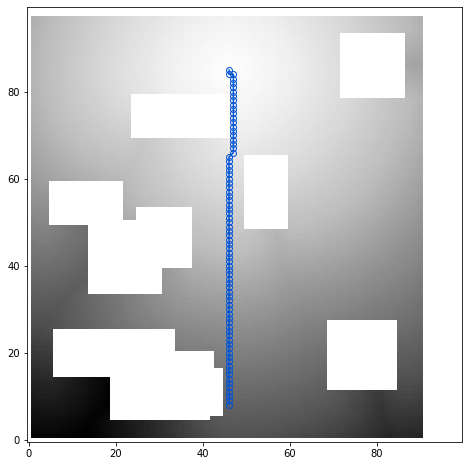

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.0565195605158806 vy:  0.3036252856254578 v:  0.30884101863588187
vx:  -0.019878592342138304 vy:  0.34127378463745117 v:  0.3418522407624006
vx:  0.10026574134826656 vy:  0.3837606012821197 v:  0.39664268300894134
vx:  0.0934826284646988 vy:  0.38262987136840826 v:  0.3938840188279712
vx:  0.08679342269897458 vy:  0.38151490688323975 v:  0.39126298367968565
vx:  0.08020249754190441 vy:  0.3804162442684174 v:  0.3887788053832763
vx:  0.07371442764997484 vy:  0.3793347477912903 v:  0.38643067648110596
vx:  0.0673334449529648 vy:  0.37827104330062866 v:  0.3842170935929062
vx:  0.061063870787620544 vy:  0.37722593545913696 v:  0.3821363666266117
vx:  0.054909773170948 vy:  0.37620013952255255 v:  0.38018630717908947
vx:  0.06475811451673506 vy:  0.37908077239990234 v:  0.3845722889120706
vx:  0.05873134359717365 vy:  0.4018989205360412 v:  0.4061675923172163
vx:  0.05333279818296435 vy:  0.4158767461776734 v:  0.4192825483768121
vx:  0.048417683690

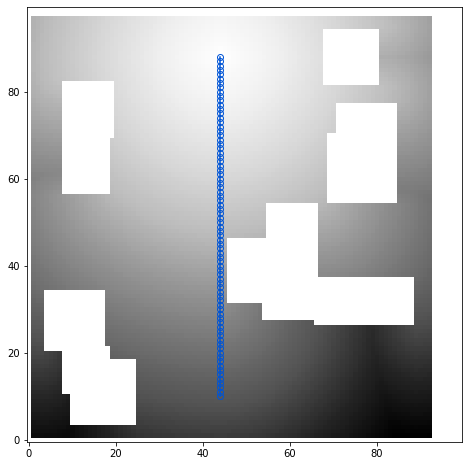

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.14392665028572088 vy:  0.7989172935485839 v:  0.8117781239929186
vx:  0.007369528990238974 vy:  0.8926894068717957 v:  0.8927198256444495
vx:  0.007369528990238974 vy:  0.8926894068717957 v:  0.8927198256444495
vx:  0.007369528990238974 vy:  0.8926894068717957 v:  0.8927198256444495
vx:  0.007369528990238974 vy:  0.8926894068717957 v:  0.8927198256444495
vx:  0.007369528990238974 vy:  0.8926894068717957 v:  0.8927198256444495
vx:  0.007369528990238974 vy:  0.8926894068717957 v:  0.8927198256444495
vx:  0.00521201547235256 vy:  0.8927045464515686 v:  0.8927197613812438
vx:  0.00521201547235256 vy:  0.8927045464515686 v:  0.8927197613812438
vx:  0.00521201547235256 vy:  0.8927045464515686 v:  0.8927197613812438
vx:  0.00521201547235256 vy:  0.8927045464515686 v:  0.8927197613812438
vx:  0.00521201547235256 vy:  0.8927045464515686 v:  0.8927197613812438
vx:  0.00521201547235256 vy:  0.8927045464515686 v:  0.8927197613812438
vx:  0.003653601044788

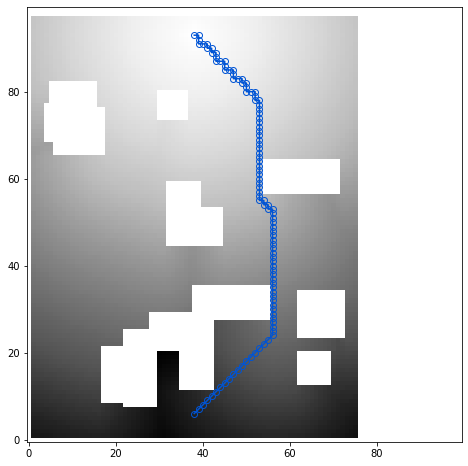

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.2459281086921692 vy:  0.2606943249702454 v:  0.3583882890338345
vx:  0.490325391292572 vy:  0.7375258803367614 v:  0.8856429379342042
vx:  0.6063023805618287 vy:  0.795234203338623 v:  1.0000000074172775
vx:  0.6063023805618287 vy:  0.795234203338623 v:  1.0000000074172775
vx:  0.6063023805618287 vy:  0.795234203338623 v:  1.0000000074172775
vx:  0.6077361702919009 vy:  0.7923334240913391 v:  0.9985667266704675
vx:  0.6141403913497924 vy:  0.7891324758529664 v:  0.9999492410783204
vx:  0.607779562473297 vy:  0.7809591293334962 v:  0.9895924202668313
vx:  0.6071873307228088 vy:  0.7801981568336488 v:  0.9886281497696252
vx:  0.6065101623535157 vy:  0.7793279290199279 v:  0.987525492323402
vx:  0.6057310104370119 vy:  0.77832692861557 v:  0.9862569973456158
vx:  0.6048291921615602 vy:  0.7771679759025573 v:  0.9847885125544892
vx:  0.6037775278091431 vy:  0.7758167982101442 v:  0.9830762978896196
vx:  0.6025421023368835 vy:  0.7742294073104856 v:

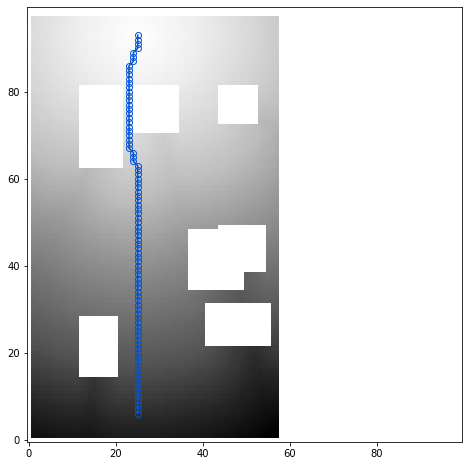

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.09007263183593753 vy:  0.41799056529998774 v:  0.42758530340232187
vx:  -0.055756732821464636 vy:  0.8564721941947937 v:  0.8582851697913512
vx:  0.007787490263581276 vy:  0.9999696612358093 v:  0.9999999841983321
vx:  0.007787490263581276 vy:  0.9999696612358093 v:  0.9999999841983321
vx:  0.007787490263581276 vy:  0.9999696612358093 v:  0.9999999841983321
vx:  0.007787490263581276 vy:  0.9999696612358093 v:  0.9999999841983321
vx:  0.00581361912190928 vy:  0.9999830722808838 v:  0.9999999715078045
vx:  0.00581361912190928 vy:  0.9999830722808838 v:  0.9999999715078045
vx:  0.00581361912190928 vy:  0.9999830722808838 v:  0.9999999715078045
vx:  0.00581361912190928 vy:  0.9999830722808838 v:  0.9999999715078045
vx:  0.004106209613383399 vy:  0.9964662790298461 v:  0.9964747393692306
vx:  -0.012374573387205434 vy:  0.984593093395233 v:  0.9846708534470335
vx:  -0.023154824972152405 vy:  0.9873288273811339 v:  0.9876003034108971
vx:  -0.023598406

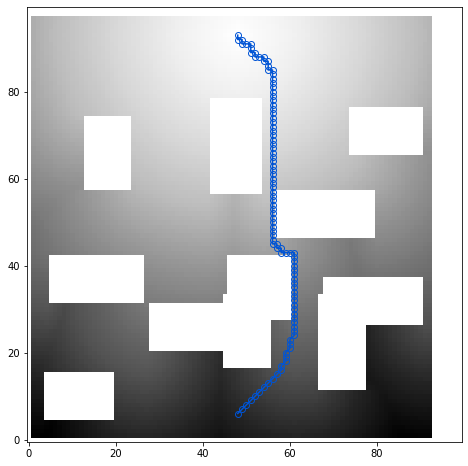

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.06293890625238431 vy:  0.39432695508003235 v:  0.3993182357755983
vx:  0.3428727388381958 vy:  0.382232129573822 v:  0.5134813686171531
vx:  0.3868815898895263 vy:  0.6459657549858095 v:  0.7529602387973979
vx:  0.43418028950691206 vy:  0.724938988685608 v:  0.8450142372249227
vx:  0.4341803193092346 vy:  0.7249389886856079 v:  0.8450142525377787
vx:  0.43418025970458995 vy:  0.7249390482902527 v:  0.8450142730469838
vx:  0.43418020009994507 vy:  0.724938988685608 v:  0.8450141912863597
vx:  0.4341802299022677 vy:  0.7249389886856078 v:  0.8450142065992132
vx:  0.43418020009994507 vy:  0.7249390482902527 v:  0.8450142424212775
vx:  0.43418028950691206 vy:  0.724938988685608 v:  0.8450142372249227
vx:  0.43418025970458995 vy:  0.7249390482902527 v:  0.8450142730469838
vx:  0.4341802299022675 vy:  0.7249389290809631 v:  0.8450141554642973
vx:  0.43418020009994507 vy:  0.724938988685608 v:  0.8450141912863597
vx:  0.4341804087162019 vy:  0.7249388

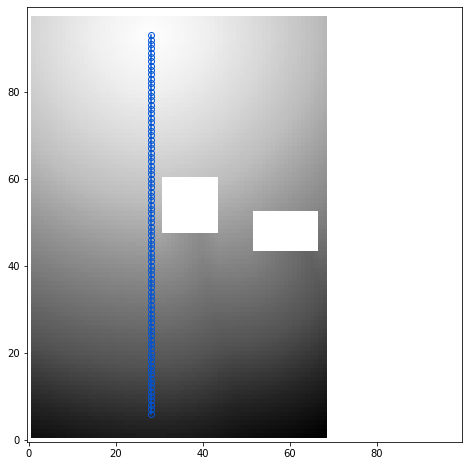

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.10042312741279619 vy:  0.5631709098815918 v:  0.5720544364448428
vx:  -0.1549809873104095 vy:  0.7391006946563721 v:  0.7551747766373299
vx:  -0.030332081019878332 vy:  0.7953272461891174 v:  0.7959054363866108
vx:  0.01328385155648032 vy:  0.8322810530662538 v:  0.8323870566060281
vx:  0.01328385155648032 vy:  0.8322810530662538 v:  0.8323870566060281
vx:  0.01328385155648032 vy:  0.8322810530662538 v:  0.8323870566060281
vx:  0.013283849693834782 vy:  0.8322810530662537 v:  0.8323870565763024
vx:  0.009891048073768616 vy:  0.8323282599449159 v:  0.832387028451867
vx:  0.009891048073768616 vy:  0.8323282599449159 v:  0.832387028451867
vx:  0.009891048073768616 vy:  0.8323282599449159 v:  0.832387028451867
vx:  0.009891048073768616 vy:  0.8323282599449159 v:  0.832387028451867
vx:  0.009891048073768616 vy:  0.8323282599449159 v:  0.832387028451867
vx:  0.009891048073768616 vy:  0.8323282599449159 v:  0.832387028451867
vx:  0.0073653860017655615

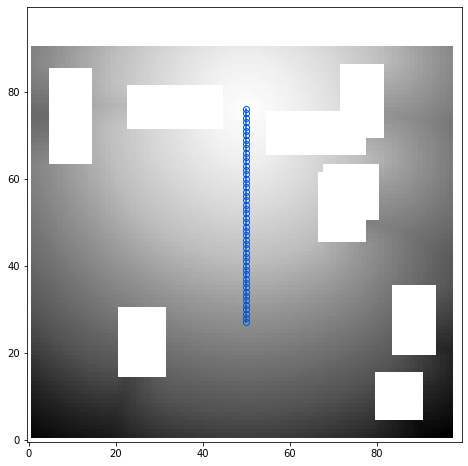

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.07980889827013016 vy:  0.07753601670265199 v:  0.1112712637171247
idx:  0
vx:  -0.0040730237960815985 vy:  0.18534652888774872 v:  0.1853912762067852
idx:  0
vx:  -0.37908369302749634 vy:  0.3806330561637878 v:  0.5372019822785005
vx:  -0.3658111095428466 vy:  0.5779393911361694 v:  0.6839822422342665
vx:  -0.2698350250720979 vy:  0.7786924839019775 v:  0.8241194848085387
vx:  -0.1996430009603502 vy:  0.906297504901886 v:  0.9280261285243204
vx:  -0.1987682431936264 vy:  0.9080679416656493 v:  0.9295677496466676
vx:  -0.19876828789711004 vy:  0.9080678820610046 v:  0.9295677009794967
vx:  -0.19876827299594907 vy:  0.9080679416656494 v:  0.9295677560192595
vx:  -0.19876828789711015 vy:  0.9080679416656494 v:  0.9295677592055556
vx:  -0.19876831769943232 vy:  0.9080678820610046 v:  0.9295677073520902
vx:  -0.19876825809478743 vy:  0.9080680012702942 v:  0.9295678110590228
vx:  -0.19876828789711004 vy:  0.9080678820610046 v:  0.9295677009794967
vx

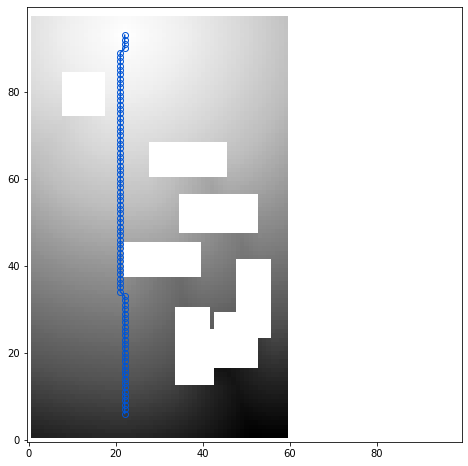

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.06409657001495364 vy:  0.5171575546264647 v:  0.5211144851133067
vx:  0.015451384708285276 vy:  0.8521384596824647 v:  0.8522785341421002
vx:  -0.00426968466490496 vy:  0.9999908804893494 v:  0.9999999956345009
vx:  -0.00426968466490496 vy:  0.9999908804893494 v:  0.9999999956345009
vx:  -0.00426968466490496 vy:  0.9999908804893494 v:  0.9999999956345009
vx:  -0.00426968466490496 vy:  0.9999908804893494 v:  0.9999999956345009
vx:  -0.0031821979209779583 vy:  0.9999949336051941 v:  0.9999999968098324
vx:  -0.0031821979209779583 vy:  0.9999949336051941 v:  0.9999999968098324
vx:  -0.0031821979209779583 vy:  0.9999949336051941 v:  0.9999999968098324
vx:  -0.008273297920823208 vy:  0.9943868517875671 v:  0.9944212681084791
vx:  -0.029561173170804977 vy:  0.9936377406120301 v:  0.9940773725056891
vx:  -0.030317718163132612 vy:  0.9991030097007751 v:  0.999562898485016
vx:  -0.03031626157462608 vy:  0.9990549087524414 v:  0.9995147754876914
vx:  -0.0

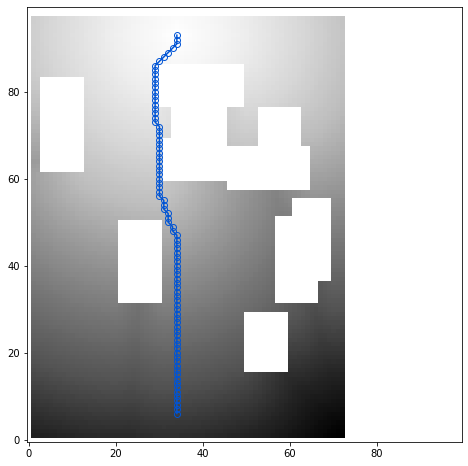

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.018949732184409873 vy:  0.6491858363151551 v:  0.6494623487332182
vx:  -0.025526419281959534 vy:  0.9368891716003418 v:  0.9372368526382928
vx:  0.0003571583365557518 vy:  0.9999999403953553 v:  1.0000000041763957
vx:  0.0003571583365557518 vy:  0.9999999403953553 v:  1.0000000041763957
vx:  0.0003571583365557518 vy:  0.9999999403953553 v:  1.0000000041763957
vx:  0.0003571583365557518 vy:  0.9999999403953553 v:  1.0000000041763957
vx:  0.000265173235675209 vy:  0.9999999403953552 v:  0.9999999755537792
vx:  0.000265173235675209 vy:  0.9999999403953552 v:  0.9999999755537792
vx:  0.000265173235675209 vy:  0.9999999403953552 v:  0.9999999755537792
vx:  0.000265173235675209 vy:  0.9999999403953552 v:  0.9999999755537792
vx:  0.000265173235675209 vy:  0.9999999403953552 v:  0.9999999755537792
vx:  0.00019687865278689154 vy:  1.0 v:  1.0000000193806018
vx:  0.00019687865278689154 vy:  1.0 v:  1.0000000193806018
vx:  0.00019687865278689154 vy:  1.0 v

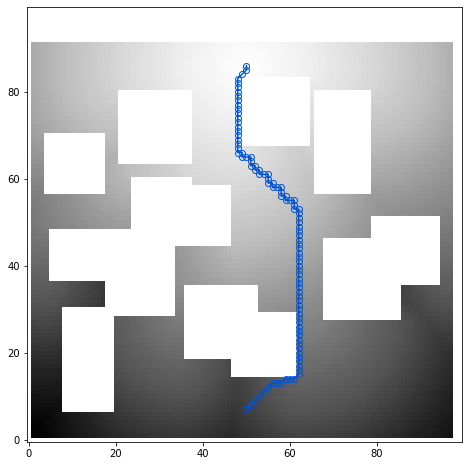

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.352019727230072 vy:  0.2770889401435853 v:  0.44799126008107537
vx:  0.6349106431007382 vy:  0.5722211599349978 v:  0.8547213467557407
vx:  0.6349106431007385 vy:  0.5722212195396422 v:  0.8547213866600208
vx:  0.6324363946914671 vy:  0.5699913501739503 v:  0.8513905875703959
vx:  0.6165354251861572 vy:  0.5556602478027343 v:  0.8299844826848702
vx:  0.5978790521621705 vy:  0.5388461351394653 v:  0.8048692554502714
vx:  0.576093316078186 vy:  0.5192113518714905 v:  0.7755410606422986
vx:  0.5328811407089235 vy:  0.48026585578918446 v:  0.7173685261845275
vx:  0.5138838887214662 vy:  0.463144302368164 v:  0.6917942583626938
vx:  0.4935283660888671 vy:  0.44479858875274664 v:  0.6643914754802185
vx:  0.47190600633621205 vy:  0.42531117796897894 v:  0.6352833044568018
vx:  0.44916075468063354 vy:  0.40481197834014876 v:  0.6046636431545569
vx:  0.42548757791519176 vy:  0.38347595930099476 v:  0.5727944573072915
vx:  0.40112754702568054 vy:  0.36152

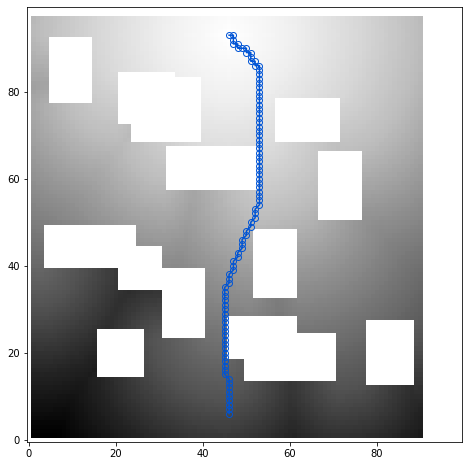

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.24947437644004822 vy:  0.5901416540145873 v:  0.6407063573145062
vx:  0.0027761459350586493 vy:  0.7243984937667848 v:  0.7244038133236457
vx:  0.0036915312521158816 vy:  0.9998969435691833 v:  0.9999037579497239
vx:  0.0036917049437761584 vy:  0.9999454617500305 v:  0.9999522764411678
vx:  0.0036916830576955717 vy:  0.9999396204948425 v:  0.9999464351449873
vx:  0.0036916495300829133 vy:  0.9999327063560486 v:  0.9999395209295333
vx:  0.0036916243843733987 vy:  0.9999244213104248 v:  0.9999312358475373
vx:  0.0036915889941156743 vy:  0.999914288520813 v:  0.999921102996324
vx:  0.0036917338147759993 vy:  0.9999548196792603 v:  0.9999616344132114
vx:  0.0036917107645422498 vy:  0.999950408935547 v:  0.9999572236144588
vx:  0.0036917014513163926 vy:  0.9999446868896485 v:  0.9999515015731728
vx:  0.0036916788667440137 vy:  0.9999380707740784 v:  0.9999448854193119
vx:  0.0036916413810104964 vy:  0.9999299049377443 v:  0.9999367195002353
vx:  0.

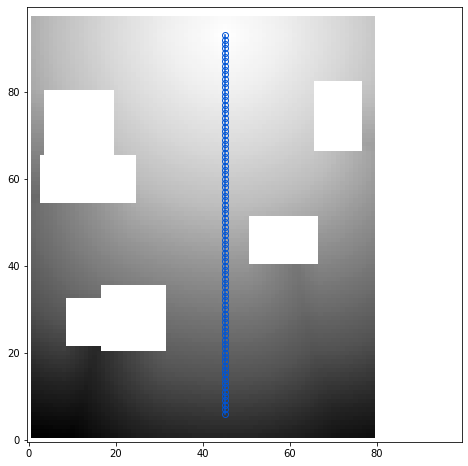

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.30890357494354237 vy:  0.5319097638130188 v:  0.6151011424575004
vx:  -0.3859400153160094 vy:  0.7741185426712036 v:  0.8649908748244166
vx:  -0.38780415058135975 vy:  0.8067691326141357 v:  0.8951360190200677
vx:  -0.40601521730422974 vy:  0.8501266837120055 v:  0.9421060105114355
vx:  -0.4129239916801451 vy:  0.9752624630928042 v:  1.0590765292569313
vx:  -0.3782313466072086 vy:  0.9892342090606691 v:  1.0590766128718876
vx:  -0.3687724173069 vy:  0.9927991628646851 v:  1.0590766136362344
vx:  -0.3638373315334318 vy:  0.99461829662323 v:  1.0590765599308973
vx:  -0.3612490296363826 vy:  0.9955613017082217 v:  1.0590765632720784
vx:  -0.359886050224304 vy:  0.9960548281669617 v:  1.059076574125198
vx:  -0.35916569828987155 vy:  0.9963148236274718 v:  1.059076591473861
vx:  -0.35598558187484725 vy:  0.9974554777145386 v:  1.0590765621641864
vx:  -0.3301540613174438 vy:  1.006300926208496 v:  1.0590766064324524
vx:  -0.2938253879547114 vy:  1.01

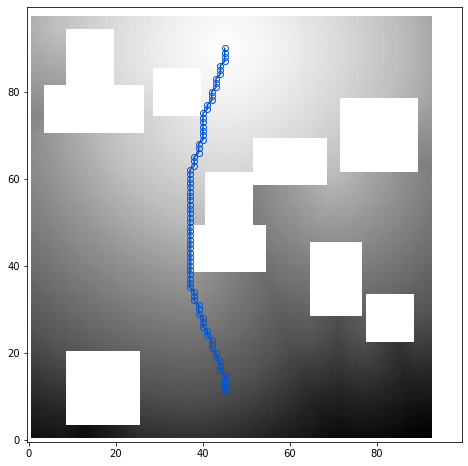

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.045189157128334045 vy:  0.5684266090393066 v:  0.5702200187523181
vx:  -0.30845993757247925 vy:  0.7742652297019957 v:  0.8334471662995213
vx:  -0.35591912269592296 vy:  0.9345167875289917 v:  1.0000000240370708
vx:  -0.25505647063255316 vy:  0.9669261574745178 v:  0.9999999986099852
vx:  -0.25505647063255316 vy:  0.9669261574745178 v:  0.9999999986099852
vx:  -0.25505647063255316 vy:  0.9669261574745178 v:  0.9999999986099852
vx:  -0.25505647063255316 vy:  0.9669261574745178 v:  0.9999999986099852
vx:  -0.25505647063255316 vy:  0.9669261574745178 v:  0.9999999986099852
vx:  -0.21811105310916895 vy:  0.975162446498871 v:  0.9992568381302447
vx:  -0.21808977425098414 vy:  0.9750672578811647 v:  0.9991593001242289
vx:  -0.21806399524211878 vy:  0.9749521017074585 v:  0.9990412937635488
vx:  -0.21803238987922668 vy:  0.9748108386993409 v:  0.9988965383272482
vx:  -0.2179930806159972 vy:  0.974635124206543 v:  0.9987164805556962
vx:  -0.2170871198

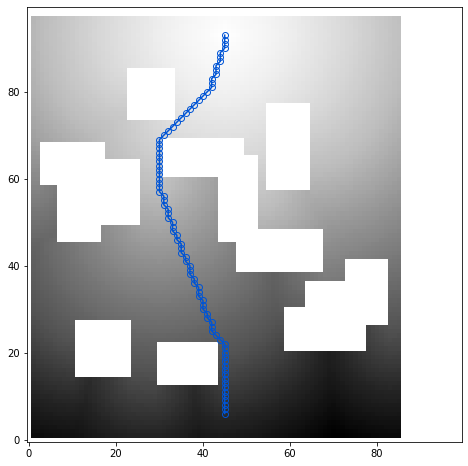

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.18270821869373327 vy:  0.39097255468368525 v:  0.4315574488919457
vx:  -0.008764260448515193 vy:  0.9406179189682007 v:  0.9406587488272662
vx:  -0.008764260448515193 vy:  0.9406179189682007 v:  0.9406587488272662
vx:  -0.008764260448515193 vy:  0.9406179189682007 v:  0.9406587488272662
vx:  -0.008764260448515193 vy:  0.9406179189682007 v:  0.9406587488272662
vx:  -0.008764260448515193 vy:  0.9406179189682007 v:  0.9406587488272662
vx:  -0.006562967319041435 vy:  0.9406358599662781 v:  0.9406587551256461
vx:  -0.006562967319041435 vy:  0.9406358599662781 v:  0.9406587551256461
vx:  -0.006562967319041435 vy:  0.9406358599662781 v:  0.9406587551256461
vx:  -0.006562967319041435 vy:  0.9406358599662781 v:  0.9406587551256461
vx:  -0.006562967319041435 vy:  0.9406358599662781 v:  0.9406587551256461
vx:  -0.05674865469336532 vy:  0.9343569874763488 v:  0.9360787305859398
vx:  -0.0826520100235939 vy:  0.9370205402374266 v:  0.9406587306711075
vx:  -0.

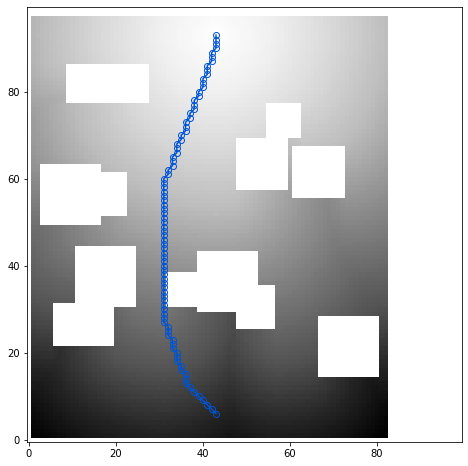

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.3321366906166078 vy:  0.7078670263290405 v:  0.7819146425394979
vx:  -0.37804114818573 vy:  0.7543776035308838 v:  0.8438013263977394
vx:  -0.37804114818573 vy:  0.7543776035308838 v:  0.8438013263977394
vx:  -0.37804114818573 vy:  0.7543776631355286 v:  0.8438013796856497
vx:  -0.37804114818573 vy:  0.7543776631355286 v:  0.8438013796856497
vx:  -0.37804114818573 vy:  0.7543776631355286 v:  0.8438013796856497
vx:  -0.37804114818573 vy:  0.7543776631355286 v:  0.8438013796856497
vx:  -0.2958373129367828 vy:  0.7902410626411438 v:  0.8438013112160114
vx:  -0.2958373129367828 vy:  0.7902410626411438 v:  0.8438013112160114
vx:  -0.2958373129367828 vy:  0.7902410626411438 v:  0.8438013112160114
vx:  -0.2958373129367828 vy:  0.7902410626411438 v:  0.8438013112160114
vx:  -0.2958373129367828 vy:  0.7902410626411438 v:  0.8438013112160114
vx:  -0.2958373129367828 vy:  0.7902410626411438 v:  0.8438013112160114
vx:  -0.2958373129367828 vy:  0.790241062

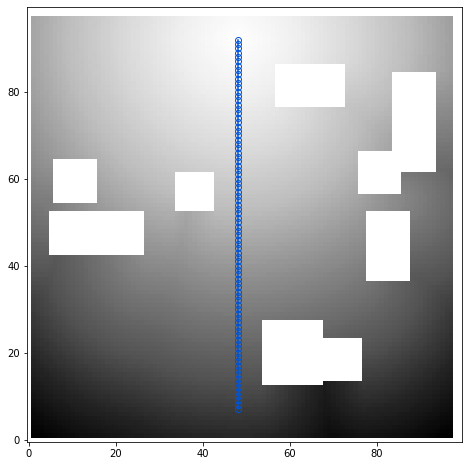

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.011920657940208912 vy:  0.4346607625484467 v:  0.4348241950316526
vx:  0.012002294883131898 vy:  0.9478263258934022 v:  0.9479023151881462
vx:  -5.863136720962725e-06 vy:  0.9999999999999999 v:  1.000000000017188
vx:  -5.863136720962725e-06 vy:  0.9999999999999999 v:  1.000000000017188
vx:  -4.130916749944813e-06 vy:  1.0 v:  1.0000000000085323
vx:  -4.130916749944813e-06 vy:  1.0 v:  1.0000000000085323
vx:  -4.130916749944813e-06 vy:  1.0 v:  1.0000000000085323
vx:  -4.130916749944813e-06 vy:  1.0 v:  1.0000000000085323
vx:  -4.130916749944813e-06 vy:  1.0 v:  1.0000000000085323
vx:  -2.9104683107461504e-06 vy:  1.0 v:  1.0000000000042353
vx:  -2.9104683107461504e-06 vy:  1.0 v:  1.0000000000042353
vx:  -2.9104683107461504e-06 vy:  1.0 v:  1.0000000000042353
vx:  -2.9104683107461504e-06 vy:  1.0 v:  1.0000000000042353
vx:  -0.0014004077529534698 vy:  0.9982656240463258 v:  0.9982666063204132
vx:  -0.013909005559980897 vy:  0.9890909790992737 

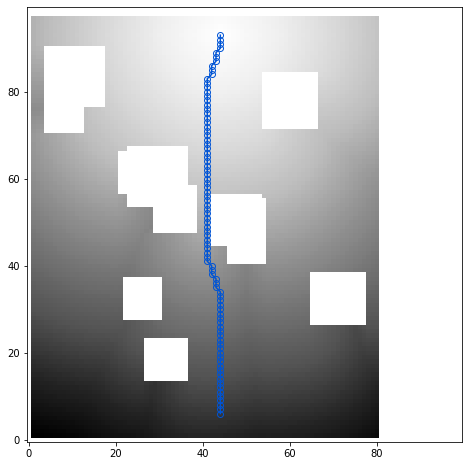

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.1579341441392899 vy:  0.35264697670936584 v:  0.38639757254318513
vx:  0.10116297751665122 vy:  0.698669195175171 v:  0.7059550922734078
vx:  -0.08081452548503858 vy:  0.7531910538673402 v:  0.7575141920486814
vx:  -0.04849057644605657 vy:  0.8149746656417846 v:  0.8164159734118444
vx:  -0.021519357338547762 vy:  0.8161323070526123 v:  0.8164159634373176
vx:  -0.007307433988899076 vy:  0.8163832426071167 v:  0.8164159463173245
vx:  -0.004271666519343999 vy:  0.8164048790931702 v:  0.8164160543142119
vx:  -0.004271666519343999 vy:  0.8164048790931702 v:  0.8164160543142119
vx:  -0.004271666519343999 vy:  0.8164048790931702 v:  0.8164160543142119
vx:  -0.004271666519343999 vy:  0.8164048790931702 v:  0.8164160543142119
vx:  -0.004271666519343999 vy:  0.8164048790931702 v:  0.8164160543142119
vx:  -0.004271666519343999 vy:  0.8164048790931702 v:  0.8164160543142119
vx:  -0.0031706353183834426 vy:  0.8164098858833314 v:  0.8164160426500428
vx:  -0.

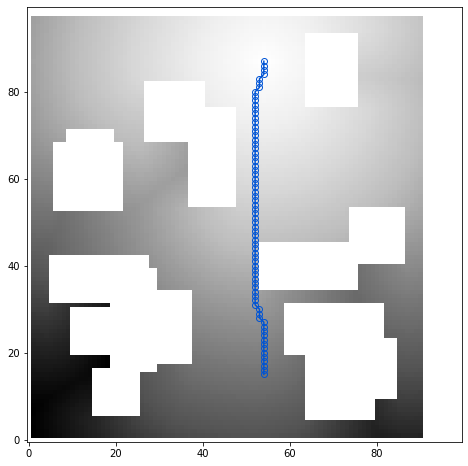

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.08106067776679993 vy:  0.23922023177146912 v:  0.25258098259530226
vx:  -0.08881227672100069 vy:  0.34647879004478455 v:  0.35768026566651046
vx:  -0.10250756144523622 vy:  0.40004393458366394 v:  0.4129684609635797
vx:  -0.14141523838043213 vy:  0.4300767481327057 v:  0.45272980786623407
vx:  -0.2548114061355592 vy:  0.5000826120376586 v:  0.5612588276002332
vx:  -0.25435268878936756 vy:  0.5629843473434448 v:  0.6177755787080819
vx:  -0.29743692278861994 vy:  0.6303795576095582 v:  0.6970273378354581
vx:  -0.3114094138145447 vy:  0.6515392065048218 v:  0.7221351401401618
vx:  -0.30123242735862743 vy:  0.6372562646865845 v:  0.7048663151085239
vx:  -0.2913540601730347 vy:  0.6207273006439208 v:  0.6857037043388352


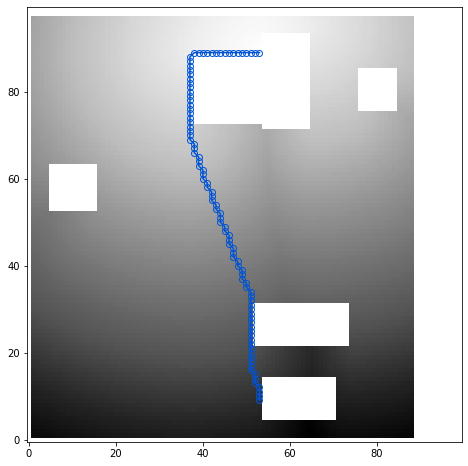

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.045301940292119966 vy:  0.43405404686927795 v:  0.4364117108852925
vx:  -0.06161142885684967 vy:  0.5198860764503479 v:  0.5235241165913177
vx:  -0.14898559451103213 vy:  0.5620031356811523 v:  0.5814157134849843
vx:  -0.21118026971817025 vy:  0.6791040301322938 v:  0.7111816856895027
vx:  -0.1457037776708603 vy:  0.7559412717819214 v:  0.7698550494806332
vx:  -0.10944049805402761 vy:  0.7924138307571411 v:  0.7999355610232118
vx:  -0.07029411196708676 vy:  0.797314465045929 v:  0.8004071578569979
vx:  -0.0481643602252006 vy:  0.7989567518234253 v:  0.8004072069141689
vx:  -0.03607358410954489 vy:  0.7995938658714294 v:  0.8004071800088539
vx:  -0.02956968173384672 vy:  0.7998607754707336 v:  0.8004071627706016
vx:  -0.02613704837858677 vy:  0.7999802827835083 v:  0.8004071452331785
vx:  -0.024390703067183522 vy:  0.8000354766845703 v:  0.8004071903412782
vx:  -0.02357851713895795 vy:  0.8000597953796387 v:  0.8004071605460444
vx:  -0.02329568

vx:  0.00026663392782211304 vy:  0.0005383789539337158 v:  0.0006007874412008043
idx:  0
vx:  0.00025595724582672125 vy:  0.00043070316314697266 v:  0.0005010182895224568
idx:  0
vx:  0.00024574995040893555 vy:  0.0003445595502853394 v:  0.0004232189998320369
idx:  0
vx:  0.00023587793111801147 vy:  0.00027564913034439087 v:  0.0003627958674628645
idx:  0
vx:  0.00022648274898529053 vy:  0.00022051483392715457 v:  0.00031610319133133514
idx:  0
vx:  0.00021742284297943118 vy:  0.00017641484737396243 v:  0.00027999087667857477
idx:  0
vx:  0.0002086982131004333 vy:  0.00014112889766693115 v:  0.00025193711498704786
idx:  0
vx:  0.00020035356283187866 vy:  0.00011290609836578373 v:  0.00022997681880487778
idx:  0
vx:  0.00019234418869018557 vy:  9.032338857650757e-05 v:  0.0002124961210159576
idx:  0
vx:  0.000184670090675354 vy:  7.226318120956421e-05 v:  0.00019830534473021594
idx:  0
vx:  0.0001772791147232056 vy:  5.7809054851531996e-05 v:  0.00018646654214595957
idx:  0
vx:  0.00017

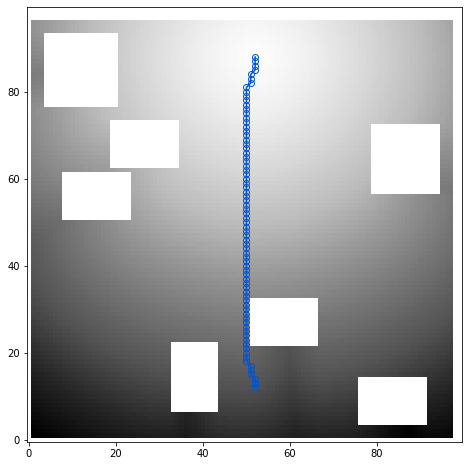

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.06116244941949843 vy:  0.3499203324317932 v:  0.3552253992441551
vx:  -0.19512845575809476 vy:  0.6473089456558228 v:  0.6760798661198184
vx:  -0.14882154762744906 vy:  0.7941387891769408 v:  0.8079630372199255
vx:  -0.12829720973968503 vy:  0.8740825653076172 v:  0.8834480771396436
vx:  -0.10789989680051792 vy:  0.893049657344818 v:  0.8995443725649442
vx:  -0.09688319265842435 vy:  0.8937072157859802 v:  0.8989432354535063
vx:  -0.09111131727695457 vy:  0.8898199796676637 v:  0.894472396640446
vx:  -0.09199813008308423 vy:  0.8955779671669006 v:  0.9002908148001857
vx:  -0.0877800956368447 vy:  0.8922534584999083 v:  0.8965609736069607
vx:  -0.08381465822458262 vy:  0.888136327266693 v:  0.8920824136502602
vx:  -0.0797917991876603 vy:  0.8833457827568053 v:  0.8869422208531044
vx:  -0.07551744580268863 vy:  0.8779008984565735 v:  0.8811429351310835
vx:  -0.07085099816322325 vy:  0.8717592358589172 v:  0.8746336543067894
vx:  -0.06567091494798

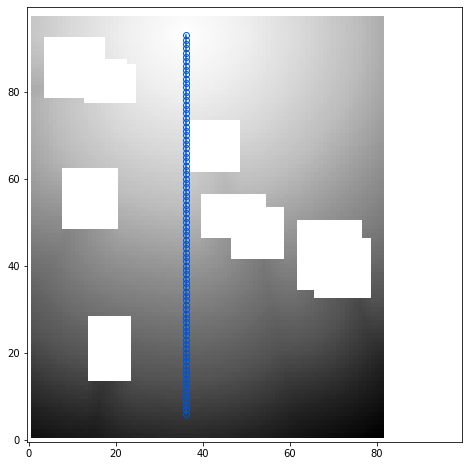

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.05746230483055109 vy:  0.5636547803878783 v:  0.5665762331147914
vx:  0.046579010784626076 vy:  0.8461490273475647 v:  0.847430103741249
vx:  0.007522348314523641 vy:  0.974757969379425 v:  0.9747869944725694
vx:  -0.006065366324037258 vy:  0.9947546720504759 v:  0.9947731632060117
vx:  -0.006065366324037258 vy:  0.9947546720504759 v:  0.9947731632060117
vx:  -0.006065366324037258 vy:  0.9947546720504759 v:  0.9947731632060117
vx:  -0.006065366324037258 vy:  0.9947546720504759 v:  0.9947731632060117
vx:  -0.006065366324037258 vy:  0.9947546720504759 v:  0.9947731632060117
vx:  -0.0044103087857364776 vy:  0.9947633743286133 v:  0.9947731508888016
vx:  -0.0044103087857364776 vy:  0.9947633743286133 v:  0.9947731508888016
vx:  -0.0044103087857364776 vy:  0.9947633743286133 v:  0.9947731508888016
vx:  -0.0044103087857364776 vy:  0.9947633743286133 v:  0.9947731508888016
vx:  -0.0044103087857364776 vy:  0.9947633743286133 v:  0.9947731508888016
vx: 

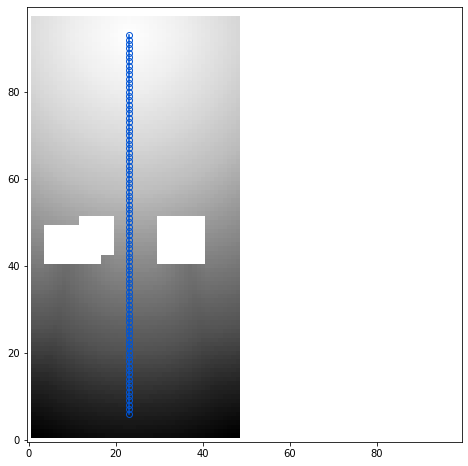

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.04250757396221155 vy:  0.6507995724678038 v:  0.6521863057197913
vx:  -0.0021968593355268795 vy:  0.999997615814209 v:  1.0000000289125208
vx:  -0.0021968593355268795 vy:  0.999997615814209 v:  1.0000000289125208
vx:  -0.0021968593355268795 vy:  0.999997615814209 v:  1.0000000289125208
vx:  -0.0021968593355268795 vy:  0.999997615814209 v:  1.0000000289125208
vx:  -0.0021968593355268795 vy:  0.999997615814209 v:  1.0000000289125208
vx:  -0.0016291741048917174 vy:  0.9999986886978149 v:  1.0000000158028066
vx:  0.0024899081327020567 vy:  0.9976256489753722 v:  0.9976287561693687
vx:  0.004324842710048016 vy:  0.9989736080169677 v:  0.9989829697141512
vx:  0.0043146465905011255 vy:  0.9989119172096251 v:  0.998921235392766
vx:  0.004303063265979179 vy:  0.9988420605659485 v:  0.9988513294325142
vx:  0.004311989061534294 vy:  0.998896062374115 v:  0.9989053692298278
vx:  0.00430219760164624 vy:  0.9988368153572083 v:  0.9988460805435107
vx:  0.0042

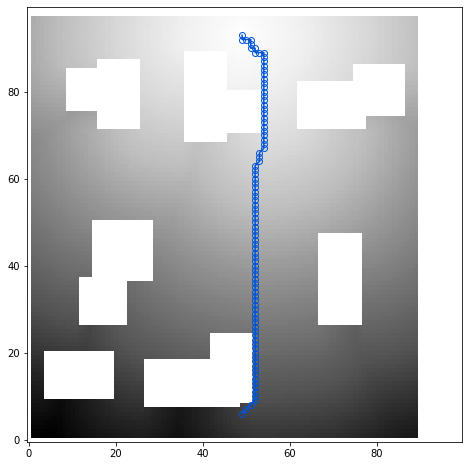

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  6.938893903907228e-18 vy:  0.11884649842977522 v:  0.11884649842977522
idx:  0
vx:  -0.04172515869140624 vy:  0.11409261077642441 v:  0.12148297288757676
idx:  0
vx:  0.3156163096427917 vy:  0.10952890664339071 v:  0.33408118220431265
vx:  0.40707182884216303 vy:  0.6945650577545166 v:  0.8050640305531221
vx:  0.40707188844680775 vy:  0.6945650577545166 v:  0.8050640606915609
vx:  0.40707200765609736 vy:  0.6945649385452272 v:  0.8050640181212305
vx:  0.4037364721298217 vy:  0.6888744235038757 v:  0.7984679769944637
vx:  0.3915286660194396 vy:  0.6680446863174438 v:  0.7743244792927148
vx:  0.3968952894210816 vy:  0.6772030591964722 v:  0.7849393952081298
vx:  0.14027857780456493 vy:  0.7927483916282654 v:  0.8050640296399244
vx:  -0.0026911864988507506 vy:  0.8050595521926879 v:  0.8050640502851079
vx:  -0.0026911664754156184 vy:  0.805059552192688 v:  0.8050640502181735
vx:  -0.0026911785826087 vy:  0.8050595521926881 v:  0.8050640502586456
vx: 

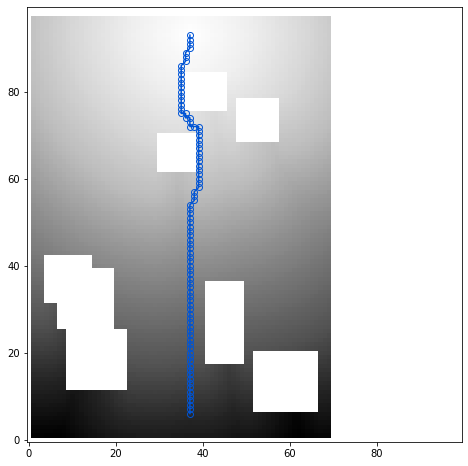

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.040816374123096424 vy:  0.5376969575881957 v:  0.539243910115041
vx:  -0.008078813552856515 vy:  0.8955689072608948 v:  0.8956053454959361
vx:  -0.0019964247476308983 vy:  0.9999980330467224 v:  1.000000025904543
vx:  -0.0019964247476308983 vy:  0.9999980330467224 v:  1.000000025904543
vx:  -0.0019964247476308983 vy:  0.9999980330467224 v:  1.000000025904543
vx:  -0.0014538624091073038 vy:  0.999998927116394 v:  0.9999999839749217
vx:  -0.0014538624091073038 vy:  0.999998927116394 v:  0.9999999839749217
vx:  -0.0014538624091073038 vy:  0.999998927116394 v:  0.9999999839749217
vx:  -0.0014538624091073038 vy:  0.999998927116394 v:  0.9999999839749217
vx:  -0.0014538624091073038 vy:  0.999998927116394 v:  0.9999999839749217
vx:  -0.0010587502038107294 vy:  0.999999463558197 v:  1.0000000240343376
vx:  -0.0010587502038107294 vy:  0.999999463558197 v:  1.0000000240343376
vx:  -0.0010587503202258847 vy:  0.9999994635581969 v:  1.0000000240344609
vx: 

vx:  -0.008095808327198029 vy:  0.028922507539391514 v:  0.03003420641263704
idx:  0
vx:  -0.007866203784942627 vy:  0.027781730517745018 v:  0.028873893269644995
idx:  0
vx:  -0.007458504289388658 vy:  0.026567569002509117 v:  0.027594655441550858
idx:  0
vx:  -0.00725545361638069 vy:  0.02552640251815319 v:  0.026537498614191753
idx:  0
vx:  -0.006860416382551193 vy:  0.024399133399128914 v:  0.025345276158891324
idx:  0
vx:  -0.006576573941856621 vy:  0.023381112143397328 v:  0.024288427900439124
idx:  0
vx:  -0.006272549740970133 vy:  0.022384975105524063 v:  0.023247193179562056
idx:  0
vx:  -0.005918478593230251 vy:  0.02139044739305973 v:  0.02219413500305386
idx:  0
vx:  -0.005599331576377152 vy:  0.0204510185867548 v:  0.02120369485108679
idx:  0
vx:  -0.005383739247918129 vy:  0.01960864663124084 v:  0.020334297897848522
idx:  0
vx:  -0.004924276843667031 vy:  0.018639596179127697 v:  0.019279083177216366
idx:  0
vx:  -0.004857098683714866 vy:  0.01795002073049545 v:  0.01859

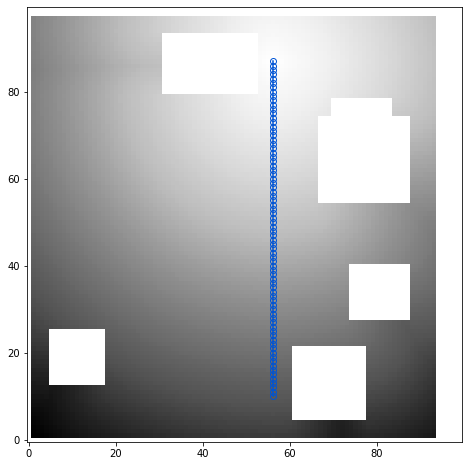

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.05899025872349735 vy:  0.17084005475044253 v:  0.1807378624732498
idx:  0
vx:  -0.07535506784915925 vy:  0.15728214383125308 v:  0.1744020040558777
idx:  0
vx:  0.15048107504844663 vy:  0.3583873510360718 v:  0.3886978869641418
vx:  0.2858690023422239 vy:  0.5347460508346558 v:  0.6063616292142823
vx:  0.3389164209365844 vy:  0.6538912057876587 v:  0.7365039371156833
vx:  0.2797955572605133 vy:  0.703557014465332 v:  0.7571512573231934
vx:  0.24802207946777327 vy:  0.7563305497169495 v:  0.7959590770502346
vx:  0.22501298785209678 vy:  0.7659512758255003 v:  0.7983183585768522
vx:  0.14785730838775657 vy:  0.7112570405006409 v:  0.72646291116987
vx:  0.08330739289522188 vy:  0.6975423693656921 v:  0.7024994510825632
vx:  0.06195877492427848 vy:  0.7012009620666504 v:  0.7039330074611599
vx:  0.10788765549659746 vy:  0.6748170256614685 v:  0.683386979925096


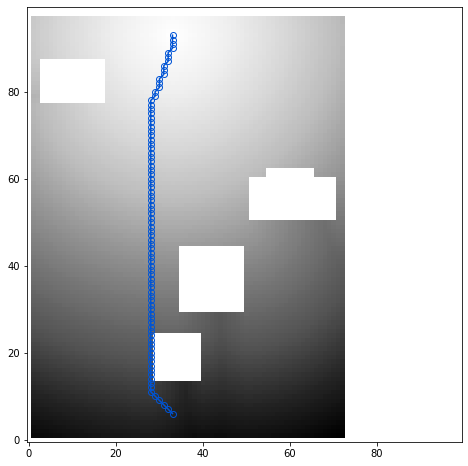

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.24253562092781056 vy:  0.3375694155693055 v:  0.4156640924432144
vx:  -0.34038296341896046 vy:  0.7308051586151124 v:  0.8061865427085303
vx:  -0.3427910208702088 vy:  0.9313038587570192 v:  0.9923873040929906
vx:  -0.34250187873840343 vy:  0.9305179715156555 v:  0.9915499141510459
vx:  -0.34216275811195385 vy:  0.929596483707428 v:  0.990568006529584
vx:  -0.3417615294456482 vy:  0.9285069108009338 v:  0.989406906390956
vx:  -0.3412826657295227 vy:  0.9272057414054873 v:  0.9880204172094565
vx:  -0.34070491790771473 vy:  0.9256358742713928 v:  0.9863476125710795
vx:  -0.33675071597099304 vy:  0.914892852306366 v:  0.9748999825152601
vx:  -0.3357742428779602 vy:  0.9122405648231506 v:  0.9720736547654855
vx:  -0.33805471658706676 vy:  0.9184359312057496 v:  0.9786754064226476
vx:  -0.3332633674144745 vy:  0.90541809797287 v:  0.964803816429664
vx:  -0.22264237701892864 vy:  0.9132729768753053 v:  0.9400197648641866
vx:  -0.1840408593416214 vy: 

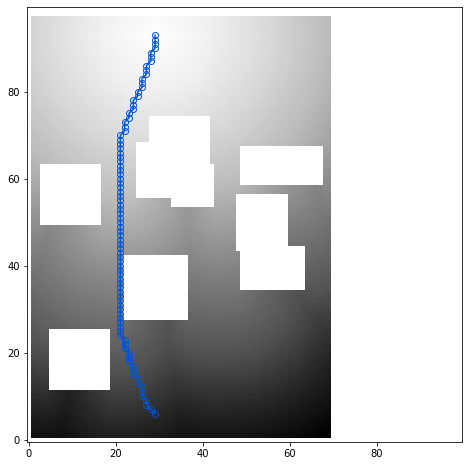

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.18082305788993855 vy:  0.5581904649734496 v:  0.5867483050269032
vx:  -0.24059569835662803 vy:  0.9174646139144899 v:  0.9484870098493587
vx:  -0.2783052325248722 vy:  0.9278364777565 v:  0.9686765878797274
vx:  -0.27758708596229564 vy:  0.9417667388916016 v:  0.9818244144324182
vx:  -0.2775870561599732 vy:  0.9417667388916016 v:  0.9818244060065334
vx:  -0.2775870263576505 vy:  0.9417667388916016 v:  0.9818243975806493
vx:  -0.2775870561599732 vy:  0.9417667388916016 v:  0.9818244060065334
vx:  -0.27758708596229564 vy:  0.9417667388916016 v:  0.9818244144324182
vx:  -0.2775870561599732 vy:  0.9417667388916016 v:  0.9818244060065334
vx:  -0.2775870561599733 vy:  0.9417666792869567 v:  0.9818243488337115
vx:  -0.2775870561599733 vy:  0.9417666792869567 v:  0.9818243488337115
vx:  -0.2775870561599732 vy:  0.9417667388916016 v:  0.9818244060065334
vx:  -0.2774944007396696 vy:  0.941452383995056 v:  0.9814966804690899
vx:  -0.27692201733589195 vy: 

vx:  0.4372931122779846 vy:  0.16605654358863817 v:  0.46776066713050096
vx:  0.41374552249908453 vy:  0.15711730718612654 v:  0.44257339007836893
vx:  0.3882859647274017 vy:  0.1474506705999375 v:  0.4153404515149714
vx:  0.36340269446372986 vy:  0.13800211250781996 v:  0.38872368258201095
vx:  0.33925855159759527 vy:  0.12883386015892018 v:  0.3628974074797813
vx:  0.31598877906799305 vy:  0.11999740451574337 v:  0.3380063395668724
vx:  0.2937006652355194 vy:  0.11153361201286316 v:  0.3141652867017974
vx:  0.27247330546379084 vy:  0.10347256064414982 v:  0.2914588701628783
vx:  0.2523587644100189 vy:  0.0958340838551521 v:  0.26994280431770684
vx:  0.2333846986293793 vy:  0.08862861245870582 v:  0.24964664728508104
idx:  0
vx:  -0.020903605967760086 vy:  -0.007938258349895467 v:  0.02236015849865694
idx:  0
vx:  -0.1556449979543686 vy:  -0.006844602525234195 v:  0.15579542346277006
idx:  0
vx:  -0.22206078469753265 vy:  0.009213248267769784 v:  0.22225183023797018
idx:  0
vx:  -0.25

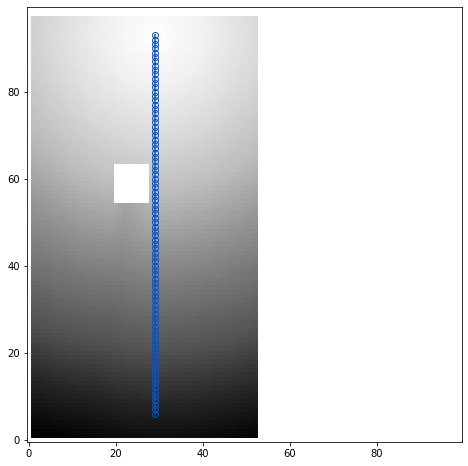

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.11818952113389969 vy:  0.488811194896698 v:  0.5028967559670655
vx:  0.005359806120395633 vy:  0.7942963242530822 v:  0.7943144076772154
vx:  -0.01871005073189727 vy:  0.9474307894706726 v:  0.9476155163542923
vx:  -0.005899866577237858 vy:  0.9999825954437257 v:  0.9999999998079996
vx:  -0.005899866577237858 vy:  0.9999825954437257 v:  0.9999999998079996
vx:  -0.005899866577237858 vy:  0.9999825954437257 v:  0.9999999998079996
vx:  -0.0044077374041081585 vy:  0.9999902844429017 v:  0.9999999985646095
vx:  -0.004407737869769279 vy:  0.9999902844429016 v:  0.9999999985666619
vx:  -0.0044077374041081585 vy:  0.9999902844429017 v:  0.9999999985646095
vx:  -0.004407737869769279 vy:  0.9999902844429016 v:  0.9999999985666619
vx:  -0.0044077374041081585 vy:  0.9999902844429017 v:  0.9999999985646095
vx:  -0.0032929729204625446 vy:  0.9999945759773254 v:  0.9999999978273628
vx:  0.011301770806312533 vy:  1.0029225349426272 v:  1.002986211829008
vx:  0

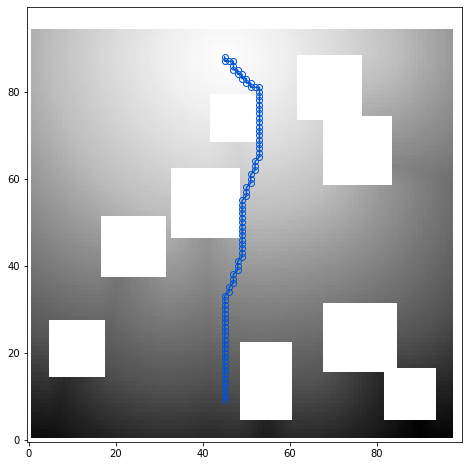

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.037492480129003525 vy:  0.06918135285377501 v:  0.07868764610091121
idx:  0
vx:  -0.034417010843753815 vy:  0.18910895287990573 v:  0.1922153133721491
idx:  0
vx:  0.02629960328340529 vy:  0.2584631145000458 v:  0.25979771109447497
vx:  0.13726812601089478 vy:  0.351413369178772 v:  0.3772716454441266
vx:  0.1484442055225371 vy:  0.5490525960922241 v:  0.5687657122478712
vx:  0.14114557206630704 vy:  0.6667534112930297 v:  0.681529297965111
vx:  0.12961798906326288 vy:  0.7261826992034912 v:  0.7376599051807495
vx:  0.11751273274421686 vy:  0.750402569770813 v:  0.7595480623868733
vx:  0.1050679385662078 vy:  0.7568566799163818 v:  0.7641147202145767
vx:  0.09348434954881671 vy:  0.7567620277404784 v:  0.7625143213346527
vx:  0.11502250283956522 vy:  0.7663349509239197 v:  0.7749189849055474
vx:  0.14970707893371582 vy:  0.779629349708557 v:  0.7938728691735556
vx:  0.18513019382953647 vy:  0.7871925830841064 v:  0.8086688763208274
vx:  0.21342

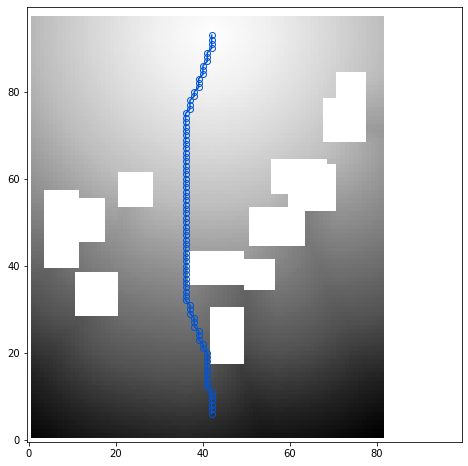

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.01756036467850207 vy:  0.5125713348388672 v:  0.5128720500340607
vx:  -0.12405297905206678 vy:  0.8309295773506165 v:  0.8401387409992273
vx:  0.0032147504389285764 vy:  0.9281197190284729 v:  0.9281252865157139
vx:  0.007245294284075443 vy:  0.9280970692634583 v:  0.9281253494354539
vx:  0.007245294284075443 vy:  0.9280970692634583 v:  0.9281253494354539
vx:  0.007245294284075443 vy:  0.9280970692634583 v:  0.9281253494354539
vx:  0.005428965669125374 vy:  0.9281094670295716 v:  0.9281253452299167
vx:  0.005428965669125374 vy:  0.9281094670295716 v:  0.9281253452299167
vx:  0.005428965669125374 vy:  0.9281094670295716 v:  0.9281253452299167
vx:  0.005849391222000233 vy:  0.9185930490493774 v:  0.9186116726558072
vx:  -0.2891385555267335 vy:  0.8818492889404298 v:  0.9280405555237484
vx:  -0.2671481966972351 vy:  0.8888466954231262 v:  0.928125318565977
vx:  -0.20233230292797091 vy:  0.9058026671409607 v:  0.9281254401253174
vx:  -0.20233230292

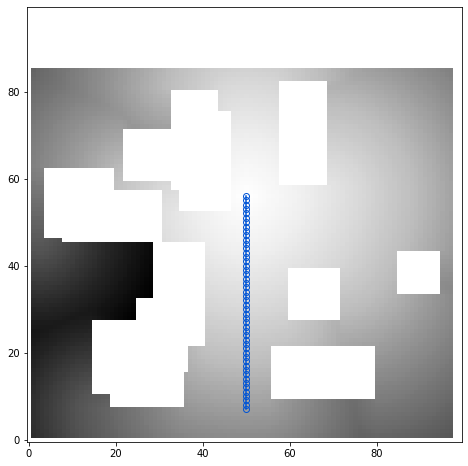

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.17777955532073972 vy:  0.24780692160129544 v:  0.3049817054899368
vx:  0.11772294342517857 vy:  0.40086326003074646 v:  0.41779186762210396
vx:  0.12361925095319753 vy:  0.5123368501663208 v:  0.5270396258770081
vx:  0.15390157699584955 vy:  0.6455951929092407 v:  0.6636858055656526
vx:  0.1370374113321304 vy:  0.6738812923431396 v:  0.6876737949599879
vx:  0.21039244532585144 vy:  0.7362749576568604 v:  0.7657452541954164
vx:  0.22694955766201022 vy:  0.8305515050888062 v:  0.8610005251614329
vx:  0.22301523387432093 vy:  0.8677219748497009 v:  0.8959225525552323
vx:  0.21488741040229803 vy:  0.884329617023468 v:  0.9100634432248552
vx:  0.20598903298377985 vy:  0.8834537863731384 v:  0.9071505246466144
vx:  0.19827829301357264 vy:  0.8652911782264708 v:  0.8877179194974777
vx:  0.1943180114030838 vy:  0.841732680797577 v:  0.8638711683337538
vx:  0.19167503714561457 vy:  0.8153285384178162 v:  0.8375559356982106
vx:  0.19005301594734197 vy:  0

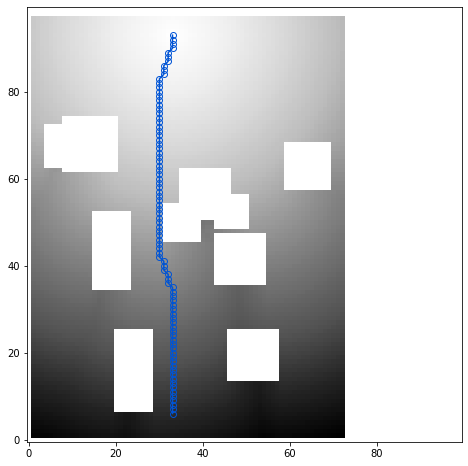

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.06238531321287161 vy:  0.5050557851791382 v:  0.5088941672367486
vx:  -0.0027082145679740988 vy:  0.8462967872619629 v:  0.8463011204979385
vx:  -0.0027082145679740988 vy:  0.8462967872619629 v:  0.8463011204979385
vx:  -0.0027082145679740988 vy:  0.8462967872619629 v:  0.8463011204979385
vx:  0.014609468169510531 vy:  0.8453550338745117 v:  0.8454812652313313
vx:  0.02038206346333038 vy:  0.8254756927490234 v:  0.8257272841746864
vx:  0.07219162583351146 vy:  0.8432164788246154 v:  0.8463011644809835
vx:  0.08538631349802012 vy:  0.8419826626777649 v:  0.8463011442640976
vx:  0.10159344971179968 vy:  0.8401812314987182 v:  0.8463012057105003
vx:  0.08803182095289236 vy:  0.8417101502418518 v:  0.8463011157504419
vx:  0.08803185075521464 vy:  0.8417101502418518 v:  0.8463011188504651
vx:  0.08803173154592525 vy:  0.8417102098464966 v:  0.846301165731684
vx:  0.08803176134824747 vy:  0.8417102098464966 v:  0.8463011688317038
vx:  0.0880318209528

vx:  -0.3414346873760223 vy:  -0.010744106024503541 v:  0.34160369078484476
vx:  -0.2731805741786957 vy:  -0.008513483218848816 v:  0.27331320038578355
vx:  -0.10393376648426056 vy:  -0.0032561817206441593 v:  0.10398476107104666
idx:  0
vx:  -0.12019580602645874 vy:  0.033122278749942766 v:  0.12467604876614836
idx:  0
vx:  -0.13648521900177002 vy:  0.03761113807559013 v:  0.1415726411186223
idx:  0
vx:  -0.14209531247615814 vy:  0.039157114923000315 v:  0.14739185010301648
idx:  0
vx:  -0.14209404587745664 vy:  0.039156779646873516 v:  0.14739053994791715
idx:  0
vx:  -0.13923995196819305 vy:  0.03837031126022341 v:  0.14443006961956065
idx:  0
vx:  -0.1350133866071701 vy:  0.0372055433690548 v:  0.14004594610528287
idx:  0
vx:  -0.13019129633903503 vy:  0.03587672486901286 v:  0.1350441151245225
idx:  0
vx:  -0.12517328560352325 vy:  0.03449397534132004 v:  0.12983907641241443
idx:  0
vx:  -0.12016095221042633 vy:  0.03311268612742424 v:  0.1246398989837912
idx:  0
vx:  0.0605700425

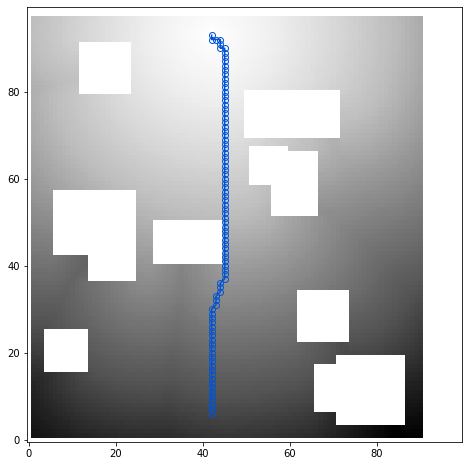

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.10592500865459442 vy:  0.530992329120636 v:  0.5414544865853765
vx:  -0.01630129665136333 vy:  0.8137272000312804 v:  0.8138904645855382
vx:  0.005765407346189022 vy:  0.9445267319679261 v:  0.9445443278766107
vx:  0.015694679692387636 vy:  0.9919563531875611 v:  0.9920805056041633
vx:  0.03170173615217202 vy:  0.9964069724082948 v:  0.9969111568935951
vx:  0.04522653669118874 vy:  0.9830988645553588 v:  0.9841386168173237
vx:  0.05998308956623072 vy:  0.9612505435943606 v:  0.963120230601748
vx:  0.0753240436315536 vy:  0.936330020427704 v:  0.939354894969496
vx:  0.09277407824993134 vy:  0.9014900922775269 v:  0.906251298520266
vx:  0.10933333635330192 vy:  0.8541069626808168 v:  0.8610763509341053
vx:  0.09585279971361159 vy:  0.824737012386322 v:  0.8302884431406076
vx:  0.10011227428913116 vy:  0.7902943491935731 v:  0.7966100839373272
vx:  0.10155726224184035 vy:  0.7624198794364929 v:  0.7691540483375319
vx:  0.1017020642757416 vy:  0.7

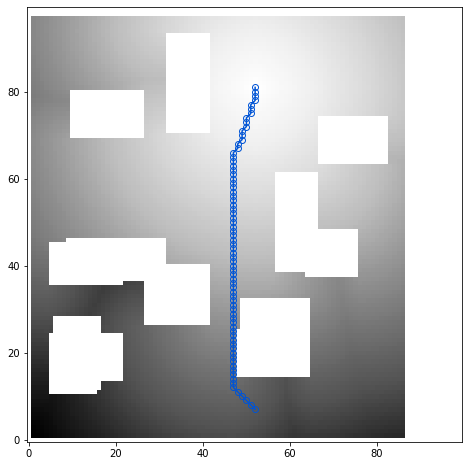

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.11622449755668639 vy:  0.2410052418708801 v:  0.26756617955478906
vx:  -0.008061025291681304 vy:  0.24895980954170227 v:  0.24909027860555658
idx:  0
vx:  -0.33277872204780584 vy:  0.239001452922821 v:  0.4097113280676899
vx:  -0.41777026653289806 vy:  0.4732851386070252 v:  0.631292973210727
vx:  -0.3846094012260437 vy:  0.5893078446388244 v:  0.7037102580354451
vx:  -0.31448808312416066 vy:  0.5657355785369873 v:  0.6472708082786437
vx:  -0.2887076139450073 vy:  0.5672891139984132 v:  0.6365288879626155
vx:  -0.27200278639793396 vy:  0.5599377155303955 v:  0.6225076393761271
vx:  -0.257100224494934 vy:  0.5432983636856079 v:  0.6010604274270638
vx:  -0.24493157863616938 vy:  0.5246713161468506 v:  0.5790263104561609
vx:  -0.2348843663930893 vy:  0.5061770081520081 v:  0.5580195598342419
vx:  -0.22548900544643394 vy:  0.487131267786026 v:  0.5367887514023024
vx:  -0.21646942198276528 vy:  0.4679582118988037 v:  0.5156005224367778
vx:  -0.207810

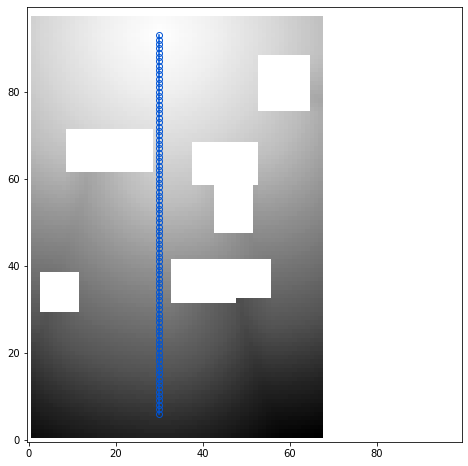

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.019932340830564554 vy:  0.5183760523796082 v:  0.518759125116515
vx:  -0.06006114184856426 vy:  0.7480056285858154 v:  0.7504130603582364
vx:  -0.02119297534227349 vy:  0.9923791885375977 v:  0.9926054584004659
vx:  0.0034564333036542494 vy:  0.9999940395355226 v:  1.0000000130188773
vx:  0.0034564333036542494 vy:  0.9999940395355226 v:  1.0000000130188773
vx:  0.0034564333036542494 vy:  0.9999940395355226 v:  1.0000000130188773
vx:  0.0025810061488296676 vy:  0.9999966621398927 v:  0.9999999929418335
vx:  0.0025810061488296676 vy:  0.9999966621398927 v:  0.9999999929418335
vx:  0.0025810061488296676 vy:  0.9999966621398927 v:  0.9999999929418335
vx:  -0.018118839710950796 vy:  0.9930713772773743 v:  0.9932366549418382
vx:  -0.0294408537447452 vy:  0.990995466709137 v:  0.9914326900537825
vx:  -0.03513156622648217 vy:  0.9892569184303285 v:  0.9898805370385839
vx:  -0.03794644400477415 vy:  0.9879068732261659 v:  0.9886353841432681
vx:  -0.0442

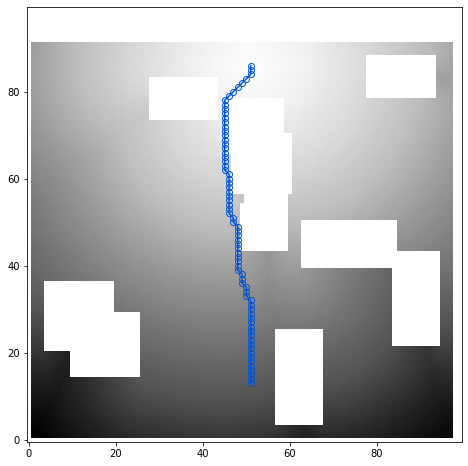

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1686037182807922 vy:  0.5307184457778931 v:  0.5568566085690383
vx:  -0.06668845564126966 vy:  0.6301825642585754 v:  0.6337013605881963
vx:  0.0101982280611993 vy:  0.8466353416442871 v:  0.8466967612886723
vx:  0.01584875583648676 vy:  0.9987848997116089 v:  0.9989106361199149
vx:  0.014620233327150345 vy:  0.9651474952697754 v:  0.9652582239214859
vx:  -0.010203690268099253 vy:  0.9271203875541687 v:  0.9271765356789824
vx:  -0.04000104218721395 vy:  0.9087587594985962 v:  0.9096387009914929
vx:  -0.08295752853155142 vy:  0.9520226716995239 v:  0.9556302208333319
vx:  -0.06948646903038014 vy:  0.9910826086997986 v:  0.9935155291415972
vx:  -0.06960572302341456 vy:  0.9927836656570435 v:  0.9952207611746494
vx:  -0.06828412413597112 vy:  0.9739336371421814 v:  0.9763244599855189
vx:  -0.06612859666347498 vy:  0.9431895017623901 v:  0.9455048532564316
vx:  -0.06364742666482925 vy:  0.9078004956245422 v:  0.9100289746910366
vx:  -0.061125952750

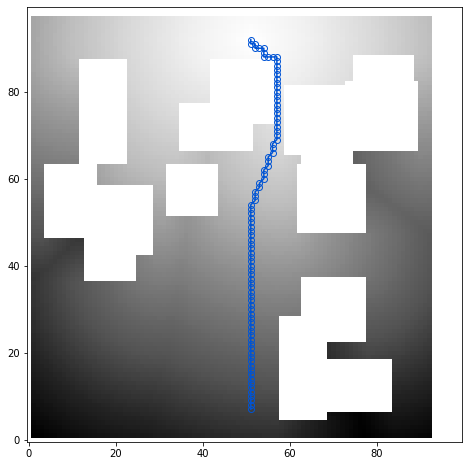

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.022889949381351415 vy:  0.5805794000625611 v:  0.5810304549330304
vx:  0.12026429176330564 vy:  0.6190452575683595 v:  0.6306191646241066
vx:  0.15062150359153736 vy:  0.941658616065979 v:  0.9536287467119845
vx:  0.08608348667621601 vy:  0.9620190858840943 v:  0.965862872401462
vx:  0.05158936232328412 vy:  0.9712793827056885 v:  0.9726484984690339
vx:  0.03288827836513525 vy:  0.9793733358383178 v:  0.9799253899174656
vx:  0.02231697365641583 vy:  0.9817501306533813 v:  0.9820037506807764
vx:  0.016524748876690754 vy:  0.9825145006179811 v:  0.9826534543011786
vx:  0.013239748775958932 vy:  0.9823632240295409 v:  0.9824524389879463
vx:  0.011256830766796982 vy:  0.9816421866416932 v:  0.9817067275075573
vx:  0.009930166415870162 vy:  0.9805095791816711 v:  0.9805598620543596
vx:  0.010697697289288044 vy:  0.9841792583465576 v:  0.9842373968138345
vx:  0.01011286489665511 vy:  0.983290195465088 v:  0.983342198084771
vx:  0.009593929164111642 v

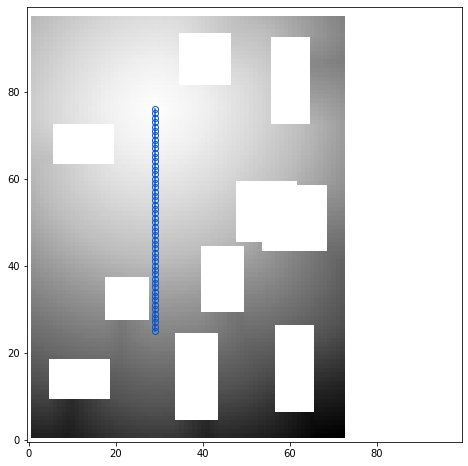

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.19162783026695251 vy:  0.27296575903892517 v:  0.33351391416328724
vx:  0.3678003549575805 vy:  0.7304428815841675 v:  0.8178165468880563
vx:  0.29604026675224315 vy:  0.8681157231330869 v:  0.9172048562287608
vx:  0.22845198214054102 vy:  0.8876844644546509 v:  0.9166100679013309
vx:  0.18588967621326452 vy:  0.897162675857544 v:  0.9162182265566107
vx:  0.1607768535614012 vy:  0.8994233012199401 v:  0.9136801800512471
vx:  0.14696955680847162 vy:  0.8965668082237244 v:  0.9085329340408939
vx:  0.14585082232952118 vy:  0.9048505425453186 v:  0.916529850424281
vx:  0.1443244218826295 vy:  0.8989623188972472 v:  0.9104739367762655
vx:  0.14510922133922577 vy:  0.8912491202354431 v:  0.9029848727626215
vx:  0.1469161957502364 vy:  0.8819871544837949 v:  0.8941396475093493
vx:  0.14891409873962402 vy:  0.8712520599365234 v:  0.8838866221111562
vx:  0.15061013400554651 vy:  0.8589503765106201 v:  0.8720545635296594
vx:  0.15168233215808868 vy:  0.8

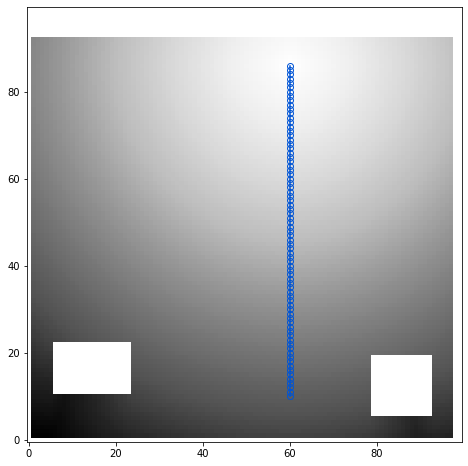

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.09491518139839174 vy:  0.2176399379968643 v:  0.2374363794180844
idx:  0
vx:  -0.1780590862035752 vy:  0.3370343446731567 v:  0.3811786820756329
vx:  0.026018664240836945 vy:  0.670089840888977 v:  0.6705947850613603
vx:  0.0936450436711312 vy:  0.8547300696372986 v:  0.8598446872234249
vx:  0.049640905112027935 vy:  0.9848578572273254 v:  0.9861081169946531
vx:  0.0050258543342353995 vy:  0.9981041550636292 v:  0.9981168085785701
vx:  -0.006517344620078802 vy:  0.99997878074646 v:  1.0000000188620366
vx:  -0.006517344620078802 vy:  0.99997878074646 v:  1.0000000188620366
vx:  -0.006517344620078802 vy:  0.99997878074646 v:  1.0000000188620366
vx:  -0.006517344620078802 vy:  0.99997878074646 v:  1.0000000188620366
vx:  -0.004343666136264648 vy:  0.9999905824661253 v:  1.0000000162282217
vx:  -0.004343666136264648 vy:  0.9999905824661253 v:  1.0000000162282217
vx:  -0.004343666136264648 vy:  0.9999905824661253 v:  1.0000000162282217
vx:  -0.00434

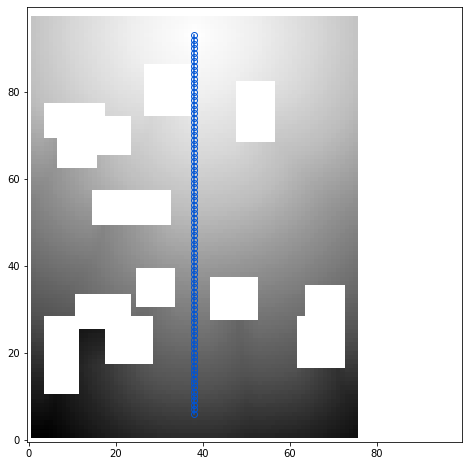

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.004938049241900527 vy:  0.7267853617668153 v:  0.7268021370420122
vx:  0.00025621303939271645 vy:  0.9999999403953552 v:  0.9999999732179174
vx:  0.00025621303939271645 vy:  0.9999999403953552 v:  0.9999999732179174
vx:  0.00025621303939271645 vy:  0.9999999403953552 v:  0.9999999732179174
vx:  0.00025621303939271645 vy:  0.9999999403953552 v:  0.9999999732179174
vx:  0.00025621303939271645 vy:  0.9999999403953552 v:  0.9999999732179174
vx:  0.00018974437261920496 vy:  0.9999999999999999 v:  1.0000000180014632
vx:  0.00018974437261920496 vy:  0.9999999999999999 v:  1.0000000180014632
vx:  0.00018974437261920496 vy:  0.9999999999999999 v:  1.0000000180014632
vx:  0.00018974437261920496 vy:  0.9999999999999999 v:  1.0000000180014632
vx:  0.00018974437261920496 vy:  0.9999999999999999 v:  1.0000000180014632
vx:  0.00014051947800897135 vy:  1.0 v:  1.0000000098728619
vx:  0.00014051947800897135 vy:  1.0 v:  1.0000000098728619
vx:  0.000140519478008

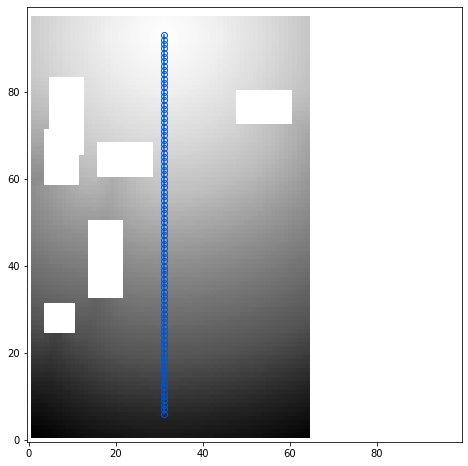

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.14818674325942988 vy:  0.75469172000885 v:  0.7691026609808034
vx:  0.14363165199756628 vy:  0.9612108469009398 v:  0.9718828857715172
vx:  0.09285825490951544 vy:  1.0536335706710815 v:  1.0577175221910307
vx:  0.09628780931234365 vy:  1.0533257722854614 v:  1.0577176016229162
vx:  0.09809069335460668 vy:  1.0531593561172483 v:  1.0577175490177348
vx:  0.09903981536626821 vy:  1.0530705451965332 v:  1.0577175701425727
vx:  0.0995408445596695 vy:  1.053023338317871 v:  1.0577176044567689
vx:  0.09980593621730804 vy:  1.0529981851577759 v:  1.0577175439831672
vx:  0.18673798441886907 vy:  0.9120445847511292 v:  0.9309653051530338
vx:  0.1928609907627104 vy:  0.9022151827812195 v:  0.9225982862540574
vx:  0.21361373364925385 vy:  0.8685746788978577 v:  0.8944567066248041
vx:  0.2306036949157714 vy:  0.8037031888961791 v:  0.8361320947976423
vx:  0.238181620836258 vy:  0.7563365697860719 v:  0.7929536501586638
vx:  0.2032701075077058 vy:  1.0380018

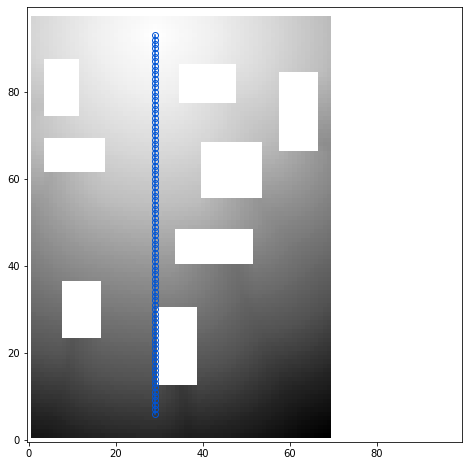

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1888062059879303 vy:  0.40211373567581177 v:  0.4442333168940769
vx:  0.021074950695037953 vy:  0.8671756386756897 v:  0.8674316929069336
vx:  0.008954520337283056 vy:  0.9999598860740662 v:  0.9999999785958649
vx:  0.008954520337283056 vy:  0.9999598860740662 v:  0.9999999785958649
vx:  0.008954520337283056 vy:  0.9999598860740662 v:  0.9999999785958649
vx:  0.008954520337283056 vy:  0.9999598860740662 v:  0.9999999785958649
vx:  0.006685473956167642 vy:  0.9999776482582092 v:  0.9999999962890187
vx:  0.006685473956167642 vy:  0.9999776482582092 v:  0.9999999962890187
vx:  0.006685473956167642 vy:  0.9999776482582092 v:  0.9999999962890187
vx:  0.006685473956167642 vy:  0.9999776482582092 v:  0.9999999962890187
vx:  0.006685473956167642 vy:  0.9999776482582092 v:  0.9999999962890187
vx:  0.004991366993635837 vy:  0.9999875426292419 v:  0.9999999995790675
vx:  0.004991366993635837 vy:  0.9999875426292419 v:  0.9999999995790675
vx:  0.0049913669

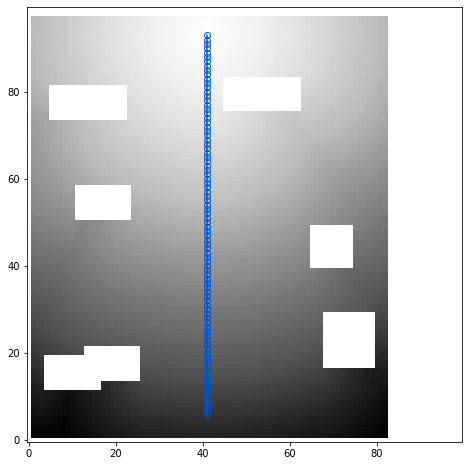

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.03484904766082769 vy:  0.5354250073432922 v:  0.536557913567055
vx:  0.014575429260730799 vy:  0.9037567377090454 v:  0.903874263430833
vx:  0.001030352083034869 vy:  0.943303644657135 v:  0.9433042073736603
vx:  0.001030352083034869 vy:  0.943303644657135 v:  0.9433042073736603
vx:  0.001030352083034869 vy:  0.943303644657135 v:  0.9433042073736603
vx:  0.001030352083034869 vy:  0.943303644657135 v:  0.9433042073736603
vx:  0.000769999460317139 vy:  0.9433039426803589 v:  0.9433042569476079
vx:  0.000769999460317139 vy:  0.9433039426803589 v:  0.9433042569476079
vx:  0.000769999460317139 vy:  0.9433039426803589 v:  0.9433042569476079
vx:  0.000769999460317139 vy:  0.9433039426803589 v:  0.9433042569476079
vx:  0.000769999460317139 vy:  0.9433039426803589 v:  0.9433042569476079
vx:  0.000769999460317139 vy:  0.9433039426803589 v:  0.9433042569476079
vx:  0.0005687216762452763 vy:  0.9433040022850037 v:  0.9433041737272507
vx:  0.00056872167624

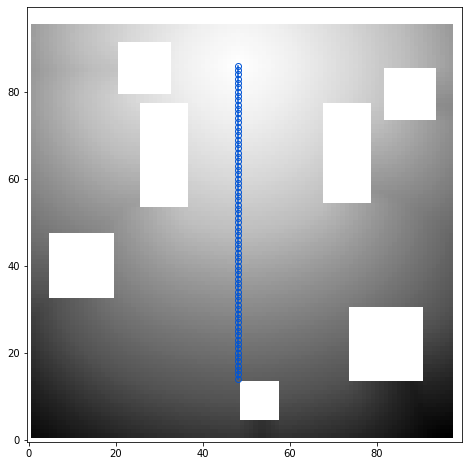

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.24844780564308175 vy:  0.3420763611793517 v:  0.4227795513108088
vx:  0.1256708800792694 vy:  0.473082810640335 v:  0.4894900569197062
vx:  0.11685402691364291 vy:  0.602769672870636 v:  0.6139919723730172
vx:  -0.012420222163200434 vy:  0.7424306869506836 v:  0.7425345694610098
vx:  -0.0010501295328138038 vy:  0.9463015198707581 v:  0.946302102545346
vx:  -0.030165243893861715 vy:  0.9523670077323914 v:  0.9528446144867089
vx:  -0.030165243893861715 vy:  0.9523670077323914 v:  0.9528446144867089
vx:  -0.030165245756506975 vy:  0.9523670077323914 v:  0.9528446145456767
vx:  -0.030165245756506975 vy:  0.9523670077323914 v:  0.9528446145456767
vx:  -0.02089825645089116 vy:  0.9526154398918152 v:  0.9528446428683764
vx:  -0.02089825645089116 vy:  0.9526154398918152 v:  0.9528446428683764
vx:  -0.02089825645089116 vy:  0.9526154398918152 v:  0.9528446428683764
vx:  -0.02089825645089116 vy:  0.9526154398918152 v:  0.9528446428683764
vx:  -0.02089825

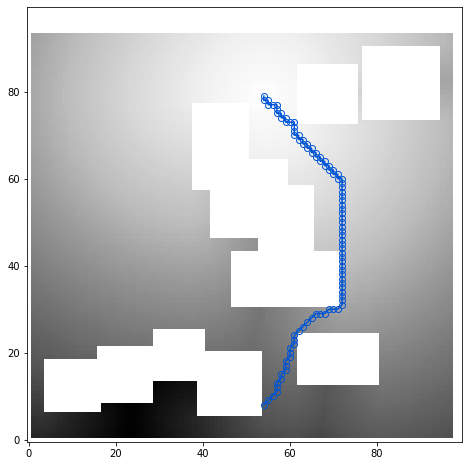

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.12528540194034576 vy:  0.2740398645401001 v:  0.3013208909062072
vx:  -0.016058817505836504 vy:  0.44745054841041565 v:  0.4477386278762058
vx:  0.11054304242134097 vy:  0.5491837859153748 v:  0.5601987102271038
vx:  0.09863522648811335 vy:  0.583876132965088 v:  0.5921488381738383
vx:  0.08571171760559082 vy:  0.5904554128646851 v:  0.5966440254591562
vx:  0.07191120833158499 vy:  0.580197036266327 v:  0.5846364877220187
vx:  0.0705494433641434 vy:  0.5661687254905702 v:  0.5705473246651912
vx:  0.05735012888908381 vy:  0.5365368723869324 v:  0.539593228936711
vx:  0.06729914993047718 vy:  0.5437930822372437 v:  0.5479416865602091
vx:  0.06903355568647389 vy:  0.5560030937194823 v:  0.5602723195343073
vx:  0.056986823678016704 vy:  0.5337629318237305 v:  0.536796391066458
vx:  0.04283977672457697 vy:  0.5124124884605409 v:  0.5142001602490371
vx:  0.025893028825521424 vy:  0.4919159114360809 v:  0.4925969070809818
vx:  0.010914217680692694 vy: 

vx:  0.8660601377487184 vy:  0.28909501433372503 v:  0.913036740503878
vx:  0.8552430868148804 vy:  0.2854841947555542 v:  0.9016329424992591
vx:  0.8424683809280396 vy:  0.2812199294567108 v:  0.8881653120828069


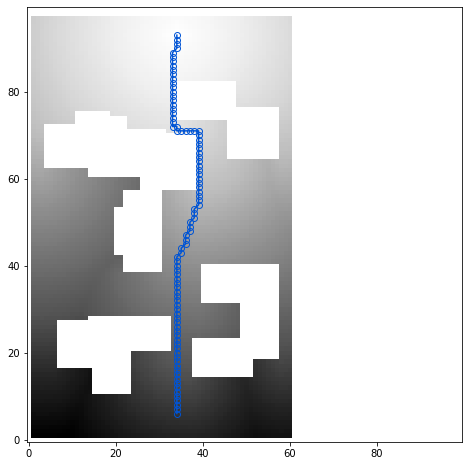

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.10294602066278462 vy:  0.3834678828716278 v:  0.3970459675709488
vx:  0.02188879996538158 vy:  0.6125329136848451 v:  0.6129238859036009
vx:  0.0364764779806136 vy:  0.8662310242652893 v:  0.8669986856077478
vx:  0.0021309861913323402 vy:  0.866996169090271 v:  0.8669987879572574
vx:  0.0021309861913323402 vy:  0.866996169090271 v:  0.8669987879572574
vx:  0.0021309861913323402 vy:  0.866996169090271 v:  0.8669987879572574
vx:  0.0021309861913323402 vy:  0.866996169090271 v:  0.8669987879572574
vx:  0.001589297782629645 vy:  0.866997241973877 v:  0.8669986986482455
vx:  0.001589297782629645 vy:  0.866997241973877 v:  0.8669986986482455
vx:  0.001589297782629645 vy:  0.866997241973877 v:  0.8669986986482455
vx:  0.001589297782629645 vy:  0.866997241973877 v:  0.8669986986482455
vx:  0.001589297782629645 vy:  0.866997241973877 v:  0.8669986986482455
vx:  0.001589297782629645 vy:  0.866997241973877 v:  0.8669986986482455
vx:  -0.00076071242801858

vx:  -0.061035934835672385 vy:  0.04076830297708512 v:  0.07339918166366607
idx:  0
vx:  -0.06119005009531975 vy:  0.039137572050094604 v:  0.07263588490989896
idx:  0
vx:  -0.061367575079202645 vy:  0.037572063505649574 v:  0.07195581440838633
idx:  0
vx:  -0.06178638711571693 vy:  0.036069191992282854 v:  0.07154400215104961
idx:  0
vx:  -0.06241349503397941 vy:  0.03462640196084976 v:  0.07137529036796217
idx:  0
vx:  -0.06310072541236879 vy:  0.03324136137962341 v:  0.07132103233926079
idx:  0
vx:  -0.06371092051267623 vy:  0.03191170096397401 v:  0.07125614395255084
idx:  0
vx:  -0.06422367691993713 vy:  0.030635230243206024 v:  0.07115615229318341
idx:  0
vx:  0.27445122599601746 vy:  0.0294098109006882 v:  0.2760224853665572
vx:  0.15840454399585724 vy:  0.03144196420907977 v:  0.16149488125591016
idx:  0
vx:  0.03422826901078224 vy:  0.006794035434722897 v:  0.03489603583450055
idx:  0
vx:  -0.02887100726366043 vy:  0.02670399099588395 v:  0.0393273212350725
idx:  0
vx:  -0.062

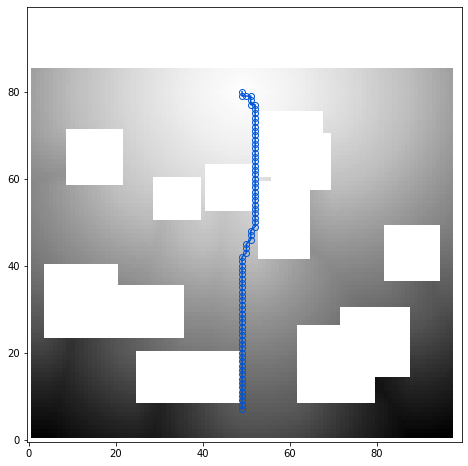

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.37745946645736694 vy:  0.34911447763443 v:  0.5141561701586795
vx:  0.14316251873970026 vy:  0.5677223801612854 v:  0.585494840035239
vx:  0.22229041159152982 vy:  0.707745909690857 v:  0.7418337413259595
vx:  0.19711725413799291 vy:  0.716066837310791 v:  0.7427024487472631
vx:  0.16749100387096408 vy:  0.729332447052002 v:  0.7483174825570792
vx:  0.15538197755813604 vy:  0.7538708448410035 v:  0.7697173569896716
vx:  0.13481689989566803 vy:  0.7632286548614501 v:  0.7750442413818046
vx:  0.11759444326162338 vy:  0.7685933113098145 v:  0.7775372217946845
vx:  0.10283673554658895 vy:  0.7707810401916504 v:  0.7776109606331444
vx:  0.09152337163686744 vy:  0.7723675370216369 v:  0.7777712644477486
vx:  0.07964174449443831 vy:  0.7874346375465393 v:  0.7914519037024089
vx:  0.0755009204149246 vy:  0.7903613448143005 v:  0.793959346793128
vx:  0.08196933567523956 vy:  0.7838259339332581 v:  0.7881002897457813
vx:  0.08628324419260025 vy:  0.765177

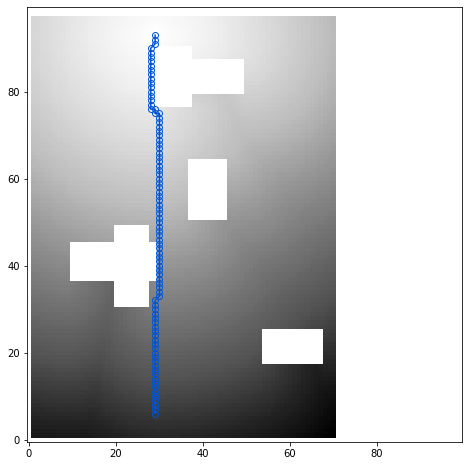

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.2109106928110122 vy:  0.6137131452560424 v:  0.6489430984316616
vx:  0.0145005583763122 vy:  0.8788604140281677 v:  0.8789800302276425
vx:  0.014372146688401644 vy:  0.9998967051506045 v:  0.9999999897857339
vx:  0.010304626077413559 vy:  0.999946892261505 v:  0.9999999863310185
vx:  0.010304626077413559 vy:  0.999946892261505 v:  0.9999999863310185
vx:  0.020191701129078865 vy:  0.9939385056495667 v:  0.9941435800765298
vx:  0.028917882591486033 vy:  0.999395489692688 v:  0.9998137770363352
vx:  0.02891707420349121 vy:  0.9993672370910643 v:  0.9997855128733951
vx:  0.02891479805111896 vy:  0.9992887377738952 v:  0.9997069805638458
vx:  0.028913749381899945 vy:  0.9992525577545166 v:  0.9996707853499885
vx:  0.028912495821714346 vy:  0.9992092847824096 v:  0.9996274942247312
vx:  0.028910979628562927 vy:  0.9991568326950072 v:  0.9995750202281977
vx:  0.02890967950224882 vy:  0.9991120100021362 v:  0.9995301786836811
vx:  0.028908107429742702 

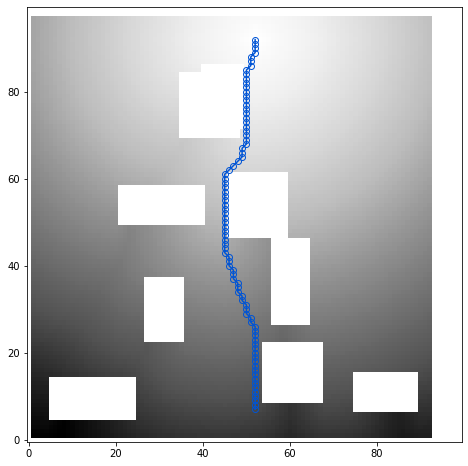

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.4051257371902466 vy:  0.5885800719261172 v:  0.7145301701135467
vx:  0.022410375997424237 vy:  0.966123938560486 v:  0.9663838210628175
vx:  0.022410375997424237 vy:  0.966123938560486 v:  0.9663838210628175
vx:  0.022410375997424237 vy:  0.966123938560486 v:  0.9663838210628175
vx:  0.022410375997424237 vy:  0.966123938560486 v:  0.9663838210628175
vx:  0.022410375997424237 vy:  0.966123938560486 v:  0.9663838210628175
vx:  0.016058376058936064 vy:  0.9662503004074096 v:  0.966383730450311
vx:  0.016058376058936064 vy:  0.9662503004074096 v:  0.966383730450311
vx:  0.016058376058936064 vy:  0.9662503004074096 v:  0.966383730450311
vx:  0.016058376058936064 vy:  0.9662503004074096 v:  0.966383730450311
vx:  0.016058376058936064 vy:  0.9662503004074096 v:  0.966383730450311
vx:  0.016058376058936064 vy:  0.9662503004074096 v:  0.966383730450311
vx:  0.011290410533547401 vy:  0.9663177132606506 v:  0.9663836693215118
vx:  0.011683151125908064 vy

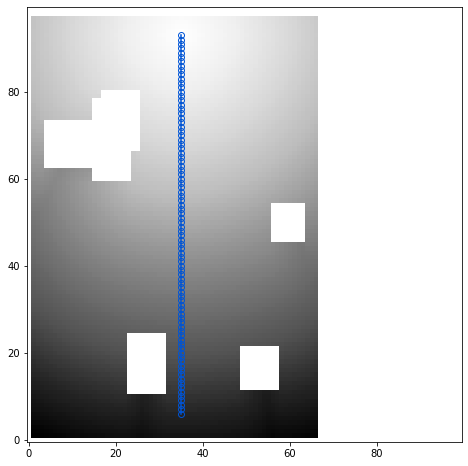

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.1433065086603164 vy:  0.40413296222686773 v:  0.42878923328678886
vx:  0.1818423718214035 vy:  0.70558100938797 v:  0.7286365410810661
vx:  0.03515529632568354 vy:  0.7359591722488403 v:  0.7367983428842283
vx:  -0.0895839929580689 vy:  0.7975836396217346 v:  0.802598874897395
vx:  -0.1185329928994179 vy:  0.884994387626648 v:  0.8928970469972219
vx:  -0.08279573917388909 vy:  0.9705560207366943 v:  0.9740811690067709
vx:  -0.06419254094362266 vy:  1.0149198770523074 v:  1.016947903851849
vx:  -0.06024501845240583 vy:  1.0150851011276247 v:  1.0168712921405594
vx:  -0.05811004340648644 vy:  1.0154144763946533 v:  1.017075875250481
vx:  -0.05687469244003305 vy:  1.0160275697708132 v:  1.0176181765154027
vx:  -0.05609915405511863 vy:  1.0168399810791016 v:  1.0183863030337001
vx:  -0.055550545454025275 vy:  1.0178167819976809 v:  1.0193315774645433
vx:  -0.06123866513371467 vy:  0.9945898056030273 v:  0.996473308983651
vx:  -0.0823432207107545 vy:

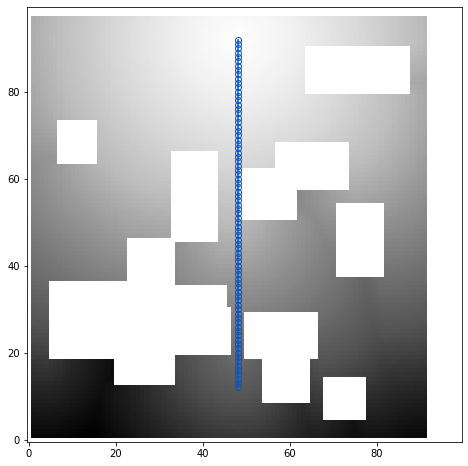

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.013656236231327029 vy:  0.27287957072257996 v:  0.2732210696592511
vx:  0.0436509698629379 vy:  0.595635175704956 v:  0.5972325089167945
vx:  -0.0034482725895942368 vy:  0.9273553490638733 v:  0.927361760059811
vx:  -0.0034482725895942368 vy:  0.9273553490638733 v:  0.927361760059811
vx:  -0.0034482725895942368 vy:  0.9273553490638733 v:  0.927361760059811
vx:  -0.0034482725895942368 vy:  0.9273553490638733 v:  0.927361760059811
vx:  -0.0034482725895942368 vy:  0.9273553490638733 v:  0.927361760059811
vx:  -0.0023553292267024517 vy:  0.9273588061332703 v:  0.9273617971906598
vx:  -0.0023553292267024517 vy:  0.9273588061332703 v:  0.9273617971906598
vx:  -0.0023553292267024517 vy:  0.9273588061332703 v:  0.9273617971906598
vx:  -0.0023553292267024517 vy:  0.9273588061332703 v:  0.9273617971906598
vx:  -0.0023553292267024517 vy:  0.9273588061332703 v:  0.9273617971906598
vx:  -0.0016255967784671865 vy:  0.9273603558540344 v:  0.927361780630735
vx

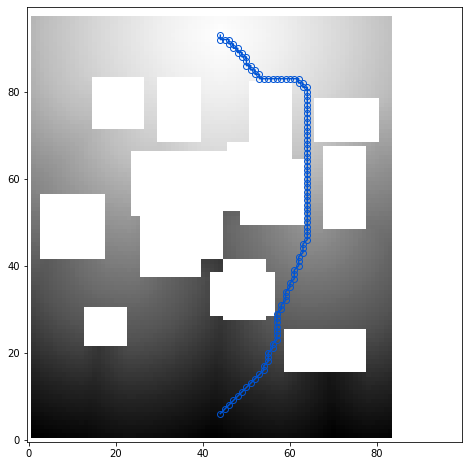

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.05942741036415096 vy:  0.5817895531654358 v:  0.5848168100140647
vx:  0.3227661252021791 vy:  0.7149339318275453 v:  0.7844160238396599
vx:  0.42902809381484996 vy:  0.8136510848999023 v:  0.9198332420831462
vx:  0.42344072461128257 vy:  0.8243963718414307 v:  0.926785533532242
vx:  0.42344072461128257 vy:  0.8243963718414307 v:  0.926785533532242
vx:  0.42344072461128257 vy:  0.8243963718414307 v:  0.926785533532242
vx:  0.42344072461128257 vy:  0.8243963718414307 v:  0.926785533532242
vx:  0.41260349750518815 vy:  0.8298732042312622 v:  0.9267854019429611
vx:  0.4126034677028657 vy:  0.8298732042312622 v:  0.9267853886750115
vx:  0.4126034677028657 vy:  0.8298732042312622 v:  0.9267853886750115
vx:  0.4126034379005432 vy:  0.8298732042312623 v:  0.9267853754070625
vx:  0.41260346770286555 vy:  0.829873263835907 v:  0.9267854420469123
vx:  0.4126034379005432 vy:  0.8298732042312623 v:  0.9267853754070625
vx:  0.4126034080982207 vy:  0.829873204

vx:  -0.17993998527526855 vy:  0.010837182402610814 v:  0.18026603347078818
idx:  0
vx:  -0.3015371561050415 vy:  0.010403700172901147 v:  0.3017165780814899
vx:  -0.00644928216934204 vy:  0.0002281051129102709 v:  0.006453314841407397
idx:  0
vx:  0.411832183599472 vy:  0.009978421032428662 v:  0.41195305112914216
vx:  0.07436811923980713 vy:  0.005960702896118171 v:  0.07460661591495732
idx:  0
vx:  -0.17788197100162506 vy:  0.009340852499008189 v:  0.17812705334348067
idx:  0
vx:  -0.3004599213600159 vy:  0.008967228233814257 v:  0.3005937050669296
vx:  -0.0018003284931182861 vy:  5.4909847676754106e-05 v:  0.0018011656710323577
idx:  0
vx:  0.41154396533966064 vy:  0.008606329560279964 v:  0.411633944562389
vx:  0.05348241329193115 vy:  0.00372053682804108 v:  0.05361166781417776
idx:  0
vx:  -0.18796910345554357 vy:  0.008113257586955996 v:  0.188144117108543
idx:  0
vx:  -0.30495530366897583 vy:  0.007788732647895855 v:  0.3050547517939979
vx:  0.008025586605072021 vy:  -0.000213

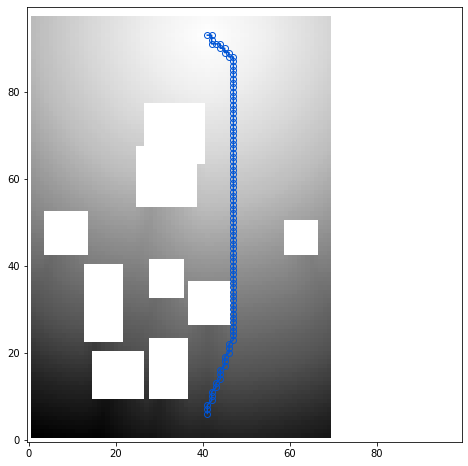

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.3261257410049438 vy:  0.614578664302826 v:  0.6957477513885829
vx:  -0.013645713217556282 vy:  0.811122477054596 v:  0.8112372515315105
vx:  -0.013645713217556282 vy:  0.811122477054596 v:  0.8112372515315105
vx:  0.22282549738883964 vy:  0.7800349593162538 v:  0.8112371663342931
vx:  0.23027448356151567 vy:  0.7778684496879577 v:  0.8112371187263742
vx:  0.23685418069362624 vy:  0.775890350341797 v:  0.8112371654858802
vx:  0.23685418069362624 vy:  0.775890350341797 v:  0.8112371654858802
vx:  0.2368541955947877 vy:  0.7758903503417968 v:  0.8112371698365219
vx:  0.23685419559478735 vy:  0.775890290737152 v:  0.8112371128289411
vx:  0.2368541955947877 vy:  0.7758903503417968 v:  0.8112371698365219
vx:  0.23685421049594862 vy:  0.7758903503417969 v:  0.8112371741871642
vx:  0.2368541955947877 vy:  0.7758903503417968 v:  0.8112371698365219
vx:  0.2368541955947877 vy:  0.7758903503417968 v:  0.8112371698365219
vx:  0.23685422539710999 vy:  0.77589

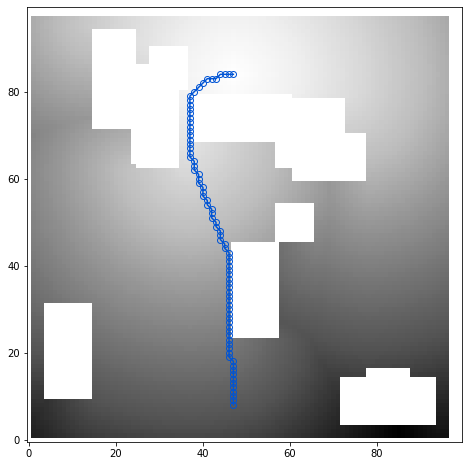

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.12674520909786222 vy:  0.4405670464038849 v:  0.4584361137675605
vx:  -0.16069993376731873 vy:  0.8233583569526672 v:  0.8388941844336605
vx:  0.01614703983068455 vy:  0.9426689147949219 v:  0.9428071965231966
vx:  0.01614703983068455 vy:  0.9426689147949219 v:  0.9428071965231966
vx:  0.01614703983068455 vy:  0.9426689147949219 v:  0.9428071965231966
vx:  0.01614703983068455 vy:  0.9426689147949219 v:  0.9428071965231966
vx:  0.01614703983068455 vy:  0.9426689147949219 v:  0.9428071965231966
vx:  0.023602187633514293 vy:  0.9425116181373596 v:  0.9428070924558171
vx:  0.02265810221433623 vy:  0.9425348043441771 v:  0.9428071101747544
vx:  0.02208560518920427 vy:  0.942548394203186 v:  0.9428071114345595
vx:  0.022085616365075056 vy:  0.942548394203186 v:  0.9428071116963586
vx:  0.022085607051849365 vy:  0.942548394203186 v:  0.9428071114781927
vx:  0.02208560518920427 vy:  0.942548394203186 v:  0.9428071114345595
vx:  0.02208561077713972 vy: 

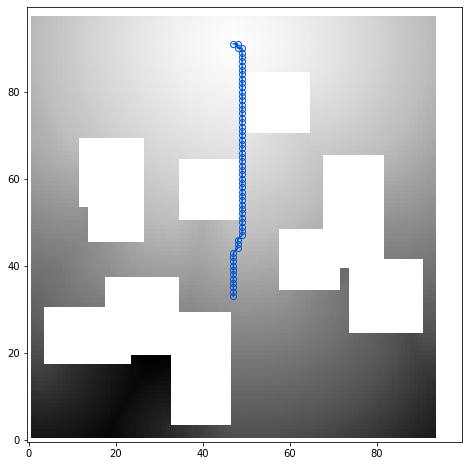

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.2820871472358703 vy:  0.2707552015781403 v:  0.3910006877452915
vx:  -0.24985291063785556 vy:  0.43719786405563354 v:  0.5035558055360065
vx:  -0.20413908362388614 vy:  0.5346016287803651 v:  0.5722514018833149
vx:  -0.27241939306259166 vy:  0.513217568397522 v:  0.5810375187786551
vx:  -0.28458568453788763 vy:  0.504141092300415 v:  0.5789190381994305
vx:  -0.4990566372871398 vy:  0.6719243526458741 v:  0.8369825941433459
vx:  -0.40337368845939636 vy:  0.6819513440132141 v:  0.7923180978260986
vx:  -0.4261126518249513 vy:  0.7203942537307739 v:  0.8369826000901159
vx:  -0.42611265182495134 vy:  0.7203943133354187 v:  0.8369826513920713
vx:  -0.42611259222030634 vy:  0.7203942537307739 v:  0.8369825697450501
vx:  -0.42611259222030634 vy:  0.7203942537307739 v:  0.8369825697450501
vx:  -0.42611259222030634 vy:  0.7203942537307739 v:  0.8369825697450501
vx:  -0.4261126518249513 vy:  0.7203942537307739 v:  0.8369826000901159
vx:  -0.4261125922203

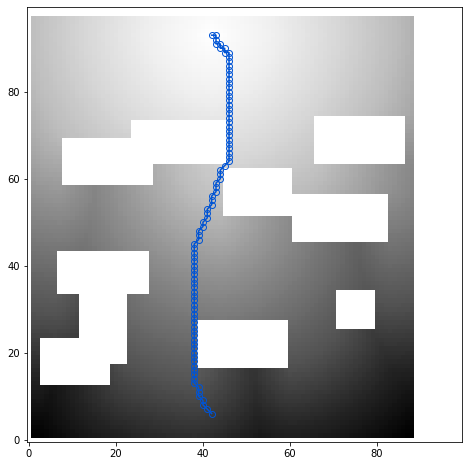

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  5.551115123125783e-17 vy:  0.42876553535461426 v:  0.42876553535461426
vx:  0.0 vy:  0.4116150140762329 v:  0.4116150140762329
vx:  5.551115123125783e-17 vy:  0.39515039324760437 v:  0.39515039324760437
vx:  2.7755575615628914e-17 vy:  0.3793444037437439 v:  0.3793444037437439
vx:  2.7755575615628914e-17 vy:  0.3641705811023712 v:  0.3641705811023712
vx:  5.551115123125783e-17 vy:  0.3496037721633911 v:  0.3496037721633911
vx:  0.0 vy:  0.33561956882476807 v:  0.33561956882476807
vx:  2.7755575615628914e-17 vy:  0.32219478487968445 v:  0.32219478487968445
vx:  2.7755575615628914e-17 vy:  0.3093070387840271 v:  0.3093070387840271
vx:  2.7755575615628914e-17 vy:  0.29693472385406494 v:  0.29693472385406494
vx:  -5.551115123125783e-17 vy:  0.28505739569664 v:  0.28505739569664
vx:  -3.885780586188048e-16 vy:  0.27365505695343023 v:  0.27365505695343023
vx:  -3.3029134982598407e-15 vy:  0.2627088725566864 v:  0.2627088725566864
vx:  -2.887967642806188

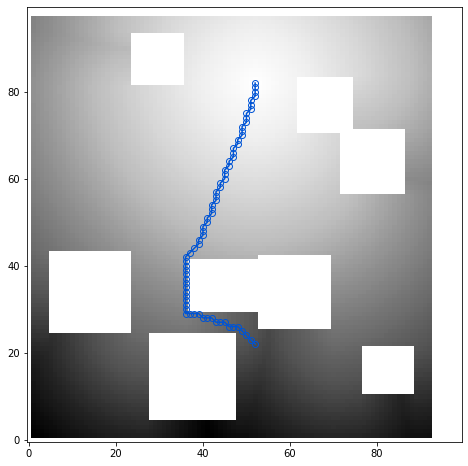

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.17276282608509064 vy:  0.22385470569133756 v:  0.28276832095739196
vx:  -0.8131532073020934 vy:  0.2149004787206653 v:  0.8410709567569506
vx:  -0.785586416721344 vy:  0.47048211097717274 v:  0.9156961476858019
vx:  -0.7855863571166993 vy:  0.4704821705818174 v:  0.915696127174984
vx:  -0.7559058070182801 vy:  0.45270660519599887 v:  0.8810998010850096
vx:  -0.7256695628166198 vy:  0.43459853529930126 v:  0.8458558986510422
vx:  -0.6966428160667419 vy:  0.41721442341804504 v:  0.8120216057996562
vx:  -0.6687770485877991 vy:  0.4005259871482849 v:  0.7795407667972956
vx:  -0.6420260071754459 vy:  0.38450488448142983 v:  0.7483591384353661
vx:  -0.6163449883460999 vy:  0.36912474036216736 v:  0.7184248176439838
vx:  -0.5916911959648132 vy:  0.3543597757816316 v:  0.6896878439368634
vx:  -0.5680235028266907 vy:  0.3401852548122407 v:  0.6621002245545402
vx:  -0.5453025698661804 vy:  0.32657787203788735 v:  0.6356162357959836
vx:  -0.52349048852920

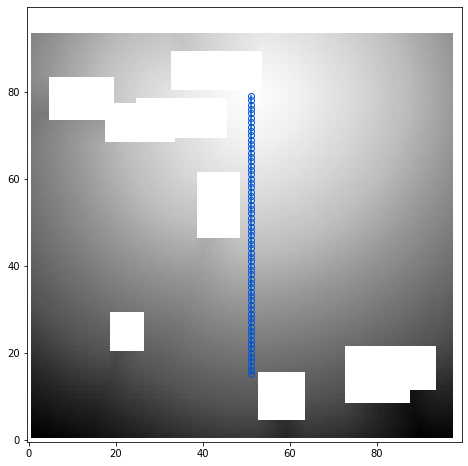

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.14103959500789634 vy:  0.5086197853088379 v:  0.5278127067129019
vx:  -0.2806767523288729 vy:  0.7859957814216614 v:  0.8346069779905578
vx:  -0.24415643513202667 vy:  0.8489401340484619 v:  0.8833525434471788
vx:  -0.22022755444049824 vy:  0.8554597496986389 v:  0.8833524546234649
vx:  -0.20266705751419056 vy:  0.8597893118858336 v:  0.8833524761014572
vx:  -0.19374927878379794 vy:  0.8618427515029907 v:  0.8833525408054747
vx:  -0.18914793431758875 vy:  0.8628642559051514 v:  0.8833525146708767
vx:  -0.18675270676612826 vy:  0.8633858561515809 v:  0.8833525400920483
vx:  -0.18707275390625017 vy:  0.8623552322387695 v:  0.8824130335753494
vx:  -0.22832359373569489 vy:  0.8278610706329346 v:  0.8587698269768748
vx:  -0.26813760399818415 vy:  0.7947465181350708 v:  0.8387608734113111
vx:  -0.3041307032108309 vy:  0.7648907899856566 v:  0.8231363223916172
vx:  -0.3085147142410279 vy:  0.7612091302871704 v:  0.8213529502812865
vx:  -0.32117122411

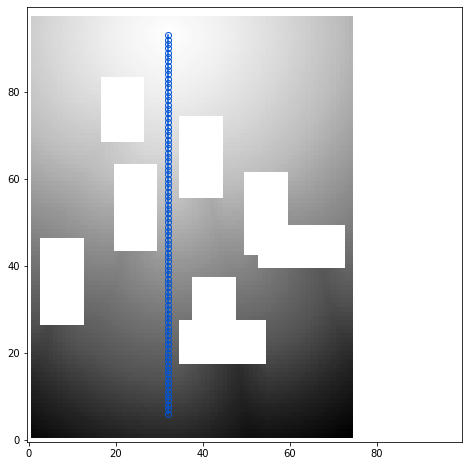

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.08121460676193243 vy:  0.6023744940757751 v:  0.6078246815197137
vx:  0.005399160087108612 vy:  0.9719432592391967 v:  0.9719582553330973
vx:  0.004008474759757574 vy:  0.9741930365562439 v:  0.9742012832800903
vx:  0.004008474759757574 vy:  0.9741930365562439 v:  0.9742012832800903
vx:  -0.0013316799886525787 vy:  0.9742003083229065 v:  0.9742012184903271
vx:  -0.031236028298735563 vy:  0.9737004041671752 v:  0.9742012967242446
vx:  -0.037431843578815516 vy:  0.9734818935394286 v:  0.9742012830841583
vx:  -0.039023131132125854 vy:  0.9734193682670593 v:  0.9742012478337296
vx:  -0.03902310132980358 vy:  0.9734193682670593 v:  0.9742012466399522
vx:  -0.03902311623096444 vy:  0.9734193682670592 v:  0.9742012472368407
vx:  -0.03902308642864255 vy:  0.9734193682670593 v:  0.9742012460430638
vx:  -0.039023131132125854 vy:  0.9734193682670593 v:  0.9742012478337296
vx:  -0.03902310505509371 vy:  0.9734194278717041 v:  0.9742013063459813
vx:  -0.03

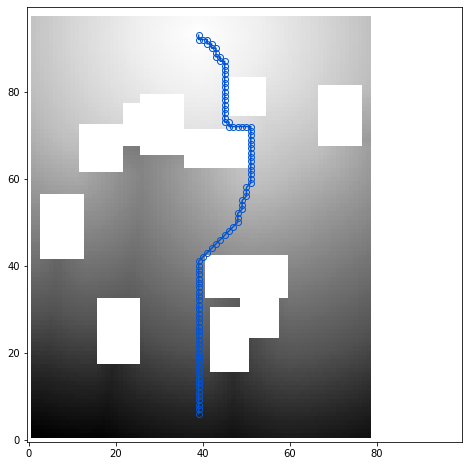

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.16516330838203427 vy:  0.5945991277694702 v:  0.6171118546745912
vx:  0.008510895073413849 vy:  0.9999637603759766 v:  0.9999999787001068
vx:  0.008510895073413849 vy:  0.9999637603759766 v:  0.9999999787001068
vx:  0.008510895073413849 vy:  0.9999637603759766 v:  0.9999999787001068
vx:  0.008510895073413849 vy:  0.9999637603759766 v:  0.9999999787001068
vx:  0.008510895073413849 vy:  0.9999637603759766 v:  0.9999999787001068
vx:  0.0063180988654494286 vy:  0.9999800324440004 v:  0.9999999918299888
vx:  0.0063180988654494286 vy:  0.9999800324440004 v:  0.9999999918299888
vx:  0.0063180988654494286 vy:  0.9999800324440004 v:  0.9999999918299888
vx:  0.0063180988654494286 vy:  0.9999800324440004 v:  0.9999999918299888
vx:  0.0063180988654494286 vy:  0.9999800324440004 v:  0.9999999918299888
vx:  0.004690241534262896 vy:  0.9999889731407166 v:  0.9999999723843369
vx:  0.004690241534262896 vy:  0.9999889731407166 v:  0.9999999723843369
vx:  0.00469

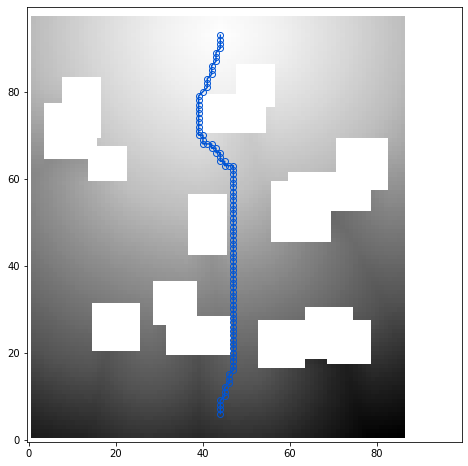

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.04111747816205018 vy:  0.37703835964202875 v:  0.3792737423708086
vx:  0.0025562345981597623 vy:  0.5096266269683839 v:  0.5096330378326087
vx:  0.002475738525390625 vy:  0.48924148082733154 v:  0.4892477448526118
vx:  0.0023919343948364535 vy:  0.46967184543609614 v:  0.46967793619191583
vx:  0.002305150032043485 vy:  0.4508849382400513 v:  0.4508908307433243
vx:  0.0022157728672027865 vy:  0.4328495264053345 v:  0.4328551976801496
vx:  0.0015572905540466309 vy:  0.4155355989933014 v:  0.41553851708907985
vx:  0.0015076100826263428 vy:  0.39891418814659124 v:  0.3989170369798904
vx:  0.0014570355415344377 vy:  0.3829576075077057 v:  0.38296037928302096
vx:  0.0014057457447052002 vy:  0.36763930320739746 v:  0.3676419907789635
vx:  0.0013539791107177734 vy:  0.3529337346553803 v:  0.3529363318181151
vx:  0.0013018846511840543 vy:  0.33881640434265137 v:  0.3388189055459096
vx:  0.0012496411800384383 vy:  0.32526373863220215 v:  0.32526613914159

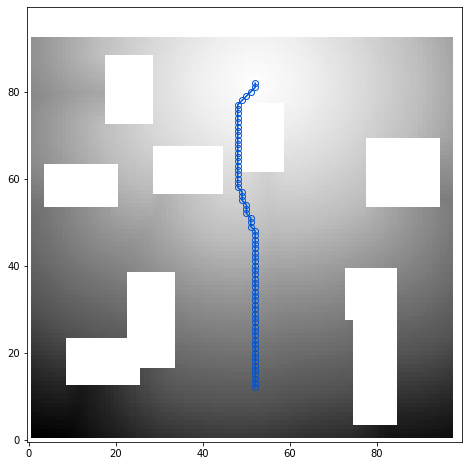

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.33179923892021174 vy:  0.09542316198349 v:  0.34524819303069365
vx:  0.02581853978335856 vy:  0.2420729398727417 v:  0.24344589792226298
idx:  0
vx:  0.21436190605163574 vy:  0.33231320977211 v:  0.39545302648371866
vx:  0.23258218169212352 vy:  0.35209140181541443 v:  0.4219749121369795
vx:  0.2166404128074647 vy:  0.35385364294052124 v:  0.41490416855421763
vx:  0.20171289145946503 vy:  0.3526714146137237 v:  0.4062821892066928
vx:  0.18740586936473846 vy:  0.34990590810775757 v:  0.39693211560803177
vx:  0.1735231131315232 vy:  0.3462997078895568 v:  0.38734191417305686
vx:  0.16115346550941478 vy:  0.33631703257560724 v:  0.37293375530535744
vx:  0.14971360564231884 vy:  0.32128739356994623 v:  0.3544569832594546
vx:  0.16469410061836248 vy:  0.31245204806327814 v:  0.35320026771992735
vx:  0.1561976671218872 vy:  0.293878436088562 v:  0.3328096248791175
vx:  0.14699521660804743 vy:  0.27398273348808283 v:  0.3109246403153803
vx:  0.136540

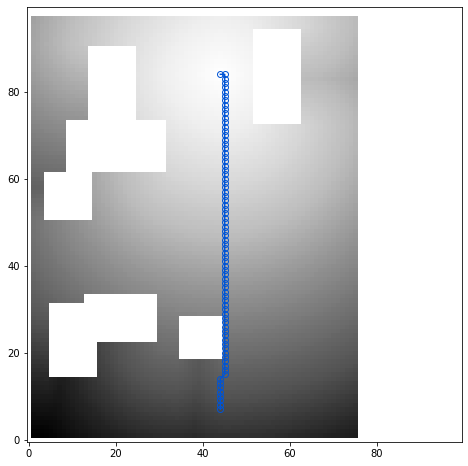

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.05825907364487659 vy:  0.43384510278701777 v:  0.437739297840892
vx:  0.15247973799705483 vy:  0.6750731468200686 v:  0.6920793480932662
vx:  0.05821631848812147 vy:  0.861705720424652 v:  0.8636700112605965
vx:  0.0645982027053834 vy:  0.9561692476272583 v:  0.9583488706628933
vx:  0.15717795491218595 vy:  0.9164247512817382 v:  0.9298060197009765
vx:  0.053937342017888495 vy:  0.9483979940414428 v:  0.9499305195464494
vx:  0.051051825284958156 vy:  0.8976609110832214 v:  0.8991114503506699
vx:  0.051467098295688164 vy:  0.9049621224403381 v:  0.9064244619706043
vx:  0.05205366760492295 vy:  0.9152771234512329 v:  0.9167561273448284
vx:  0.05209971219301224 vy:  0.9160866141319274 v:  0.9175669264976225
vx:  0.05212372541427591 vy:  0.9165083169937133 v:  0.9179893125029897
vx:  0.05213625356554981 vy:  0.9167284369468689 v:  0.9182097886882391
vx:  0.052142769098281604 vy:  0.9168435335159302 v:  0.9183250695256083
vx:  0.052146125584840955 vy

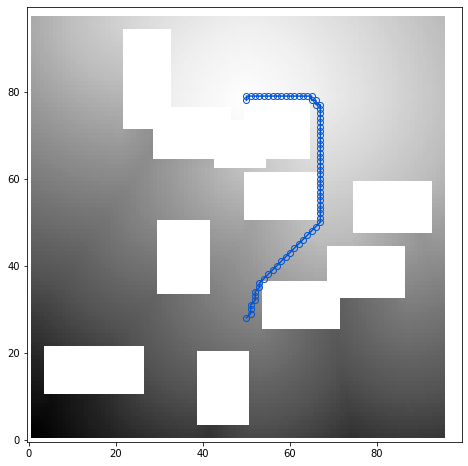

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.09801743924617773 vy:  0.4485282003879547 v:  0.4591132376000886
vx:  0.2767229080200194 vy:  0.7745235562324524 v:  0.8224732864853551
vx:  0.2817862033843994 vy:  0.7503395080566406 v:  0.8015066074390625
vx:  0.5048239827156067 vy:  0.720326066017151 v:  0.8796117864766206
vx:  0.4801746308803558 vy:  0.6851541996002197 v:  0.8366623891217435
vx:  0.4639648795127869 vy:  0.6620246767997742 v:  0.8084182593887649
vx:  0.44438490271568293 vy:  0.6340864300727845 v:  0.7743019711740861
vx:  0.4274236857891083 vy:  0.6098845601081848 v:  0.7447484030408528
vx:  0.4102725684642792 vy:  0.5854118466377258 v:  0.7148640504446064
vx:  0.39414489269256586 vy:  0.5623996853828431 v:  0.6867631342423348
vx:  0.3785068988800049 vy:  0.5400861501693726 v:  0.659515369119274
vx:  0.3635321259498596 vy:  0.5187185406684877 v:  0.633422869046319
vx:  0.443471521139145 vy:  0.526854395866394 v:  0.6886527023872121
vx:  0.4947310090065001 vy:  0.6395114660263

vx:  -0.0005417497013695547 vy:  0.015117354691028595 v:  0.015127058722478017
idx:  0
vx:  -0.0006034186226315796 vy:  0.014533758163452148 v:  0.014546279262679188
idx:  0
vx:  -0.0006661086226813495 vy:  0.013976731337606907 v:  0.013992595169619301
idx:  0
vx:  -0.0007078272756189099 vy:  0.013432386331260204 v:  0.013451023083926964
idx:  0
vx:  -0.0007576831849291912 vy:  0.01291666831821203 v:  0.012938871830705597
idx:  0
vx:  -0.0007806969806551951 vy:  0.012408093549311163 v:  0.012432629380145676
idx:  0
vx:  -0.0008202115423046052 vy:  0.011931097134947777 v:  0.011959256909093004
idx:  0
vx:  -0.0008319943444803348 vy:  0.011458816006779669 v:  0.011488980758382235
idx:  0
vx:  -0.0008591467048972862 vy:  0.011015638709068298 v:  0.011049091783004599
idx:  0
vx:  -0.0008616164559498429 vy:  0.010577224195003511 v:  0.010612259636313619
idx:  0
vx:  -0.0008825466502457857 vy:  0.010168079286813736 v:  0.010206308097093218
idx:  0
vx:  -0.0008715607691556224 vy:  0.009757855

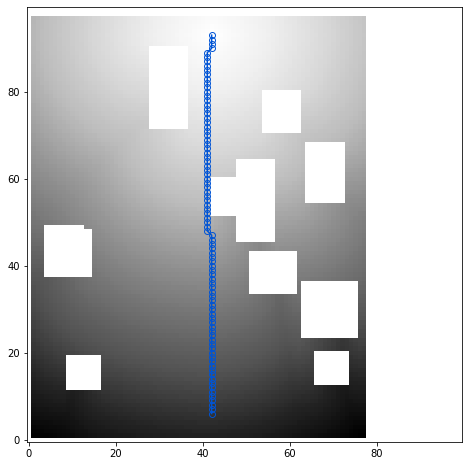

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.203796923160553 vy:  0.5449059009552002 v:  0.5817693931322847
vx:  -0.010474672541022356 vy:  0.9999451637268068 v:  1.0000000246127356
vx:  -0.010474672541022356 vy:  0.9999451637268068 v:  1.0000000246127356
vx:  -0.010474672541022356 vy:  0.9999451637268068 v:  1.0000000246127356
vx:  -0.010474672541022356 vy:  0.9999451637268068 v:  1.0000000246127356
vx:  -0.010474672541022356 vy:  0.9999451637268068 v:  1.0000000246127356
vx:  -0.007782889064401499 vy:  0.9999697208404542 v:  1.0000000079799622
vx:  -0.007782889064401499 vy:  0.9999697208404542 v:  1.0000000079799622
vx:  -0.007782889064401499 vy:  0.9999697208404542 v:  1.0000000079799622
vx:  -0.007782889064401499 vy:  0.9999697208404542 v:  1.0000000079799622
vx:  -0.007782889064401499 vy:  0.9999697208404542 v:  1.0000000079799622
vx:  -0.005782792344689369 vy:  0.9999832510948182 v:  0.9999999715787317
vx:  -0.005782792344689369 vy:  0.9999832510948182 v:  0.9999999715787317
vx:  -0.

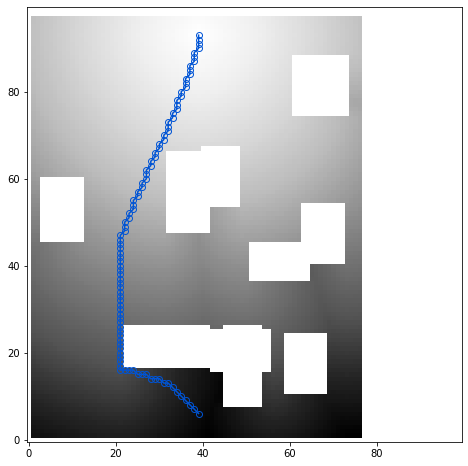

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.3162277638912201 vy:  0.4890608191490173 v:  0.582392035902234
vx:  -0.7112804055213927 vy:  0.46949845552444447 v:  0.8522608843649435
vx:  -0.7135555744171143 vy:  0.5454074144363401 v:  0.8981262748098797
vx:  -0.7135556936264038 vy:  0.5454072356224061 v:  0.8981262609321325
vx:  -0.7135556936264038 vy:  0.5454072952270506 v:  0.8981262971283857
vx:  -0.7135556340217591 vy:  0.5454072952270508 v:  0.8981262497728713
vx:  -0.713555634021759 vy:  0.5454073548316954 v:  0.8981262859691289
vx:  -0.7135555744171143 vy:  0.5454074144363401 v:  0.8981262748098797
vx:  -0.7135556936264038 vy:  0.5454072952270506 v:  0.8981262971283857
vx:  -0.7135556936264037 vy:  0.5454073548316957 v:  0.8981263333246416
vx:  -0.7135556936264037 vy:  0.5454073548316957 v:  0.8981263333246416
vx:  -0.7135556936264038 vy:  0.5454072952270506 v:  0.8981262971283857
vx:  -0.7135556936264037 vy:  0.5454073548316957 v:  0.8981263333246416
vx:  -0.7050012350082397 vy:  

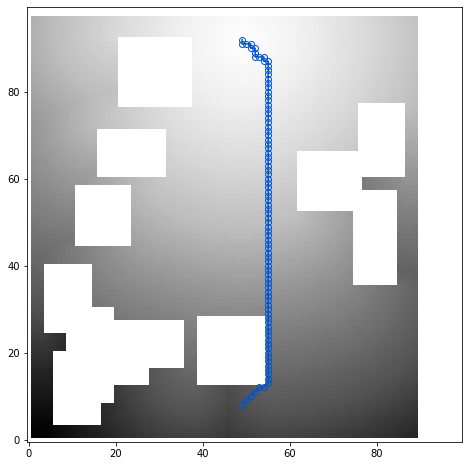

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  6.938893903907228e-18 vy:  0.1688232123851776 v:  0.1688232123851776
idx:  0
vx:  -0.3982136249542236 vy:  0.16207036375999453 v:  0.4299312664932384
vx:  -0.39875635504722595 vy:  0.2227246165275573 v:  0.4567415959794956
vx:  -0.37021827697753906 vy:  0.20678465068340293 v:  0.4240536102504904
vx:  -0.342358261346817 vy:  0.19122348725795751 v:  0.3921423226221695
vx:  -0.31544351577758784 vy:  0.17619031667709345 v:  0.3613137685404471
vx:  -0.28969174623489374 vy:  0.16180676221847534 v:  0.33181732344205345
vx:  -0.2652674019336701 vy:  0.14816454052925104 v:  0.3038412835657514
vx:  -0.4186780452728271 vy:  0.23385170102119454 v:  0.479560135607602
vx:  -0.520191729068756 vy:  0.223398894071579 v:  0.5661329356820239
vx:  -0.5636385679244996 vy:  0.2249285578727721 v:  0.606861838805758
vx:  -0.5387421250343323 vy:  0.21593138575553905 v:  0.5804045491213999
vx:  -0.5123661756515503 vy:  0.2072940468788147 v:  0.5527114254501996
vx:  -0.4846

vx:  3.1054034479896346e-05 vy:  0.013771499507129192 v:  0.013771534519722814
idx:  0
vx:  2.9809772968289634e-05 vy:  0.01319560222327709 v:  0.013195635894397803
idx:  0
vx:  2.861768007279093e-05 vy:  0.012643770314753054 v:  0.012643802701080212
idx:  0
vx:  2.7477741241458548e-05 vy:  0.012115036137402056 v:  0.012115067298072324
idx:  0
vx:  2.6382505893703372e-05 vy:  0.011608430184423923 v:  0.011608460164176026
idx:  0
vx:  2.5309622287744606e-05 vy:  0.011122974567115305 v:  0.011123003362297176
idx:  0
vx:  2.4303793907166395e-05 vy:  0.010657800361514091 v:  0.01065782807237423
idx:  0
vx:  2.3327782400881132e-05 vy:  0.010212088003754616 v:  0.010212114647900339
idx:  0
vx:  2.2396445274348257e-05 vy:  0.009785037487745285 v:  0.009785063118720363
idx:  0
vx:  2.149492502212004e-05 vy:  0.009375842288136484 v:  0.009375866927586487
idx:  0
vx:  2.063065767288338e-05 vy:  0.008983732201159 v:  0.008983755889725475
idx:  0
vx:  1.982600952032997e-05 vy:  0.00860803481191396

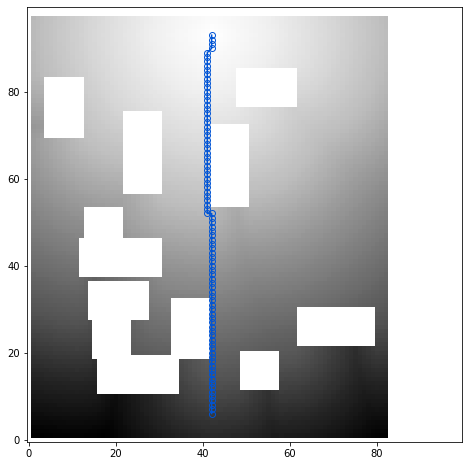

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.05345274507999426 vy:  0.5723780393600464 v:  0.574868520531641
vx:  0.11900283396244044 vy:  0.9598335027694702 v:  0.967182520277224
vx:  -0.003245718777179718 vy:  0.9771586656570435 v:  0.9771640561129099
vx:  -0.0032398807816205744 vy:  0.9771586656570435 v:  0.9771640367390384
vx:  -0.0032398733310404215 vy:  0.9771586656570433 v:  0.9771640367143352
vx:  -0.0032398728653787456 vy:  0.9771587252616882 v:  0.9771640963171085
vx:  -0.0032398728653788567 vy:  0.977158784866333 v:  0.9771641559214257
vx:  -0.003239871701225583 vy:  0.9771587252616882 v:  0.9771640963132486
vx:  -0.003239878686144948 vy:  0.9771587252616882 v:  0.9771640963364078
vx:  -0.0032398798502981663 vy:  0.977158784866333 v:  0.9771641559445848
vx:  -0.0032398714683951058 vy:  0.9771587252616882 v:  0.9771640963124767
vx:  -0.0032398798502981663 vy:  0.977158784866333 v:  0.9771641559445848
vx:  -0.0032398705370724756 vy:  0.977158784866333 v:  0.977164155913706
vx:  -

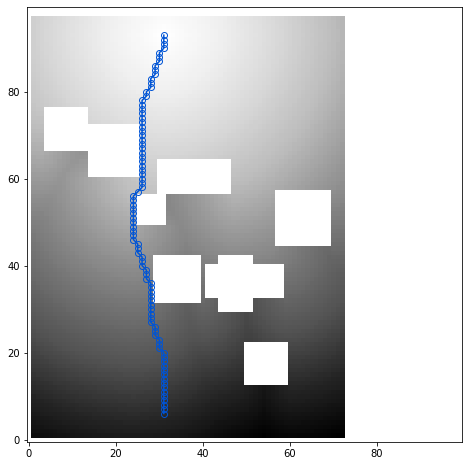

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  5.551115123125783e-17 vy:  0.9427878856658934 v:  0.9427878856658934
vx:  5.551115123125783e-17 vy:  0.9427878856658934 v:  0.9427878856658934
vx:  5.551115123125783e-17 vy:  0.9427878856658934 v:  0.9427878856658934


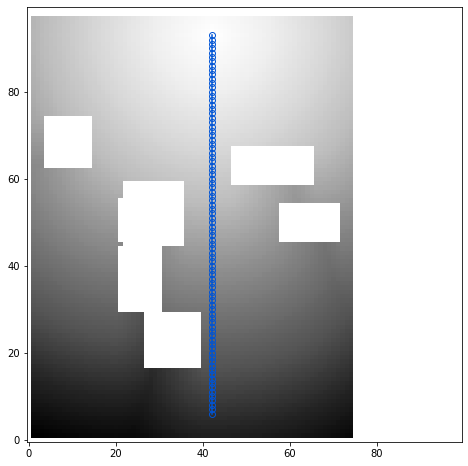

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.06660097837448123 vy:  0.47127485275268555 v:  0.4759576421883607
vx:  0.005465973168611693 vy:  0.8286722898483276 v:  0.8286903165991206
vx:  0.003441632958129104 vy:  0.9979450106620789 v:  0.9979509452587112
vx:  0.003441632958129104 vy:  0.9979450106620789 v:  0.9979509452587112
vx:  0.003441632958129104 vy:  0.9979450106620789 v:  0.9979509452587112
vx:  0.003441632958129104 vy:  0.9979450106620789 v:  0.9979509452587112
vx:  0.0025231407489628155 vy:  0.9979478716850281 v:  0.9979510613451525
vx:  0.0025231407489628155 vy:  0.9979478716850281 v:  0.9979510613451525
vx:  0.0025231407489628155 vy:  0.9979478716850281 v:  0.9979510613451525
vx:  0.0025231407489628155 vy:  0.9979478716850281 v:  0.9979510613451525
vx:  0.0025231407489628155 vy:  0.9979478716850281 v:  0.9979510613451525
vx:  0.0018501390004528884 vy:  0.9979492425918579 v:  0.9979509576146435
vx:  0.0018501390004528884 vy:  0.9979492425918579 v:  0.9979509576146435
vx:  0.0

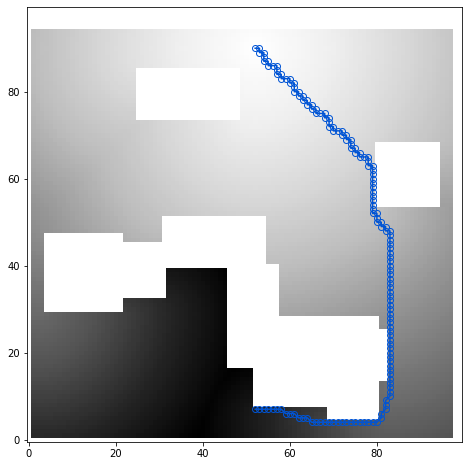

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.2582663297653199 vy:  -0.10253503173589701 v:  0.27787574529550135
vx:  0.6044330596923828 vy:  -0.09843356162309652 v:  0.6123956969990102
vx:  0.8706300258636475 vy:  -0.07559388875961323 v:  0.8739056459098637
vx:  0.8720566630363465 vy:  -0.05681812018156046 v:  0.8739056712981409
vx:  0.8720566034317018 vy:  -0.05681814998388274 v:  0.8739056137572452
vx:  0.8720566630363464 vy:  -0.05681803449988343 v:  0.8739056657274387
vx:  0.8720566630363464 vy:  -0.056818075478076935 v:  0.8739056683916865
vx:  0.8720567226409913 vy:  -0.05681811273097995 v:  0.8739057302922651
vx:  0.8720566034317017 vy:  -0.05681817233562472 v:  0.8739056152104739
vx:  0.8720566630363464 vy:  -0.056817993521690174 v:  0.8739056630631928
vx:  0.8720566034317018 vy:  -0.05681804567575466 v:  0.873905606975518
vx:  0.8720566034317017 vy:  -0.05681810155510883 v:  0.8739056106085844
vx:  0.8720566630363464 vy:  -0.056818183511495424 v:  0.8739056754156217
vx:  0.872056

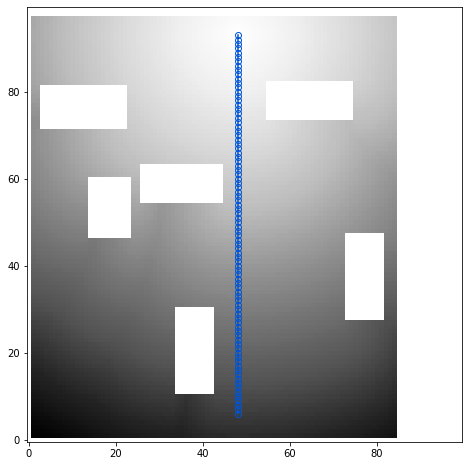

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.19479276239871984 vy:  0.5759063363075256 v:  0.6079575054903763
vx:  0.14822018146514873 vy:  0.7100254893302917 v:  0.7253312468743379
vx:  -0.016496056690812 vy:  0.8481055498123169 v:  0.8482659627197114
vx:  -0.016496056690812 vy:  0.8481055498123169 v:  0.8482659627197114
vx:  -0.016496056690812 vy:  0.8481055498123169 v:  0.8482659627197114
vx:  -0.016496056690812 vy:  0.8481055498123169 v:  0.8482659627197114
vx:  -0.016496056690812 vy:  0.8481055498123169 v:  0.8482659627197114
vx:  -0.012013201601803247 vy:  0.8481810092926025 v:  0.8482660794452077
vx:  -0.012013201601803247 vy:  0.8481810092926025 v:  0.8482660794452077
vx:  -0.012013201601803247 vy:  0.8481810092926025 v:  0.8482660794452077
vx:  -0.012013201601803247 vy:  0.8481810092926025 v:  0.8482660794452077
vx:  -0.012013201601803247 vy:  0.8481810092926025 v:  0.8482660794452077
vx:  -0.012013201601803247 vy:  0.8481810092926025 v:  0.8482660794452077
vx:  -0.00873231980949

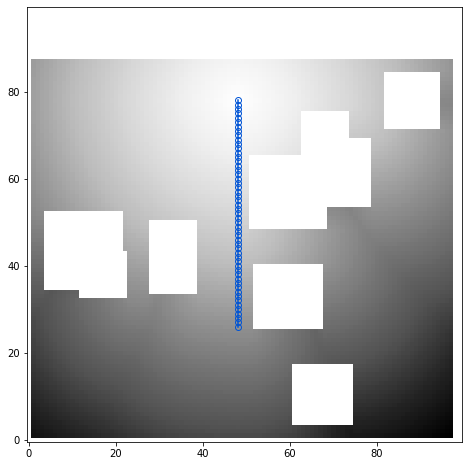

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.037343800067901556 vy:  0.4081995487213135 v:  0.40990417292313014
vx:  0.021387079730630087 vy:  0.6256822347640991 v:  0.6260476547985797
vx:  -0.17039947211742396 vy:  0.7774295806884766 v:  0.7958848742295316
vx:  -0.17421852052211728 vy:  0.9185976386070251 v:  0.9349725742220026
vx:  -0.1463528722524643 vy:  0.9253014922142029 v:  0.9368041496013864
vx:  -0.1305792778730392 vy:  0.9264043569564819 v:  0.9355618527910365
vx:  -0.12350209802389117 vy:  0.929831862449646 v:  0.9379979001271166
vx:  -0.11798555403947808 vy:  0.9276804327964783 v:  0.9351532368309826
vx:  -0.11406075209379202 vy:  0.9243084192276001 v:  0.9313194452083702
vx:  -0.110836312174797 vy:  0.919965386390686 v:  0.9266180444247097
vx:  -0.10870832949876791 vy:  0.9142941832542419 v:  0.9207341388451685
vx:  -0.1074394211173057 vy:  0.9071568250656128 v:  0.9134969810968969
vx:  -0.10674259811639775 vy:  0.8983676433563231 v:  0.9046869098656355
vx:  -0.106333509087562

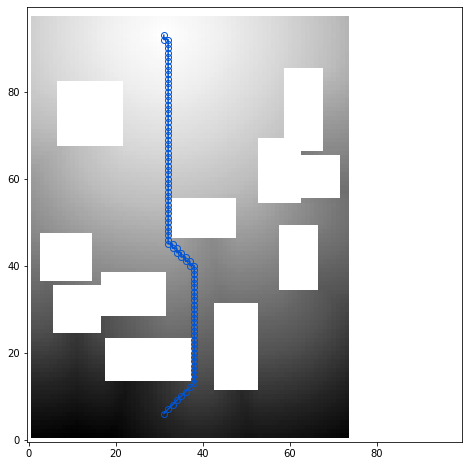

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.24253562092781072 vy:  0.361142635345459 v:  0.43502589633618577
vx:  0.4886132776737211 vy:  0.5878440141677856 v:  0.7643974882951622
vx:  0.4718966484069826 vy:  0.7435802221298216 v:  0.8806804150884576
vx:  0.45302075147628795 vy:  0.7138370275497435 v:  0.8454531939552857
vx:  0.4348999857902529 vy:  0.6852838993072509 v:  0.8116353986181927
vx:  0.4175039529800411 vy:  0.6578723192214967 v:  0.7791697755636002
vx:  0.400803804397583 vy:  0.631557285785675 v:  0.7480028708825553
vx:  0.3847716450691221 vy:  0.6062950491905214 v:  0.7180827985143045
vx:  0.3693807721138002 vy:  0.5820434093475342 v:  0.6893596196270045
vx:  0.35460552573204035 vy:  0.5587615966796874 v:  0.6617851621211603
vx:  0.34042128920555104 vy:  0.536410927772522 v:  0.6353135742120951
vx:  0.3268044590950015 vy:  0.5149545669555662 v:  0.6099011071581779
vx:  0.31373229622840865 vy:  0.49435660243034374 v:  0.5855052553677234
vx:  0.3011829853057862 vy:  0.474581897

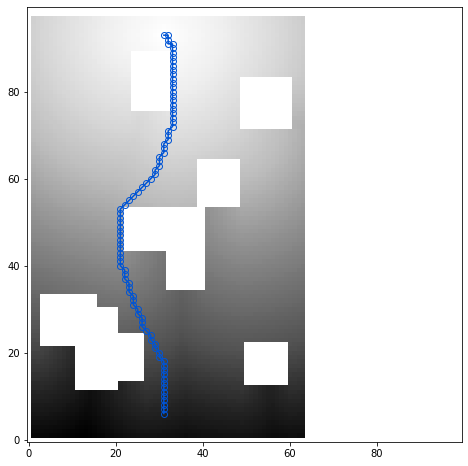

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.21699951589107513 vy:  0.5722832083702087 v:  0.6120431851425687
vx:  -0.009670142084360012 vy:  0.8657566905021667 v:  0.8658106945500248
vx:  -0.009670142084360012 vy:  0.8657566905021667 v:  0.8658106945500248
vx:  -0.009670142084360012 vy:  0.8657566905021667 v:  0.8658106945500248
vx:  -0.009670142084360012 vy:  0.8657566905021667 v:  0.8658106945500248
vx:  -0.009670142084360012 vy:  0.8657566905021667 v:  0.8658106945500248
vx:  -0.009670142084360012 vy:  0.8657566905021667 v:  0.8658106945500248
vx:  -0.22430996596813196 vy:  0.8362494707107545 v:  0.8658106825955901
vx:  -0.22430996596813196 vy:  0.8362494707107545 v:  0.8658106825955901
vx:  -0.22430996596813196 vy:  0.8362494707107545 v:  0.8658106825955901
vx:  -0.22430996596813196 vy:  0.8362494707107545 v:  0.8658106825955901
vx:  -0.22430996596813196 vy:  0.8362494707107545 v:  0.8658106825955901
vx:  -0.22430996596813196 vy:  0.8362494707107545 v:  0.8658106825955901
vx:  -0.168

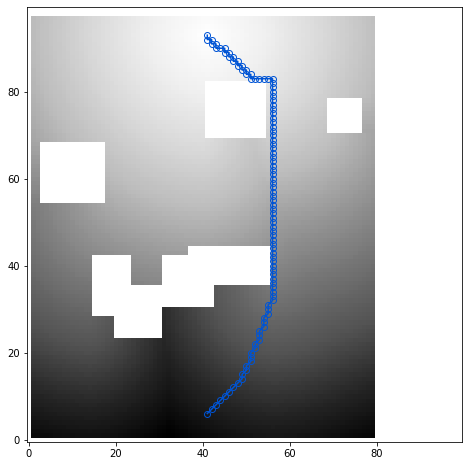

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.2134575545787813 vy:  0.8501157164573669 v:  0.8765049109814363
vx:  0.42979869246482827 vy:  0.8410115838050842 v:  0.9444720218930851
vx:  0.42979869246482827 vy:  0.8410115838050842 v:  0.9444720218930851
vx:  0.42979869246482827 vy:  0.8410115838050842 v:  0.9444720218930851
vx:  0.42979869246482827 vy:  0.8410115838050842 v:  0.9444720218930851
vx:  0.42979869246482827 vy:  0.8410115838050842 v:  0.9444720218930851
vx:  0.33775332570075967 vy:  0.8820148706436158 v:  0.9444720964953903
vx:  0.33775332570075967 vy:  0.8820148706436158 v:  0.9444720964953903
vx:  0.33775332570075967 vy:  0.8820148706436158 v:  0.9444720964953903
vx:  0.33775332570075967 vy:  0.8820148706436158 v:  0.9444720964953903
vx:  0.33775332570075967 vy:  0.8820148706436158 v:  0.9444720964953903
vx:  0.35725909471511846 vy:  0.8742958903312683 v:  0.9444720030825747
vx:  0.27355623245239247 vy:  0.8393240571022034 v:  0.8827785028782985
vx:  0.4807144403457644 vy:  0.

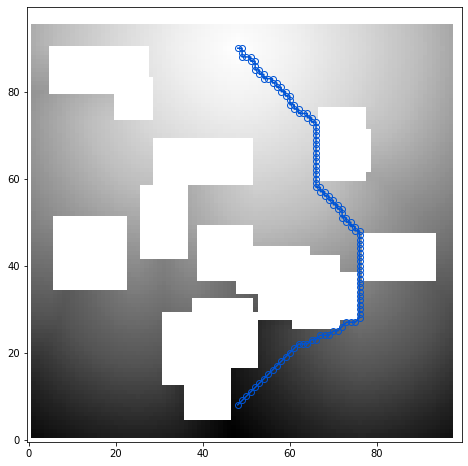

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.4535886645317077 vy:  0.1712030321359635 v:  0.4848228076361567
vx:  0.5887393951416017 vy:  0.5584322810173035 v:  0.8114559063029165
vx:  0.5855638384819031 vy:  0.5383527874946594 v:  0.795429904354199
vx:  0.5766270756721498 vy:  0.5168186426162719 v:  0.7743386169848052
vx:  0.5663078427314759 vy:  0.4961459934711455 v:  0.7529046550371754
vx:  0.55450576543808 vy:  0.4763000905513761 v:  0.7309845553521087
vx:  0.5897171497344972 vy:  0.46209278702735895 v:  0.7491969437428929
vx:  0.745483696460724 vy:  0.5187643170356749 v:  0.9082193338165815
vx:  0.7947925925254824 vy:  0.600081205368042 v:  0.9958879044196388
vx:  0.7578794956207277 vy:  0.5722112655639646 v:  0.9496352259265884
vx:  0.7530581951141357 vy:  0.5685710310935975 v:  0.9435940136665749
vx:  0.7473856210708617 vy:  0.5642882585525515 v:  0.9364862547436289
vx:  0.7406699657440184 vy:  0.5592176914215088 v:  0.9280713466938021
vx:  0.7904963493347169 vy:  0.596837401390075

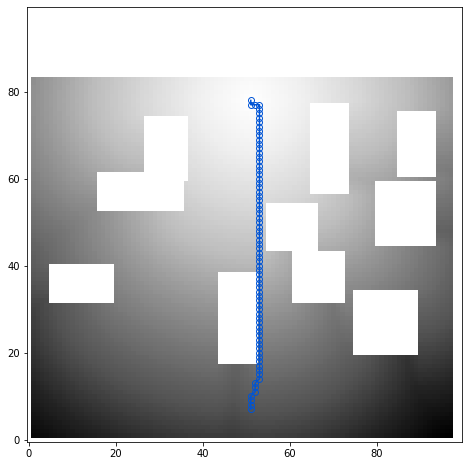

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.3003076016902923 vy:  0.20147141814231878 v:  0.36162879857839353
vx:  0.10439416766166693 vy:  0.46792358160018926 v:  0.4794273880988874
vx:  0.07301568239927292 vy:  0.6864646673202515 v:  0.6903368955483511
vx:  0.08443668484687816 vy:  0.7938406467437744 v:  0.7983185618351267
vx:  0.0902409702539444 vy:  0.848410129547119 v:  0.8531958629942673
vx:  0.09022040665149705 vy:  0.8482168912887573 v:  0.853001533670324
vx:  0.08976422995328925 vy:  0.8439281582832336 v:  0.8486886079843641
vx:  0.08670768141746549 vy:  0.8151915669441223 v:  0.8197899199390086
vx:  0.08428558707237277 vy:  0.7924201488494873 v:  0.7968900504403216
vx:  0.08076135814189922 vy:  0.7592864632606506 v:  0.7635694665580804
vx:  0.07781585305929178 vy:  0.7315940260887144 v:  0.7357208206895056
vx:  0.07702383399009699 vy:  0.701406717300415 v:  0.7056231671910145
vx:  0.07911971956491465 vy:  0.6759135723114014 v:  0.6805285352274295
vx:  0.10463418811559655 vy:  0

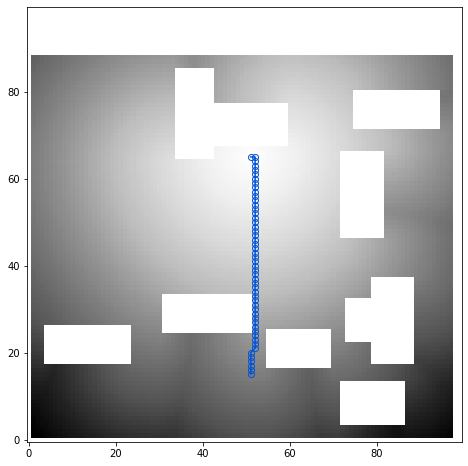

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.019998237490653978 vy:  0.3615305125713349 v:  0.36208319627238256
vx:  0.19461897015571616 vy:  0.6391296386718749 v:  0.6681042123601024
vx:  0.11334624886512748 vy:  0.767025351524353 v:  0.7753549264774505
vx:  0.056384779512882316 vy:  0.9015460014343262 v:  0.9033074980663774
vx:  0.01809327304363259 vy:  0.9310660362243652 v:  0.9312418216231391
vx:  0.018093284219503403 vy:  0.9310659766197205 v:  0.9312417622468837
vx:  0.01809326931834221 vy:  0.9310659766197206 v:  0.9312417619573663
vx:  0.018093286082148552 vy:  0.9310660362243652 v:  0.931241821876467
vx:  0.018093291670084055 vy:  0.9310660362243651 v:  0.931241821985036
vx:  0.018093276768922723 vy:  0.9310660362243652 v:  0.9312418216955185
vx:  0.018093284219503347 vy:  0.9310660362243653 v:  0.9312418218402774
vx:  0.018093260005116463 vy:  0.9310660362243651 v:  0.9312418213698113
vx:  0.01809316314756859 vy:  0.9310660362243653 v:  0.9312418194879544
vx:  -0.000930924667045

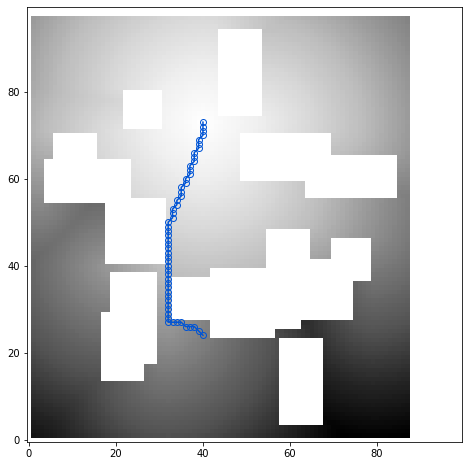

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.30901235342025757 vy:  0.13918930292129525 v:  0.3389134057750479
vx:  -0.39758437871932983 vy:  0.2917311191558838 v:  0.4931332315770049
vx:  -0.38168102502822876 vy:  0.2800618410110473 v:  0.4734078998676475
vx:  -0.3664137125015258 vy:  0.26885917782783514 v:  0.45447141407508823
vx:  -0.3517571687698364 vy:  0.25810497999191284 v:  0.43629266149867446
vx:  -0.3376868963241577 vy:  0.24778077006340035 v:  0.41884096022506456
vx:  -0.3241794705390931 vy:  0.2378696054220199 v:  0.4020874013229389
vx:  -0.31121224164962774 vy:  0.22835467755794522 v:  0.3860037799234347
vx:  -0.29876375198364263 vy:  0.2192204594612121 v:  0.3705636103906163
vx:  -0.2868131995201111 vy:  0.2104515880346298 v:  0.3557410326702004
vx:  -0.2753406763076782 vy:  0.2020337432622909 v:  0.34151152461687573
vx:  -0.26432704925537115 vy:  0.19395212829113 v:  0.3278509067193659
vx:  -0.2537539601325989 vy:  0.18619419634342188 v:  0.31473695530545714
vx:  -0.243603

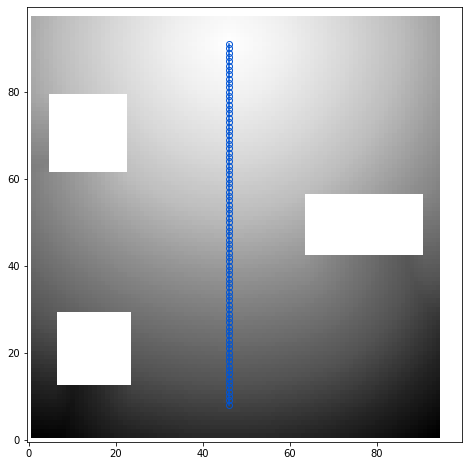

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.06815423071384427 vy:  0.14294856786727905 v:  0.15836442851695579
idx:  0
vx:  0.1445236653089524 vy:  0.3055585920810699 v:  0.3380135249200833
vx:  0.0418390594422817 vy:  0.48724359273910517 v:  0.4890366300803302
vx:  0.18113541603088376 vy:  0.60199373960495 v:  0.6286545167770877
vx:  0.19857969880104043 vy:  0.7584958076477052 v:  0.7840598108531367
vx:  0.22375160455703746 vy:  0.9039799571037292 v:  0.931259654117534
vx:  0.22321438789367687 vy:  0.9261267781257629 v:  0.952646562017811
vx:  0.21817541122436535 vy:  0.9190111756324767 v:  0.9445538899397471
vx:  0.21730931103229512 vy:  0.9223883152008057 v:  0.9476410399936843
vx:  0.21479205787181826 vy:  0.9160369038581848 v:  0.9408821591224376
vx:  0.21234990656375918 vy:  0.9082937836647033 v:  0.9327861921477933
vx:  0.20971001684665702 vy:  0.8988693356513976 v:  0.9230083280990535
vx:  0.20666335523128515 vy:  0.8873535990715027 v:  0.9111016146295656
vx:  0.20301537215709708

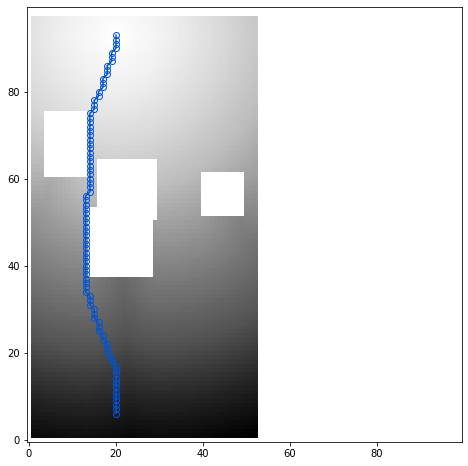

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.03948774933815 vy:  0.8300631642341613 v:  0.8310018886658566
vx:  0.0021599268075079836 vy:  0.9999976754188536 v:  1.0000000080634623
vx:  0.0021599268075079836 vy:  0.9999976754188536 v:  1.0000000080634623
vx:  0.002159926574677229 vy:  0.9999976754188538 v:  1.0000000080629596
vx:  0.0021599268075079836 vy:  0.9999976754188536 v:  1.0000000080634623
vx:  0.0015998381422831498 vy:  0.9999987483024598 v:  1.0000000280442836
vx:  0.0015998381422831498 vy:  0.9999987483024598 v:  1.0000000280442836
vx:  0.0015998381422831498 vy:  0.9999987483024598 v:  1.0000000280442836
vx:  -0.2921599447727204 vy:  0.9563694596290587 v:  0.9999999883203883
vx:  -0.2921599447727204 vy:  0.9563694596290587 v:  0.9999999883203883
vx:  -0.2921599447727204 vy:  0.9563694596290587 v:  0.9999999883203883
vx:  -0.22807836532592776 vy:  0.9735789299011229 v:  0.9999378348063258
vx:  -0.2280767261981963 vy:  0.9735719561576843 v:  0.9999306710217399
vx:  -0.228074803

vx:  0.3833193182945254 vy:  0.9236158728599547 v:  0.9999999901883179
vx:  0.3833193182945254 vy:  0.9236158728599547 v:  0.9999999901883179
vx:  0.3833193182945254 vy:  0.9236158728599547 v:  0.9999999901883179
vx:  0.25772875547409085 vy:  0.9662173390388487 v:  1.0000000288287683
vx:  0.25772875547409085 vy:  0.9662173390388487 v:  1.0000000288287683
vx:  0.2577287554740903 vy:  0.9458460807800293 v:  0.9803310256873263
vx:  0.25728774070739735 vy:  0.9080122709274292 v:  0.9437601738117074
vx:  0.25591427087783825 vy:  0.8716917634010314 v:  0.9084815047210015
vx:  0.16821634769439703 vy:  0.836824059486389 v:  0.8535638500820673
vx:  0.16641229391098014 vy:  0.8033510446548462 v:  0.8204059681113657
vx:  0.1640824675559998 vy:  0.7712169885635376 v:  0.7884787248926107
vx:  0.16119867563247656 vy:  0.7403683066368103 v:  0.7577138262549538


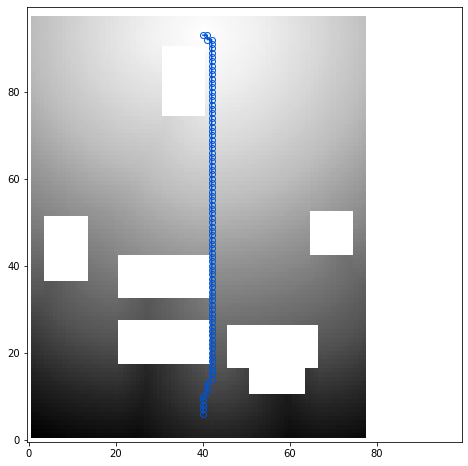

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.004784140735864584 vy:  0.3783191442489624 v:  0.37834939263575906
vx:  0.03411167487502098 vy:  0.390999972820282 v:  0.3924851399839749
vx:  0.21527783572673795 vy:  0.4906176328659058 v:  0.5357706675753472
vx:  0.21280401945114136 vy:  0.6390300393104553 v:  0.6735316932674243
vx:  0.1690825819969177 vy:  0.707652747631073 v:  0.7275722168723538
vx:  0.1370201706886292 vy:  0.7399634122848511 v:  0.752542609222748
vx:  0.15657533705234533 vy:  0.7541987299919127 v:  0.7702801831116192
vx:  0.19000864028930672 vy:  0.6943742632865907 v:  0.7199020078450863
vx:  0.20593349635601038 vy:  0.6509398221969604 v:  0.6827380588799935
vx:  0.22436462342739105 vy:  0.6375272274017334 v:  0.6758553468932953
vx:  0.22099220752716067 vy:  0.6208705306053162 v:  0.6590278989252689
vx:  0.21338519454002386 vy:  0.6084824800491333 v:  0.644813282877786
vx:  0.2033872753381728 vy:  0.5981922149658203 v:  0.6318230051329248
vx:  0.1919664442539215 vy:  0.5888

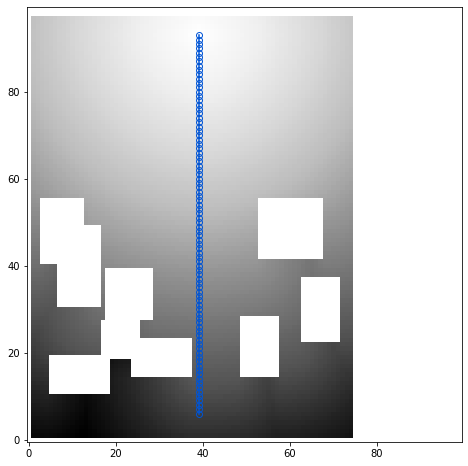

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.12601143121719366 vy:  0.4203473031520844 v:  0.4388288231926384
vx:  0.034206755459308624 vy:  0.9699082374572754 v:  0.9705112524883631
vx:  -0.008355182595550958 vy:  0.9704753756523132 v:  0.9705113414194104
vx:  -0.008355182595550958 vy:  0.9704753756523132 v:  0.9705113414194104
vx:  -0.008355182595550958 vy:  0.9704753756523132 v:  0.9705113414194104
vx:  -0.008355182595550958 vy:  0.9704753756523132 v:  0.9705113414194104
vx:  -0.0062376731075345915 vy:  0.9704912900924683 v:  0.9705113356943029
vx:  -0.0062376731075345915 vy:  0.9704912900924683 v:  0.9705113356943029
vx:  -0.0062376731075345915 vy:  0.9704912900924683 v:  0.9705113356943029
vx:  -0.0062376731075345915 vy:  0.9704912900924683 v:  0.9705113356943029
vx:  -0.0062376731075345915 vy:  0.9704912900924683 v:  0.9705113356943029
vx:  -0.006237672641873304 vy:  0.9704912900924683 v:  0.97051133569131
vx:  -0.004587965086102541 vy:  0.9705004692077637 v:  0.970511313770283
vx: 

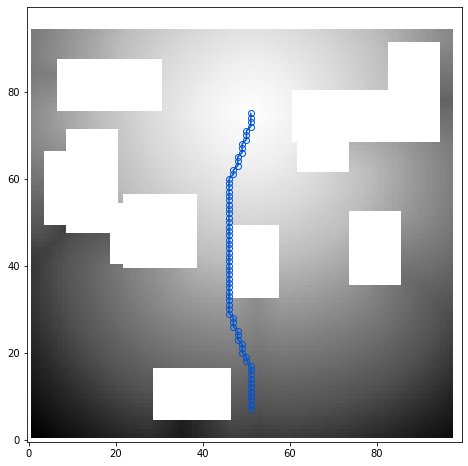

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.11778304725885391 vy:  0.21723859012126923 v:  0.24711424738257853
idx:  0
vx:  0.25607913732528687 vy:  0.3758310079574585 v:  0.4547806846333542
vx:  0.26160827279090876 vy:  0.38082724809646606 v:  0.4620262777000566
vx:  -0.03449907898902893 vy:  0.41493347287178034 v:  0.4163651923018154
vx:  -0.0192641522735357 vy:  0.41533729434013367 v:  0.41578380876676857
vx:  -0.018978746607899694 vy:  0.41534489393234253 v:  0.4157782747312271
vx:  -0.018696309998631505 vy:  0.415352463722229 v:  0.41577304040508745
vx:  -0.018416475504636765 vy:  0.41535967588424677 v:  0.4157677559896623
vx:  -0.018140070140361814 vy:  0.41536715626716614 v:  0.41576307754557723
vx:  -0.01786658726632595 vy:  0.41537439823150635 v:  0.41575847032469615
vx:  -0.017596401274204254 vy:  0.4153817296028137 v:  0.4157542719270938
vx:  -0.017328985035419464 vy:  0.4153886735439301 v:  0.4157499775477367
vx:  -0.017064526677131597 vy:  0.4153953492641449 v:  0.41574570865

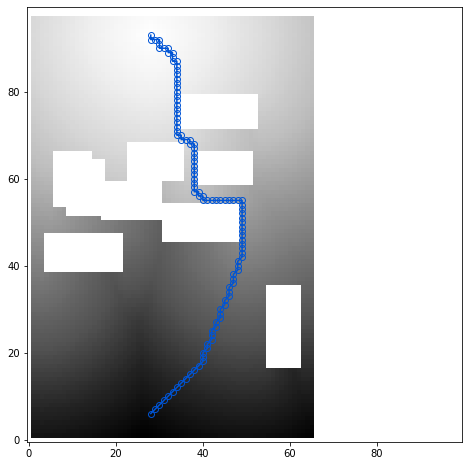

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.13537649810314178 vy:  0.49982336163520813 v:  0.5178322016589834
vx:  0.36741197109222407 vy:  0.7044675946235657 v:  0.7945225914828261
vx:  0.4478536546230315 vy:  0.8863366246223449 v:  0.9930586629732088
vx:  0.4478536546230315 vy:  0.8863366246223449 v:  0.9930586629732088
vx:  0.4478536546230315 vy:  0.8863366246223449 v:  0.9930586629732088
vx:  0.4478536546230315 vy:  0.8863366246223449 v:  0.9930586629732088
vx:  0.4478536546230315 vy:  0.8863366246223449 v:  0.9930586629732088
vx:  0.39301022887229947 vy:  0.9119804501533506 v:  0.9930585992076022
vx:  0.3646779954433444 vy:  0.9236748814582822 v:  0.9930585717859484
vx:  0.5376673936843874 vy:  0.8345673084259032 v:  0.9927682602322753
vx:  0.5451009273529049 vy:  0.8300784826278689 v:  0.9930585623832978
vx:  0.5451009273529049 vy:  0.8300784826278689 v:  0.9930585623832978
vx:  0.5451009273529049 vy:  0.8300784826278689 v:  0.9930585623832978
vx:  0.4338651299476624 vy:  0.89326727

vx:  -0.39333605766296387 vy:  0.0656437203288078 v:  0.3987760678331251
vx:  -0.20748192071914673 vy:  0.036016650497913326 v:  0.21058477280752075
idx:  0
vx:  -0.3697574734687805 vy:  0.06157731264829627 v:  0.37484977606903
vx:  -0.15385755896568298 vy:  0.026754423975944547 v:  0.15616641013087038
idx:  0
vx:  0.2605990767478943 vy:  0.05804403871297836 v:  0.2669849981402862
vx:  0.23361708223819724 vy:  0.15498806536197673 v:  0.2803537792114403
vx:  0.23997470736503596 vy:  0.1592059582471848 v:  0.28798332819164896
vx:  0.23037573695182795 vy:  0.15283769369125377 v:  0.2764639954658822
vx:  0.2211606800556183 vy:  0.146724134683609 v:  0.2654053844618029
vx:  0.21231424808502194 vy:  0.14085519313812253 v:  0.254789178290378
vx:  0.2038216888904571 vy:  0.13522097468376162 v:  0.24459761416780987
idx:  0
vx:  0.07773945480585097 vy:  0.05157456174492839 v:  0.09329179091802438
idx:  0
vx:  0.07581888139247894 vy:  0.050300389528274536 v:  0.09098698787355772
idx:  0
vx:  0.07

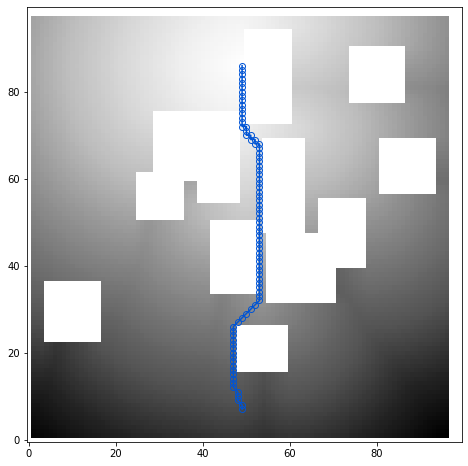

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.09625028073787685 vy:  0.36438482999801636 v:  0.3768825027442948
vx:  -0.13536059856414792 vy:  0.5474864840507507 v:  0.5639715789487068
vx:  -0.2368475049734115 vy:  0.7307833433151245 v:  0.7682063755781784
vx:  -0.1914760023355484 vy:  0.761811912059784 v:  0.785506491906074
vx:  -0.19836556911468503 vy:  0.7818485498428346 v:  0.8066201422612358
vx:  -0.19788359105587003 vy:  0.8024846315383911 v:  0.8265225341540751
vx:  -0.20992547273635853 vy:  0.8164645433425903 v:  0.8430201982391693
vx:  -0.21869587898254397 vy:  0.8239513039588929 v:  0.8524808729698911
vx:  -0.22585180401802063 vy:  0.828610062599182 v:  0.8588385606263931
vx:  -0.2322654128074646 vy:  0.8312042355537416 v:  0.8630455973985974
vx:  -0.23519325256347642 vy:  0.8295267224311829 v:  0.8622241293763518
vx:  -0.2383394390344619 vy:  0.82764732837677 v:  0.8612814803352427
vx:  -0.2445570677518845 vy:  0.82868629693985 v:  0.8640191769418553
vx:  -0.25000008940696716 v

vx:  0.13950182497501373 vy:  -0.025195844471454606 v:  0.14175891418175118
idx:  0
vx:  0.15082603693008423 vy:  -0.02136722765862943 v:  0.15233204467166725
idx:  0
vx:  0.23122142255306244 vy:  -0.02130803465843202 v:  0.23220115974832423
idx:  0
vx:  0.4742174744606018 vy:  -0.012420217506587589 v:  0.4743800953736386
vx:  0.44973888993263245 vy:  0.029918922111391993 v:  0.45073297085762876
vx:  0.4369538426399231 vy:  0.09036501497030258 v:  0.44620006334421075
vx:  0.4194756746292114 vy:  0.1513635665178299 v:  0.4459492918198543
vx:  0.40269663929939264 vy:  0.21103265881538397 v:  0.45464202004402915
vx:  0.38658881187438976 vy:  0.27070766687393183 v:  0.471946554570303
vx:  0.37112522125244135 vy:  0.26673075556755066 v:  0.4570330686233875
vx:  0.35628023743629456 vy:  0.25606155395507824 v:  0.4387517829041289
vx:  0.3420290350914002 vy:  0.24581909179687497 v:  0.42120171739606516
vx:  0.3283478617668152 vy:  0.2359862923622131 v:  0.40435361814840176
vx:  0.3152139484882

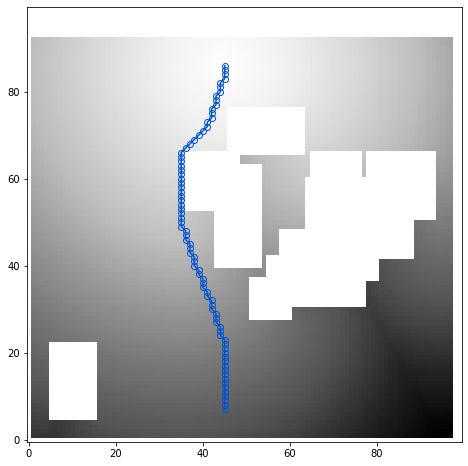

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.28420072793960577 vy:  0.21791023015975944 v:  0.35812696375682346
vx:  0.33208185434341414 vy:  0.29359582066535966 v:  0.44325710811709107
vx:  0.3932889699935913 vy:  0.42166042327880854 v:  0.5766053472508592
vx:  0.388814687728882 vy:  0.5076233148574829 v:  0.6394202774237046
vx:  0.3559947907924651 vy:  0.5457015037536621 v:  0.6515538521644846
vx:  0.35499063134193426 vy:  0.5510523915290833 v:  0.6554975869905755
vx:  0.3573105931282044 vy:  0.5386897325515746 v:  0.6464189724305098
vx:  0.36096397042274486 vy:  0.5192215442657471 v:  0.6323654006767443


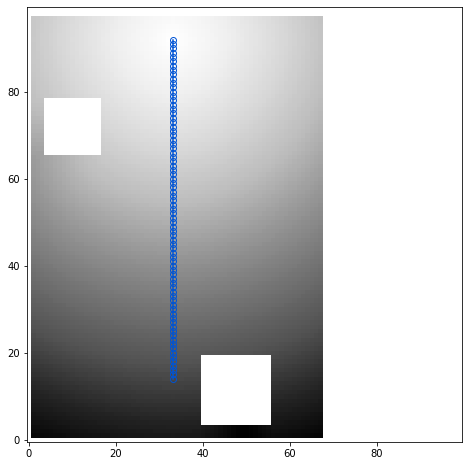

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.1911950707435608 vy:  0.5026396512985228 v:  0.5377752078091141
vx:  -0.1475327014923095 vy:  0.8995245695114135 v:  0.9115428400049624
vx:  0.020130936056375504 vy:  0.9997973442077637 v:  0.9999999920357017
vx:  0.020130936056375504 vy:  0.9997973442077637 v:  0.9999999920357017
vx:  0.020130936056375504 vy:  0.9997973442077637 v:  0.9999999920357017
vx:  0.020130936056375504 vy:  0.9997973442077637 v:  0.9999999920357017
vx:  0.020130936056375504 vy:  0.9997973442077637 v:  0.9999999920357017
vx:  0.01414952427148819 vy:  0.9998998641967772 v:  0.9999999737289211
vx:  0.01414952427148819 vy:  0.9998998641967772 v:  0.9999999737289211
vx:  0.01414952427148819 vy:  0.9998998641967772 v:  0.9999999737289211
vx:  0.01414952427148819 vy:  0.9998998641967772 v:  0.9999999737289211
vx:  0.01414952427148819 vy:  0.9998998641967772 v:  0.9999999737289211
vx:  0.009944951161742155 vy:  0.9999505281448364 v:  0.9999999803953732
vx:  0.0099449511617421

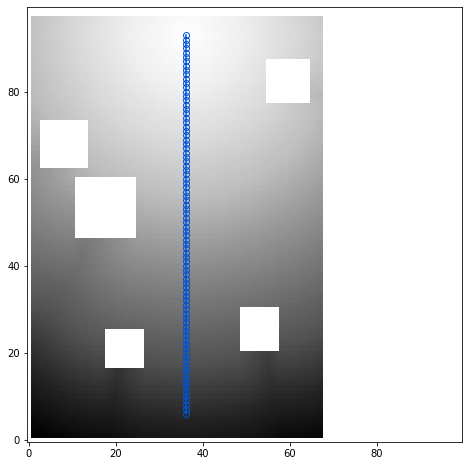

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.07240432500839242 vy:  0.7230048179626465 v:  0.7266211895321526
vx:  0.0034632890019566376 vy:  0.9220693111419679 v:  0.9220758151695198
vx:  0.0034632890019566376 vy:  0.9220693111419679 v:  0.9220758151695198
vx:  0.0034632890019566376 vy:  0.9220693111419679 v:  0.9220758151695198
vx:  0.0034632890019566376 vy:  0.9220693111419679 v:  0.9220758151695198
vx:  0.0034632890019566376 vy:  0.9220693111419679 v:  0.9220758151695198
vx:  0.002909734845161438 vy:  0.9220711588859559 v:  0.9220757499284746
vx:  0.002620318904519081 vy:  0.9220721125602722 v:  0.9220758357274768
vx:  0.0025639436207711697 vy:  0.9220722317695618 v:  0.9220757964546032
vx:  0.0025639436207711697 vy:  0.9220722317695618 v:  0.9220757964546032
vx:  0.0025639436207711697 vy:  0.9220722317695618 v:  0.9220757964546032
vx:  0.0025639436207711697 vy:  0.9220722317695618 v:  0.9220757964546032
vx:  0.002411412773653865 vy:  0.9220726490020752 v:  0.922075802170987
vx:  0.0

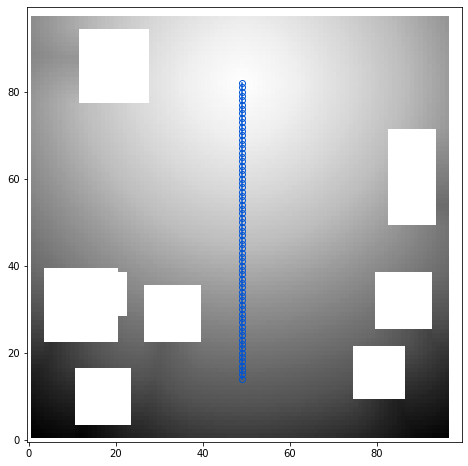

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.05140759050846099 vy:  0.13911910355091095 v:  0.14831340241089033
idx:  0
vx:  -0.08259749412536622 vy:  0.3233651220798492 v:  0.33374743177065147
vx:  0.18713891506195068 vy:  0.5628520846366882 v:  0.5931470666794447
vx:  0.15360862016677848 vy:  0.61541748046875 v:  0.6342982606440333
vx:  0.13098463416099548 vy:  0.6414594650268555 v:  0.6546962804681492
vx:  0.11902417987585073 vy:  0.6689587831497192 v:  0.679464943134134
vx:  0.1057583093643189 vy:  0.6816067099571228 v:  0.6897626599477332
vx:  0.09537198394536978 vy:  0.687042236328125 v:  0.6936301967334085
vx:  0.08642049133777618 vy:  0.6885468363761902 v:  0.6939490234928807
vx:  0.07811303436756128 vy:  0.6878677606582642 v:  0.69228874199363
vx:  0.07001354545354843 vy:  0.6859380602836609 v:  0.6895019355249754
vx:  0.06187698617577542 vy:  0.6832569241523744 v:  0.6860530488383246
vx:  0.07542490959167486 vy:  0.689817726612091 v:  0.6939289682202248
vx:  0.06918757408857346 v

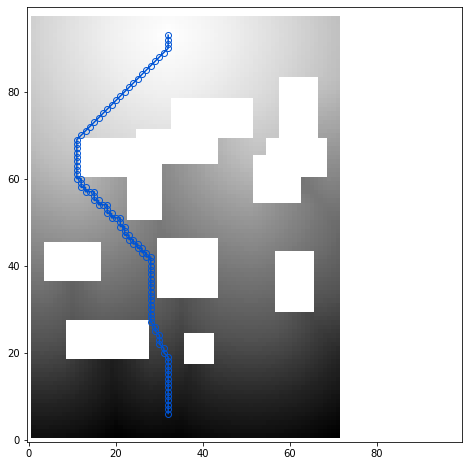

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.02629640698432916 vy:  0.6180843114852905 v:  0.6186434491082332
vx:  0.003733363002538702 vy:  0.9072477221488953 v:  0.9072554035902282
vx:  0.0012212954461575595 vy:  0.9999992251396179 v:  0.9999999709212011
vx:  0.0012212954461575595 vy:  0.9999992251396179 v:  0.9999999709212011
vx:  -0.004685744177550036 vy:  0.9794774055480958 v:  0.9794886136028976
vx:  -0.02773431688547126 vy:  0.9511443972587584 v:  0.9515486623235989
vx:  -0.049001440405845635 vy:  0.9370760321617125 v:  0.9383563455392554
vx:  -0.056714210659265435 vy:  0.9090939164161682 v:  0.9108612685560796
vx:  -0.05505850538611406 vy:  0.8825539946556091 v:  0.8842697509798273
vx:  -0.05351569503545761 vy:  0.8578237295150756 v:  0.8594914080630949
vx:  -0.05203198641538617 vy:  0.8340407013893126 v:  0.8356621441613276
vx:  -0.050606682896614144 vy:  0.8111937046051024 v:  0.8127707319685845
vx:  -0.0492375828325749 vy:  0.7892478704452514 v:  0.7907822333395957
vx:  -0.0479

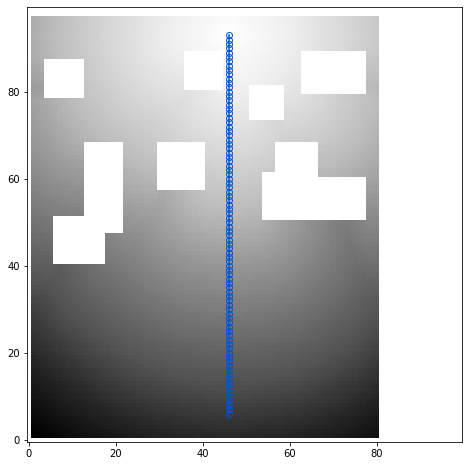

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.10267139971256259 vy:  0.30134096741676325 v:  0.31835168440359723
vx:  0.15686869621276855 vy:  0.5716028213500977 v:  0.5927373560244753
vx:  0.05532132089138028 vy:  0.6834903359413147 v:  0.6857255193372479
vx:  0.013016894459724482 vy:  0.7640718817710876 v:  0.7641827530470617
vx:  -0.011631663888692856 vy:  0.808240532875061 v:  0.8083242261537026
vx:  -0.02597532793879509 vy:  0.8325438499450684 v:  0.8329489658693889
vx:  -0.03433146327733999 vy:  0.8459801077842711 v:  0.8466764388699206
vx:  -0.039215087890625056 vy:  0.8534514307975769 v:  0.8543518993065449
vx:  -0.04208466038107872 vy:  0.8576354384422301 v:  0.8586673767597014
vx:  -0.04378395155072212 vy:  0.8599987626075745 v:  0.861112597805859
vx:  -0.044801417738199345 vy:  0.8613484501838684 v:  0.8625127939140987
vx:  -0.04541952908039093 vy:  0.8621299862861633 v:  0.863325574088747
vx:  -0.04580298066139227 vy:  0.8625909090042114 v:  0.8638061063306856
vx:  -0.0460478141

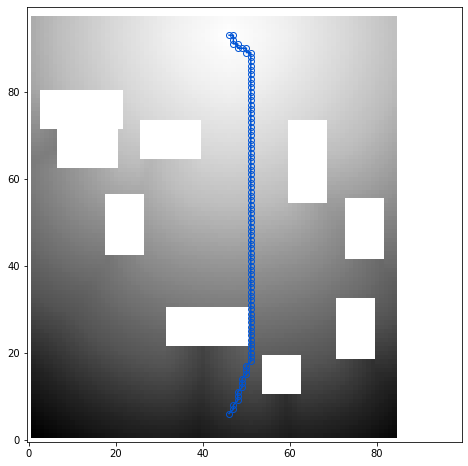

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.09733572602272031 vy:  0.603870987892151 v:  0.6116652790360202
vx:  0.25417110323905945 vy:  0.6516305804252626 v:  0.699446469050438
vx:  0.3028409779071808 vy:  0.9463930130004883 v:  0.9936661375713273
vx:  0.26964792609214794 vy:  0.9581381082534789 v:  0.9953585477270749
vx:  0.2696479558944702 vy:  0.9581381082534789 v:  0.995358555800683
vx:  0.2696479558944702 vy:  0.9581381082534789 v:  0.995358555800683
vx:  0.26964792609214777 vy:  0.9581381678581237 v:  0.9953586051028636
vx:  0.2696479558944702 vy:  0.9581381678581237 v:  0.9953586131764712
vx:  0.26958176493644703 vy:  0.9579030275344849 v:  0.9951143342078748
vx:  0.26942545175552357 vy:  0.9573478102684021 v:  0.9945375326649932
vx:  0.2692400217056275 vy:  0.95668888092041 v:  0.9938530093352805
vx:  0.2690177857875823 vy:  0.9558988213539122 v:  0.9930322883652133
vx:  0.26724764704704285 vy:  0.9496090412139893 v:  0.9864981682737849
vx:  0.2668460011482238 vy:  0.9481821060

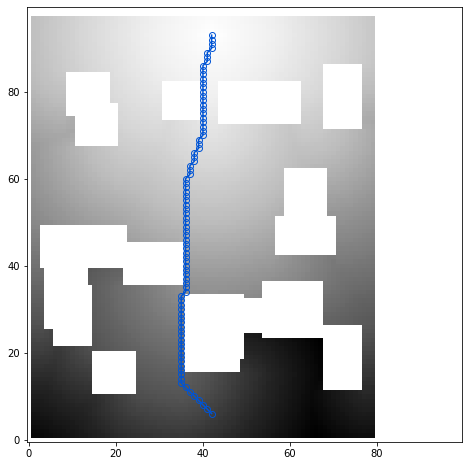

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.2425356209278107 vy:  0.4153877496719361 v:  0.4810098855495111
vx:  -0.48134887218475353 vy:  0.7840930223464966 v:  0.9200535878121435
vx:  -0.41861864924430847 vy:  0.8556792736053467 v:  0.9525904643512358
vx:  -0.41861867904663086 vy:  0.8556792736053467 v:  0.9525904774479534
vx:  -0.41861867904663086 vy:  0.8556792736053467 v:  0.9525904774479534
vx:  -0.41861870884895336 vy:  0.8556792736053468 v:  0.9525904905446719
vx:  -0.4186187386512755 vy:  0.8556792140007019 v:  0.9525904501005896
vx:  -0.4137616753578188 vy:  0.8457512855529785 v:  0.9415380826123949
vx:  -0.4111991822719573 vy:  0.8405132889747621 v:  0.9357068752789509
vx:  -0.408268243074417 vy:  0.8345220685005188 v:  0.9290371580929666
vx:  -0.40490299463272084 vy:  0.8276433348655703 v:  0.9213793598784095
vx:  -0.4010240435600282 vy:  0.8197150826454161 v:  0.9125530670758917
vx:  -0.3965376019477846 vy:  0.8105440735816956 v:  0.902343485030456


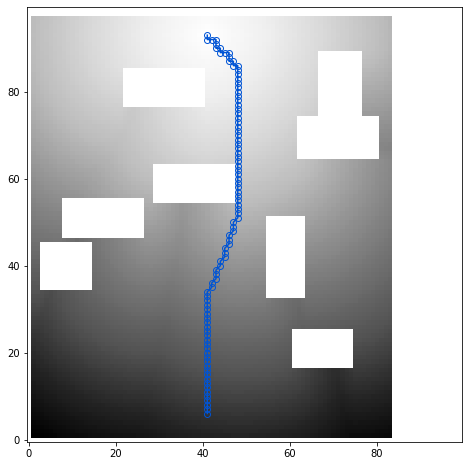

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.25701919198036216 vy:  0.5917613506317139 v:  0.6451669250261582
vx:  0.04486083984374967 vy:  0.7934101223945618 v:  0.7946773667782668
vx:  -0.01621504873037366 vy:  0.9998685121536255 v:  0.9999999847008164
vx:  -0.01621504873037366 vy:  0.9998685121536255 v:  0.9999999847008164
vx:  -0.01621504873037366 vy:  0.9998685121536255 v:  0.9999999847008164
vx:  -0.01621504873037366 vy:  0.9998685121536255 v:  0.9999999847008164
vx:  -0.012082500383257866 vy:  0.9999269843101501 v:  0.9999999803835512
vx:  -0.012082500383257866 vy:  0.9999269843101501 v:  0.9999999803835512
vx:  -0.012082500383257866 vy:  0.9999269843101501 v:  0.9999999803835512
vx:  -0.012082500383257866 vy:  0.9999269843101501 v:  0.9999999803835512
vx:  -0.012082500383257866 vy:  0.9999269843101501 v:  0.9999999803835512
vx:  -0.009002992883324568 vy:  0.9999594688415526 v:  0.9999999966033686
vx:  -0.009002992883324568 vy:  0.9999594688415526 v:  0.9999999966033686
vx:  -0.0090

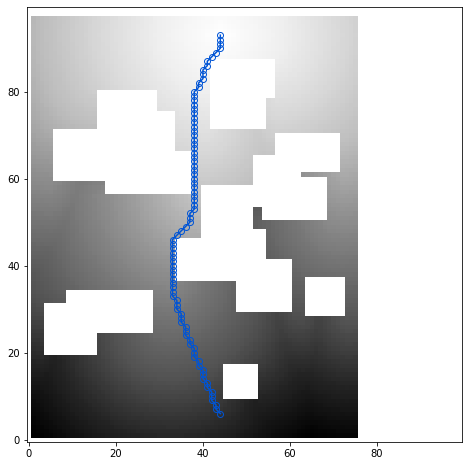

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.35239669680595387 vy:  0.4441013336181641 v:  0.5669298249705861
vx:  -0.2819756567478179 vy:  0.790236234664917 v:  0.8390372921245807
vx:  -0.27212461829185486 vy:  0.9375266432762146 v:  0.976221293935578
vx:  -0.27373918890953086 vy:  0.9618039727210999 v:  1.000000012743469
vx:  -0.19901117682456998 vy:  0.9506157636642455 v:  0.9712238560847117
vx:  -0.1730137616395947 vy:  0.9396958351135256 v:  0.9554904626663674
vx:  -0.142201468348503 vy:  0.9349761605262755 v:  0.9457281207370996
vx:  -0.11487883329391485 vy:  0.9528794288635254 v:  0.9597793247878647
vx:  -0.09998203068971678 vy:  0.926303446292877 v:  0.931683680803147
vx:  -0.09226246178150205 vy:  0.889251410961151 v:  0.8940248507454258
vx:  -0.08112546056509018 vy:  0.8536812663078307 v:  0.8575272851617255
vx:  -0.07043395936489144 vy:  0.8195341229438782 v:  0.8225552390576616
vx:  -0.060170084238052646 vy:  0.7867527008056641 v:  0.7890502210013132
vx:  -0.05031676217913633 

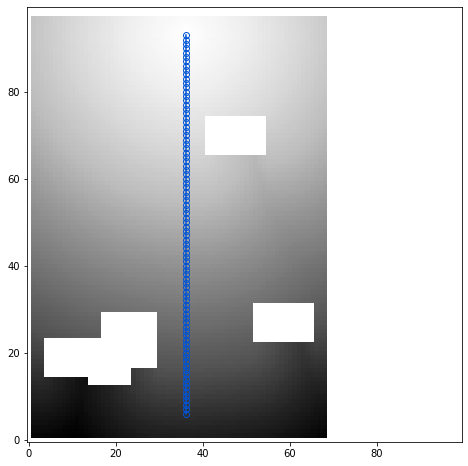

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.15072998404502874 vy:  0.4998243451118469 v:  0.5220573762113713
vx:  -0.02263256907463057 vy:  0.6551430821418763 v:  0.6555338978735389
vx:  0.14429235458374012 vy:  0.8102542161941528 v:  0.8230019310133608
vx:  0.024556064978241976 vy:  0.8345273733139037 v:  0.834888577678135
vx:  -0.01441140472888952 vy:  0.834764301776886 v:  0.8348886920466175
vx:  -0.01441140472888952 vy:  0.834764301776886 v:  0.8348886920466175
vx:  -0.01441140472888952 vy:  0.834764301776886 v:  0.8348886920466175
vx:  -0.003741613589227033 vy:  0.8348802328109741 v:  0.8348886170087346
vx:  0.015563648194074853 vy:  0.8347435593605042 v:  0.8348886375073938
vx:  0.03842320665717103 vy:  0.8340040445327759 v:  0.8348886686899326
vx:  0.05367975682020193 vy:  0.8166579604148865 v:  0.8184202713772908
vx:  0.07765810191631328 vy:  0.7910021543502808 v:  0.7948051264178093
vx:  0.1372591853141784 vy:  0.8004450798034668 v:  0.8121283209780892
vx:  0.14921763539314276 vy

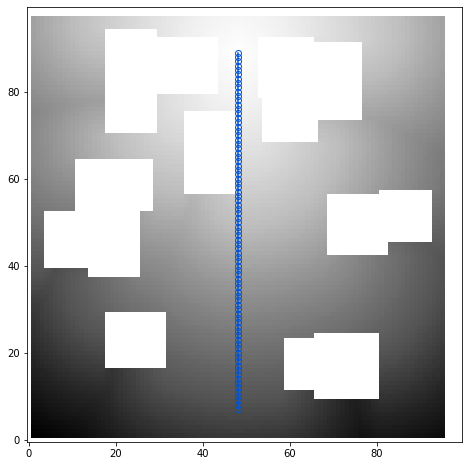

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.08293864130973821 vy:  0.6826769709587097 v:  0.6876966372606924
vx:  0.005204668268561308 vy:  0.8382035493850708 v:  0.8382197079367179
vx:  -0.006044935435056742 vy:  0.8381979465484619 v:  0.8382197437679885
vx:  -0.004200208466500044 vy:  0.8382092714309691 v:  0.8382197948414235
vx:  -0.004200208466500044 vy:  0.8382092714309691 v:  0.8382197948414235
vx:  -0.004200208466500044 vy:  0.8382092714309691 v:  0.8382197948414235
vx:  -0.004200208466500044 vy:  0.8382092714309691 v:  0.8382197948414235
vx:  -0.004200208466500044 vy:  0.8382092714309691 v:  0.8382197948414235
vx:  -0.004200208466500044 vy:  0.8382092714309691 v:  0.8382197948414235
vx:  -0.013983814045786913 vy:  0.8163630366325378 v:  0.8164827950637817
vx:  -0.07025963068008423 vy:  0.7986472249031067 v:  0.8017317541102731
vx:  0.0015551437390969036 vy:  0.8382182717323304 v:  0.8382197143577478
vx:  0.0015551437390969036 vy:  0.8382182717323304 v:  0.8382197143577478
vx:  0.0

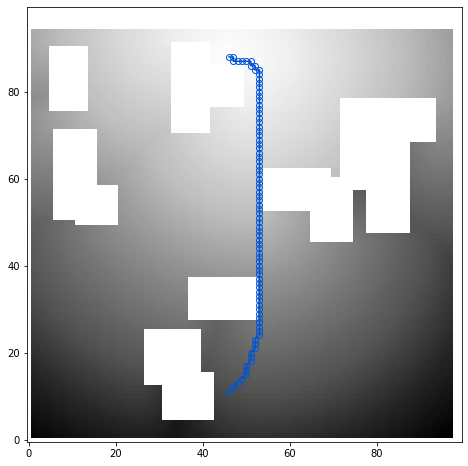

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.0902924835681915 vy:  0.5293712019920349 v:  0.5370163890305434
vx:  0.14496666193008423 vy:  0.6018146276473998 v:  0.6190284154394933
vx:  0.3505748510360718 vy:  0.5777420401573181 v:  0.6757873860498612
vx:  0.2983960509300231 vy:  0.7146064639091493 v:  0.7744046755226696
vx:  0.2864755988121033 vy:  0.7513819336891175 v:  0.8041412058768974
vx:  0.29627776145935053 vy:  0.7770916223526002 v:  0.8316561197189377
vx:  0.296277791261673 vy:  0.7770916223526001 v:  0.831656130336025
vx:  0.31884014606475825 vy:  0.7681098580360413 v:  0.8316560543606617
vx:  0.3263932168483734 vy:  0.7649309635162355 v:  0.8316561254211416
vx:  0.31728252768516535 vy:  0.7687546610832213 v:  0.8316561376623551
vx:  0.3028774261474609 vy:  0.7588048577308655 v:  0.8170186946365852
vx:  0.2869084775447845 vy:  0.7129310369491578 v:  0.7684966739892031
vx:  0.2732755839824676 vy:  0.6881856918334961 v:  0.7404587032679854
vx:  0.25154793262481684 vy:  0.6487472

vx:  -0.2053633332252501 vy:  0.6869699358940125 v:  0.7170089200669743
vx:  -0.17640443146228804 vy:  0.6594911217689515 v:  0.6826763970810791
vx:  -0.1716102659702302 vy:  0.6331114172935486 v:  0.6559574300926997
vx:  -0.1662537455558778 vy:  0.6077870130538939 v:  0.6301153554297283
vx:  -0.16033874452114108 vy:  0.5834755301475525 v:  0.605105120847265
vx:  -0.15387609601020819 vy:  0.5601364970207214 v:  0.58088789642924
vx:  -0.1468846052885056 vy:  0.5377310514450073 v:  0.5574314047117486
vx:  -0.13939197361469266 vy:  0.516221821308136 v:  0.5347102870741204
vx:  -0.13143572211265572 vy:  0.495572954416275 v:  0.512706448366071
vx:  -0.12306386977434161 vy:  0.47574999928474426 v:  0.49140897210294227
vx:  -0.06771032512187958 vy:  0.45672002434730524 v:  0.4617118893508307
vx:  -0.0646005570888519 vy:  0.43845120072364807 v:  0.44318471024190215
vx:  -0.06141185760498047 vy:  0.4209131598472595 v:  0.42536960914844285
vx:  -0.05816204845905307 vy:  0.4040766060352326 v:  0.

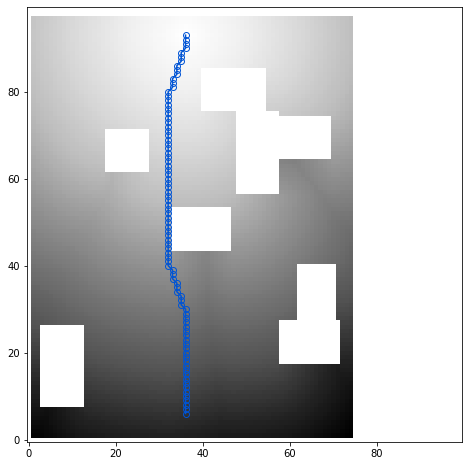

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.10750986635684948 vy:  0.5839080810546875 v:  0.5937230149531304
vx:  0.0070354063063861605 vy:  0.9375289678573608 v:  0.9375553650390915
vx:  -0.006345485337078904 vy:  0.9866600632667542 v:  0.9866804678464647
vx:  -0.003722216235473641 vy:  0.9887675642967223 v:  0.9887745704148021
vx:  0.008080447092652265 vy:  0.9770757555961609 v:  0.9771091678001111
vx:  0.029202407225966176 vy:  0.9771897196769715 v:  0.9776259657098667
vx:  0.03801403939723941 vy:  0.97421795129776 v:  0.9749593241885015
vx:  0.04154497012496011 vy:  0.9707922339439392 v:  0.9716807840173376
vx:  0.042983163148164416 vy:  0.9682851433753966 v:  0.9692387070251239
vx:  0.043282520025968774 vy:  0.9661747813224792 v:  0.9671437765933972
vx:  0.04293166100978846 vy:  0.9641749262809752 v:  0.9651302585589073
vx:  0.04370998218655581 vy:  0.9648128151893616 v:  0.965802428499934
vx:  0.043052449822426175 vy:  0.9632741808891295 v:  0.9642357911856082
vx:  0.042233049869537

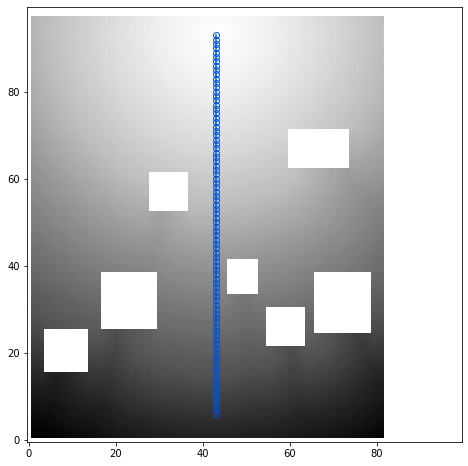

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.09267028421163559 vy:  0.386482834815979 v:  0.3974377475570994
vx:  0.03985178470611574 vy:  0.5456448197364806 v:  0.5470981941566971
vx:  -0.053424548357725095 vy:  0.6310317516326904 v:  0.6332892340280611
vx:  -0.1761372834444046 vy:  0.8001824021339415 v:  0.8193388916095826
vx:  -0.15545982122421265 vy:  0.8135002255439758 v:  0.8282212101698215
vx:  -0.14318516850471494 vy:  0.8169203400611877 v:  0.8293737604273541
vx:  -0.13515356183052055 vy:  0.8149065375328063 v:  0.826038225622267
vx:  -0.12913937866687775 vy:  0.8097544312477112 v:  0.8199873279799947
vx:  -0.12966367602348333 vy:  0.8102080225944519 v:  0.8205179515137586
vx:  -0.007228650152683314 vy:  0.8604487776756286 v:  0.8604791411687521
vx:  0.038676533848047326 vy:  0.8596094846725464 v:  0.8604791342092497
vx:  0.038676533848047326 vy:  0.8596094846725464 v:  0.8604791342092497
vx:  0.03867653757333746 vy:  0.8596094846725463 v:  0.8604791343766927
vx:  0.0386765338480

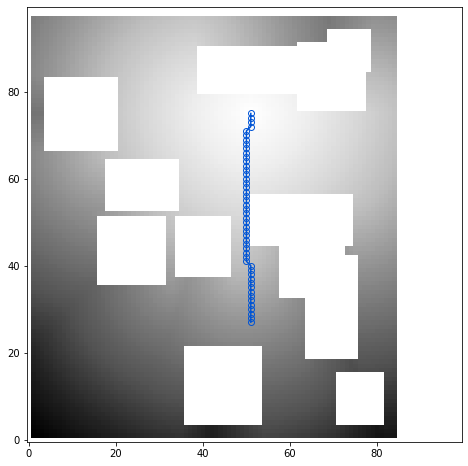

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.16514505445957184 vy:  0.18559485673904413 v:  0.24843176097359465
idx:  0
vx:  0.16262592375278484 vy:  0.3579505681991577 v:  0.39316129050371484
vx:  0.10458075255155566 vy:  0.5929398536682128 v:  0.6020920227609159
vx:  0.024242177605629023 vy:  0.5692223310470581 v:  0.5697383130330183
vx:  -0.007821517065167427 vy:  0.595684826374054 v:  0.5957361735713952
vx:  -0.014156911522150095 vy:  0.6481425166130066 v:  0.6482971078026551
vx:  -0.007208159193396513 vy:  0.7121238112449647 v:  0.7121602910167145
vx:  -0.007423857692629043 vy:  0.7334341406822205 v:  0.733471712052556
vx:  -0.007530960254371277 vy:  0.7440147995948793 v:  0.7440529130233691
vx:  -0.007568936329335085 vy:  0.7477670311927797 v:  0.7478053367929524
vx:  -0.007568925619125311 vy:  0.747767210006714 v:  0.7478055154893235
vx:  -0.007568936794996373 vy:  0.7477664947509766 v:  0.7478048003833413
vx:  -0.029473761096596607 vy:  0.9602615237236024 v:  0.9607137432852483
vx

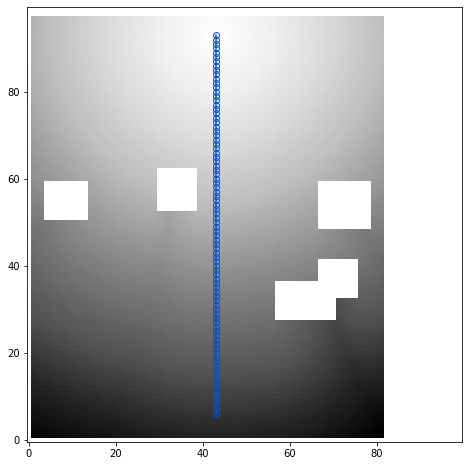

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.06221248209476446 vy:  0.6068114638328552 v:  0.6099922504158262
vx:  0.003583458252250926 vy:  0.9999935626983643 v:  0.9999999833056064
vx:  0.003583458252250926 vy:  0.9999935626983643 v:  0.9999999833056064
vx:  0.003583458252250926 vy:  0.9999935626983643 v:  0.9999999833056064
vx:  0.002658030251040999 vy:  0.9999964833259581 v:  1.0000000158945492
vx:  0.002658030251040999 vy:  0.9999964833259581 v:  1.0000000158945492
vx:  0.002658030251040999 vy:  0.9999964833259581 v:  1.0000000158945492
vx:  0.002658030251040999 vy:  0.9999964833259581 v:  1.0000000158945492
vx:  0.002658030251040999 vy:  0.9999964833259581 v:  1.0000000158945492
vx:  0.0019715921953315507 vy:  0.9999980330467225 v:  0.999999976636549
vx:  0.0019715919625012956 vy:  0.9999980330467224 v:  0.9999999766360899
vx:  0.0019715919625012956 vy:  0.9999980330467224 v:  0.9999999766360899
vx:  0.0019715919625012956 vy:  0.9999980330467224 v:  0.9999999766360899
vx:  0.0019715

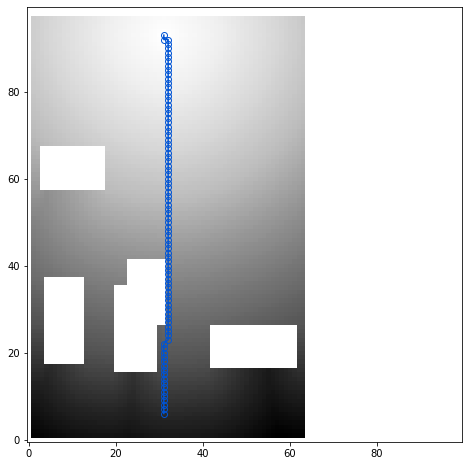

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.09255836904048922 vy:  0.45757409930229187 v:  0.4668416305683749
vx:  -0.023262359201908056 vy:  0.5595334768295287 v:  0.5600168292547817
vx:  0.09448489546775818 vy:  0.5909371972084045 v:  0.5984431188643395
vx:  0.2399351745843888 vy:  0.8543056845664978 v:  0.8873596174525149
vx:  0.22340551018714896 vy:  0.8685959577560425 v:  0.8968661883537126
vx:  0.21641479432582852 vy:  0.8703641295433043 v:  0.8968662560263735
vx:  0.2165186554193498 vy:  0.8703382611274718 v:  0.8968662201950715
vx:  0.2202112674713134 vy:  0.869411289691925 v:  0.8968662068363925
vx:  0.22445657849311837 vy:  0.8655023574829102 v:  0.8941337072481457
vx:  0.2270015925168993 vy:  0.8561189174652098 v:  0.8857027288244127
vx:  0.22937427461147306 vy:  0.8456941246986389 v:  0.8762483154924388
vx:  0.23126958310604087 vy:  0.8341972827911378 v:  0.8656620164279819
vx:  0.23249024152755762 vy:  0.8215252161025999 v:  0.853788845732928
vx:  0.24159327149391163 vy:  0.

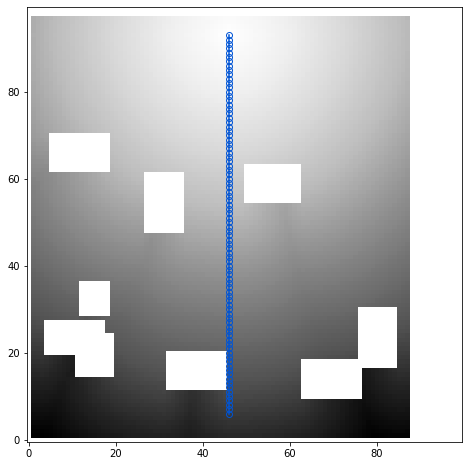

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.1808820366859436 vy:  0.30408692359924316 v:  0.3538179875298979
vx:  0.14177362620830516 vy:  0.6977027654647827 v:  0.7119613121690377
vx:  0.029621660709381215 vy:  0.9516749978065492 v:  0.952135885382584
vx:  -0.022373719140887233 vy:  0.9997496604919434 v:  0.9999999834809755
vx:  -0.010239201597869313 vy:  0.9970726966857912 v:  0.9971252698260323
vx:  -0.007987868040800039 vy:  0.999202072620392 v:  0.9992340006048255
vx:  -0.007991116493940326 vy:  0.9991567730903627 v:  0.9991887284968571
vx:  -0.007994789630174665 vy:  0.9991057515144349 v:  0.9991377379372949
vx:  -0.007998971268534688 vy:  0.9990479350090027 v:  0.9990799567537662
vx:  -0.008003729395568454 vy:  0.9989818334579469 v:  0.9990138954305083
vx:  -0.007974409498274215 vy:  0.9993889927864075 v:  0.9994208073226594
vx:  -0.007976839318871554 vy:  0.999355137348175 v:  0.9993869723534067
vx:  -0.007979580201208591 vy:  0.9993171095848085 v:  0.999348967683023
vx:  -0.0082

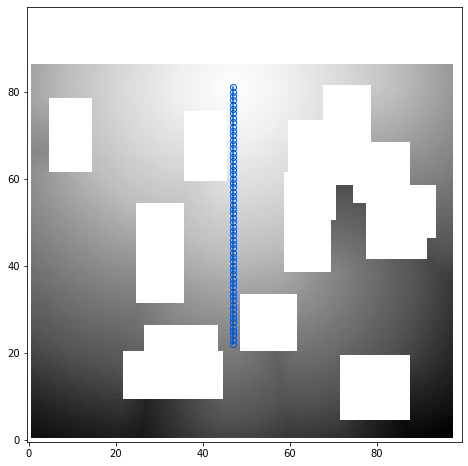

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.09872502088546756 vy:  0.393480122089386 v:  0.40567627023072733
vx:  0.01637589931488037 vy:  0.7318950295448303 v:  0.7320782091763142
vx:  0.13816930353641516 vy:  0.8151711225509644 v:  0.8267978685753473
vx:  0.11084152758121496 vy:  0.8523723483085632 v:  0.8595489889457097
vx:  0.09695269167423237 vy:  0.8540636301040649 v:  0.8595490147102792
vx:  0.08972744643688191 vy:  0.8548528552055358 v:  0.8595489623617378
vx:  0.08595443516969675 vy:  0.855240523815155 v:  0.859549020417662
vx:  0.08397827297449106 vy:  0.8554368019104004 v:  0.859548993597498
vx:  0.0829401165246964 vy:  0.8555380105972289 v:  0.8595489226948018
vx:  0.08239320665597916 vy:  0.8555909395217896 v:  0.859549007500348
vx:  0.08210415393114084 vy:  0.8556187152862549 v:  0.8595489968819984
vx:  0.08195102959871287 vy:  0.8556334376335144 v:  0.8595490392344315
vx:  0.0818694531917572 vy:  0.8556413054466248 v:  0.8595490974646658
vx:  0.0818259641528129 vy:  0.8556

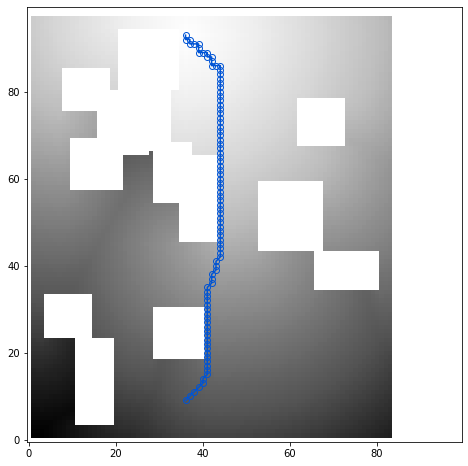

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.040069863200187725 vy:  0.3658077120780945 v:  0.3679957556177677
vx:  -0.002172380685806205 vy:  0.35117539763450617 v:  0.3511821167736159
vx:  -0.002094477415084811 vy:  0.3371284604072571 v:  0.33713496652262254
vx:  -0.0020162910223007167 vy:  0.323643296957016 v:  0.32364957762168306
vx:  -0.0019380748271941896 vy:  0.3106975555419922 v:  0.3107036001622851
vx:  -0.0018600523471832345 vy:  0.298269659280777 v:  0.2982754590009125
vx:  -0.0017824620008468697 vy:  0.2863388955593109 v:  0.2863444434259384
vx:  -0.0017055422067642143 vy:  0.27488526701927185 v:  0.2748905580380589
vx:  -0.0016295015811920166 vy:  0.26388987898826605 v:  0.263894909969565
vx:  -0.001554533839225821 vy:  0.2533343434333801 v:  0.25333911292628913
vx:  -0.0014808177947998186 vy:  0.24320095777511594 v:  0.24320546598313764
idx:  0
vx:  -0.20858922600746155 vy:  0.23347291350364685 v:  0.313079968292884
vx:  -0.007776349782943781 vy:  0.21900691092014313 v:  0.2

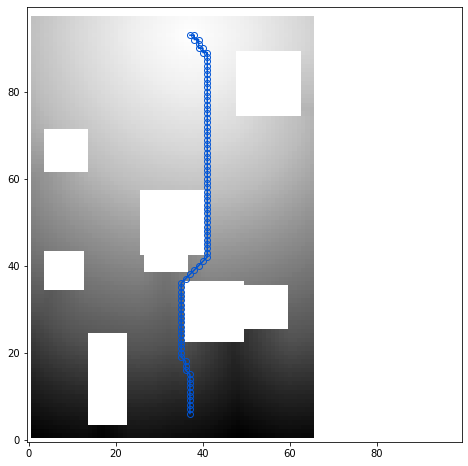

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.027838882058858788 vy:  0.6268346905708313 v:  0.627452574030354
vx:  -0.17837589979171772 vy:  0.8827432990074155 v:  0.9005851950642983
vx:  -0.03542298078536989 vy:  0.9879444241523744 v:  0.9885792698521891
vx:  -0.03542298451066021 vy:  0.9879444837570189 v:  0.9885793295520421
vx:  -0.0354229770600798 vy:  0.9879443645477295 v:  0.9885792101523357
vx:  -0.035422977060079686 vy:  0.987944483757019 v:  0.9885793292850715
vx:  -0.03542298823595043 vy:  0.9879444241523743 v:  0.9885792701191598
vx:  -0.03540507331490511 vy:  0.9874451160430907 v:  0.988079640724262
vx:  -0.03398736193776125 vy:  0.9479051828384399 v:  0.9485142995355761
vx:  -0.03262807801365865 vy:  0.9099950790405275 v:  0.9105798346948175
vx:  -0.03132314234971999 vy:  0.8736001253128052 v:  0.8741614943436995


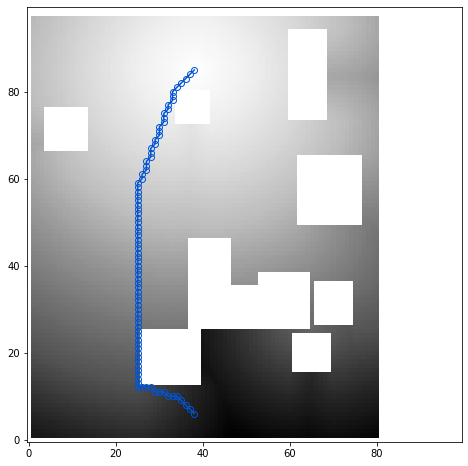

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.17418834567070005 vy:  0.2049561440944672 v:  0.2689769521159151
vx:  -0.6956894397735595 vy:  0.2215786874294281 v:  0.7301239013588017
vx:  -0.817195951938629 vy:  0.5124490261077883 v:  0.9645793011586464
vx:  -0.8124996423721315 vy:  0.5095040202140809 v:  0.9590359823641406
vx:  -0.8066771030426027 vy:  0.5058529376983643 v:  0.9521634014974903
vx:  -0.7993654012680055 vy:  0.5012679696083068 v:  0.9435330529979296
vx:  -0.7900594472885132 vy:  0.4954323768615723 v:  0.9325487495528252
vx:  -0.689426839351654 vy:  0.4323272109031678 v:  0.8137666644104583
vx:  -0.6706961393356324 vy:  0.4205816388130187 v:  0.7916578972172049
vx:  -0.64953875541687 vy:  0.40731412172317516 v:  0.7666846734764026
vx:  -0.6257918477058412 vy:  0.39242279529571544 v:  0.7386549173482796
vx:  -0.5993666648864746 vy:  0.375852108001709 v:  0.7074639256290485
vx:  -0.5702826976776123 vy:  0.3576138615608214 v:  0.6731344808066938
vx:  -0.538702368736267 vy:  0.

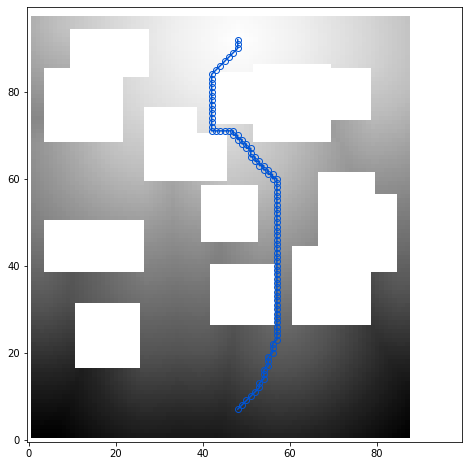

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.14366269111633312 vy:  0.32847377657890314 v:  0.3585163744081909
vx:  0.5300411581993103 vy:  0.5440645217895507 v:  0.7595721382827038
vx:  0.3750357925891877 vy:  0.679588556289673 v:  0.7762038724219831
vx:  0.34285390377044667 vy:  0.8599354028701783 v:  0.9257633047599859
vx:  0.34285384416580206 vy:  0.8599354624748229 v:  0.9257633380519319
vx:  0.34285387396812445 vy:  0.8599354624748229 v:  0.9257633490891385
vx:  0.3409652411937714 vy:  0.8606860041618347 v:  0.9257633031517248
vx:  0.33611643314361567 vy:  0.8625911474227904 v:  0.9257633305771799
vx:  0.3293849527835844 vy:  0.8651840090751649 v:  0.925763369700713
vx:  0.3213207125663759 vy:  0.8682111501693726 v:  0.9257632535387157
vx:  0.31218442320823675 vy:  0.8715381026268005 v:  0.9257633490391499
vx:  0.31218445301055886 vy:  0.8715380430221558 v:  0.9257633029756531
vx:  0.3075678646564487 vy:  0.873177945613861 v:  0.9257633153650939
vx:  0.3075678944587709 vy:  0.873177

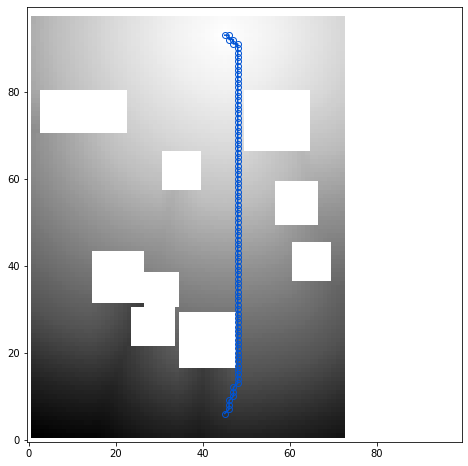

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -5.960464478926841e-08 vy:  0.47253483533859253 v:  0.4725348353385963
vx:  -5.960464473375726e-08 vy:  0.45363342761993414 v:  0.4536334276199381
vx:  -5.960464475457394e-08 vy:  0.43548804521560663 v:  0.4354880452156107
vx:  -5.960464481702399e-08 vy:  0.41806858777999883 v:  0.4180685877800031
vx:  -5.96046448100851e-08 vy:  0.40134590864181524 v:  0.4013459086418197
vx:  -2.980232241545089e-08 vy:  0.3852919638156891 v:  0.38529196381569025
vx:  -2.980232234606195e-08 vy:  0.36988037824630743 v:  0.3698803782463086
vx:  -2.980232241545089e-08 vy:  0.3550850749015809 v:  0.3550850749015822
vx:  -2.9802322359939737e-08 vy:  0.3408816158771515 v:  0.34088161587715277
vx:  -2.980232242238978e-08 vy:  0.3272463679313659 v:  0.32724636793136724
vx:  -2.98023224015731e-08 vy:  0.3141566216945648 v:  0.3141566216945662
vx:  -2.98023224015731e-08 vy:  0.30159023404121404 v:  0.3015902340412155
vx:  -2.9802322359939737e-08 vy:  0.28952664136886597 v: 

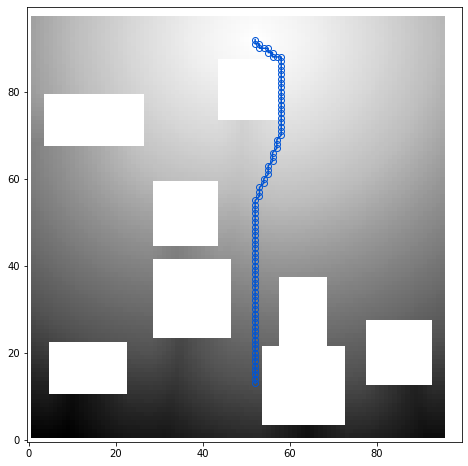

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.0031784288585186005 vy:  0.39693909883499146 v:  0.3969518240214343
vx:  -0.17050305008888236 vy:  0.5548966526985167 v:  0.5805011500984562
vx:  -0.1877188980579377 vy:  0.8086599111557007 v:  0.8301621748781572
vx:  -0.17508958280086517 vy:  0.8900166153907776 v:  0.9070754862066532
vx:  -0.14873738586902618 vy:  0.8835672736167908 v:  0.8959988487502427
vx:  -0.12749923765659324 vy:  0.8531630635261537 v:  0.8626373911258103
vx:  -0.1046873480081559 vy:  0.8105481863021851 v:  0.8172807370486243
vx:  -0.08787564933300022 vy:  0.7652169466018678 v:  0.7702461328123512
vx:  -0.1011781394481659 vy:  0.7399643063545228 v:  0.7468495099957705
vx:  -0.18547508120536796 vy:  0.8147572278976442 v:  0.8356017868336517
vx:  -0.17616237699985512 vy:  0.8564522862434388 v:  0.8743818969316853
vx:  -0.17193156480789182 vy:  0.8487477302551271 v:  0.8659868201020846
vx:  -0.17057481408119207 vy:  0.8462770581245421 v:  0.8632963722307437
vx:  -0.170574828

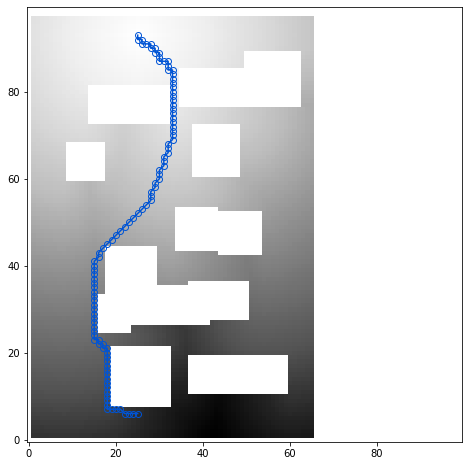

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.4472135901451111 vy:  0.11344705522060398 v:  0.46137861843469313
vx:  -0.7068042159080505 vy:  0.40587127208709717 v:  0.8150482741107993
vx:  -0.6104085445404053 vy:  0.3505178391933441 v:  0.7038901525385243
vx:  -0.5887998938560486 vy:  0.3381092846393585 v:  0.6789721668553379
vx:  -0.5658305287361145 vy:  0.3249192535877229 v:  0.6524850255766748
vx:  -0.5416131615638733 vy:  0.31101325154304515 v:  0.6245590920117902
vx:  -0.5163065791130067 vy:  0.29648157954216 v:  0.5953770323443706
vx:  -0.49011534452438366 vy:  0.2814412117004394 v:  0.5651744921541195
vx:  -0.46328467130661016 vy:  0.2660350501537322 v:  0.5342352801696764
vx:  -0.4360834360122681 vy:  0.25041386485099787 v:  0.5028676434946673
vx:  -0.40879860520362854 vy:  0.23474346101284022 v:  0.4714030039199146
vx:  -0.6217505931854248 vy:  0.48268020153045654 v:  0.7871175116054208
vx:  -0.23353728652000444 vy:  0.7880187034606934 v:  0.8218960647180389
vx:  -0.2116885483264

vx:  -0.0044250618666407115 vy:  0.5719019174575806 v:  0.5719190365464162
vx:  -0.005546569824218861 vy:  0.7168490290641785 v:  0.716870486843384
vx:  -0.0053244829177857556 vy:  0.6881750822067261 v:  0.6881956799403611
vx:  -0.005111575126648116 vy:  0.6606480479240417 v:  0.6606678223026473
vx:  -0.4369090795516969 vy:  0.6342220902442932 v:  0.7701475206403975


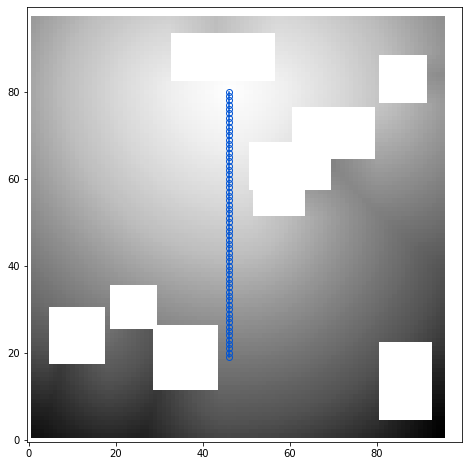

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.08203804492950445 vy:  0.39488938450813293 v:  0.40332104682630615
vx:  -0.17257547378540022 vy:  0.691866159439087 v:  0.713064567012867
vx:  -0.10113336145877827 vy:  0.808390200138092 v:  0.8146917653194099
vx:  -0.01989898830652259 vy:  0.8144486546516418 v:  0.8146917090528739
vx:  0.01006176136434056 vy:  0.8146295547485352 v:  0.814691690464282
vx:  0.010664888657629767 vy:  0.814621925354004 v:  0.8146917337972346
vx:  0.006970413029193878 vy:  0.8146618604660034 v:  0.8146916800580005
vx:  0.001445915549993404 vy:  0.8146904110908509 v:  0.8146916941979693
vx:  -0.005076361354440229 vy:  0.8146758675575256 v:  0.8146916831692882
vx:  -0.012156179174780624 vy:  0.8146010041236877 v:  0.8146917015727174
vx:  -0.019543448463082536 vy:  0.8144572377204895 v:  0.8146916830636723
vx:  -0.027110092341899483 vy:  0.8142405152320862 v:  0.8146917047277451
vx:  -0.03480435907840734 vy:  0.8139479160308839 v:  0.814691692250435
vx:  -0.0434692390

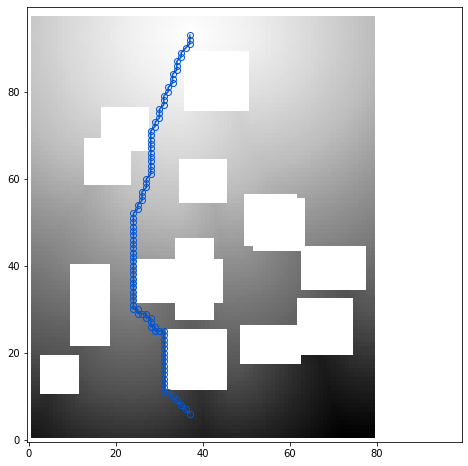

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.3162277638912201 vy:  0.2619627714157105 v:  0.4106391265618037
vx:  -0.44871565699577326 vy:  0.7773963212966919 v:  0.8976027970092216
vx:  -0.4770216941833497 vy:  0.8264367580413818 v:  0.9542260800059401
vx:  -0.47466111183166504 vy:  0.8223466873168945 v:  0.949503683629686
vx:  -0.4719412326812743 vy:  0.8176349401473999 v:  0.9440632512997013
vx:  -0.4687924683094024 vy:  0.8121793270111086 v:  0.9377641694839056
vx:  -0.4651279449462893 vy:  0.8058308959007263 v:  0.9304340051600251
vx:  -0.4608418345451353 vy:  0.7984052300453188 v:  0.9218601346357507
vx:  -0.45580393075942977 vy:  0.7896763086318971 v:  0.911781714946207
vx:  -0.41874265670776356 vy:  0.725465476512909 v:  0.8376428655213259
vx:  -0.3353275656700135 vy:  0.9328341484069824 v:  0.9912739907474407
vx:  -0.3153195679187775 vy:  0.948530912399292 v:  0.9995685677778778
vx:  -0.3153015375137328 vy:  0.9484766125679016 v:  0.9995113526853034
vx:  -0.3136659264564512 vy: 

vx:  0.3182365894317628 vy:  0.8474933505058289 v:  0.9052731665109466
vx:  0.30550703406333934 vy:  0.8135936260223389 v:  0.8690622165106223
vx:  0.29328688979148865 vy:  0.781049907207489 v:  0.8342998005947214
vx:  0.28155535459518444 vy:  0.7498078942298889 v:  0.8009277719936302


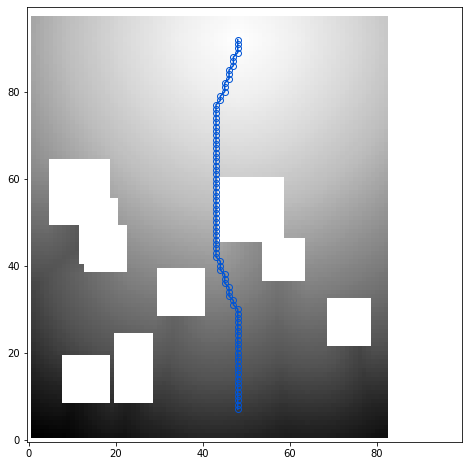

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.025544093921780572 vy:  0.27693840861320496 v:  0.27811397465697263
vx:  0.08239781111478806 vy:  0.6074163913726807 v:  0.612979666697614
vx:  0.0852647721767425 vy:  0.8744593858718872 v:  0.878606452806824
vx:  -0.0032958369702100754 vy:  0.9952726364135741 v:  0.9952780934668263
vx:  -0.009490414522588198 vy:  0.9999549388885498 v:  0.9999999738877066
vx:  -0.009490414522588198 vy:  0.9999549388885498 v:  0.9999999738877066
vx:  -0.004785821773111709 vy:  0.9970165491104126 v:  0.9970280353581236
vx:  0.0111469104886055 vy:  0.9998473525047302 v:  0.9999094868657659
vx:  0.014527470804750975 vy:  1.002047061920166 v:  1.0021523645188988
vx:  0.014515266753733158 vy:  1.0022603273391724 v:  1.002365430732204
vx:  0.014500985853374004 vy:  1.0024096965789795 v:  1.00251457764278
vx:  0.01751799695193773 vy:  0.9708409905433655 v:  0.9709990263313507
vx:  0.02122936956584448 vy:  0.932007372379303 v:  0.9322491235187813
vx:  0.024792242795228

vx:  -0.22755628824234012 vy:  0.0031617507338524004 v:  0.22757825244590923
idx:  0
vx:  0.06877686828374861 vy:  -0.002546451985836022 v:  0.06882399311748974
idx:  0
vx:  0.22239594161510468 vy:  0.0031371340155601918 v:  0.2224180668396806
idx:  0
vx:  -0.054338391870260246 vy:  0.0030116513371467642 v:  0.054421786766170245
idx:  0
vx:  -0.22791385650634766 vy:  0.0028911828994751254 v:  0.22793219370276382
idx:  0
vx:  0.06862424314022064 vy:  -0.0023164972662925755 v:  0.06866333014173476
idx:  0
vx:  0.22210425138473514 vy:  0.00286819785833356 v:  0.22212277020181467
idx:  0
vx:  -0.05464942753314971 vy:  0.002753473818302158 v:  0.054718749508455115
idx:  0
vx:  -0.2282276451587677 vy:  0.002643331885337802 v:  0.22824295217634305
idx:  0
vx:  0.0685070902109146 vy:  -0.0021089091897010907 v:  0.06853954265339678
idx:  0
vx:  0.2218485176563263 vy:  0.002621956169605269 v:  0.22186401114300772
idx:  0
vx:  -0.054922912269830704 vy:  0.0025170817971229484 v:  0.054980560136951

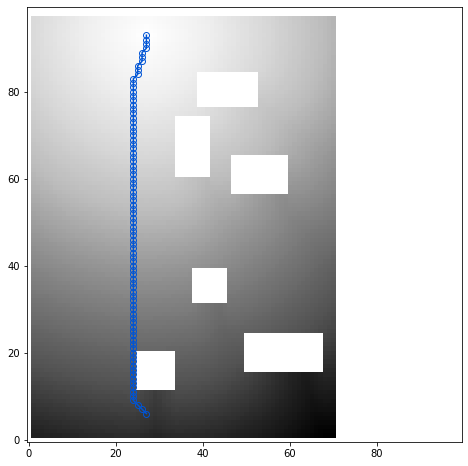

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  2.0816681711721685e-17 vy:  0.27314814925193787 v:  0.27314814925193787
vx:  1.3877787807814457e-17 vy:  0.2622222900390625 v:  0.2622222900390625
vx:  1.3877787807814457e-17 vy:  0.2517333924770355 v:  0.2517333924770355
vx:  1.3877787807814457e-17 vy:  0.24166393280029294 v:  0.24166393280029294
idx:  0
vx:  -0.2548541724681854 vy:  0.23199748992919922 v:  0.34463529209570587
vx:  -0.3033116459846493 vy:  0.89216685295105 v:  0.9423161083704862
vx:  -0.3013611137866976 vy:  0.8864294886589048 v:  0.936256246583619
vx:  -0.29911422729492176 vy:  0.8798210024833678 v:  0.929276233087383
vx:  -0.29651504755020175 vy:  0.8721756935119628 v:  0.921201179860714
vx:  -0.2934954464435577 vy:  0.8632931113243103 v:  0.9118193752838943
vx:  -0.28997313976287864 vy:  0.852932810783386 v:  0.9008766849545998
vx:  -0.2915608286857607 vy:  0.8576027154922485 v:  0.9058091048579751
vx:  -0.2885500788688663 vy:  0.8487489223480223 v:  0.8964574062397824
vx:  -0

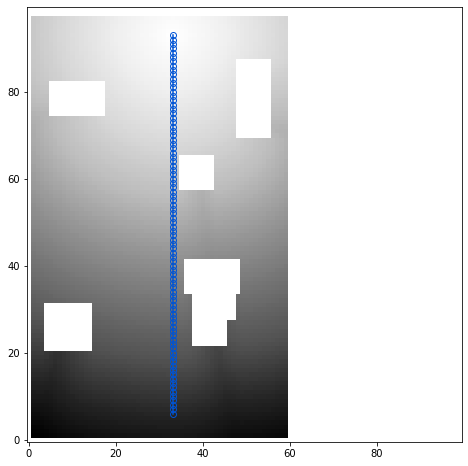

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.10655070096254354 vy:  0.711950957775116 v:  0.7198800026063471
vx:  0.009182028472423609 vy:  0.8417333960533143 v:  0.8417834755317511
vx:  0.004874654579907725 vy:  0.9234943389892579 v:  0.9235072043045901
vx:  0.004874654579907725 vy:  0.9234943389892579 v:  0.9235072043045901
vx:  0.004874654579907725 vy:  0.9234943389892579 v:  0.9235072043045901
vx:  0.004874654579907725 vy:  0.9234943389892579 v:  0.9235072043045901
vx:  0.003640733193606041 vy:  0.9234999418258667 v:  0.9235071182674047
vx:  0.003640733193606041 vy:  0.9234999418258667 v:  0.9235071182674047
vx:  0.003640733193606041 vy:  0.9234999418258667 v:  0.9235071182674047
vx:  0.003640733193606041 vy:  0.9234999418258667 v:  0.9235071182674047
vx:  -0.004943087697029072 vy:  0.9234938621520995 v:  0.9235070912280974
vx:  -0.020161265507340348 vy:  0.9232869744300843 v:  0.9235070729448241
vx:  -0.01815992593765256 vy:  0.9233285188674926 v:  0.9235070853350821
vx:  -0.0216256

vx:  0.006704926490783693 vy:  0.05091691017150879 v:  0.05135647749466768
idx:  0
vx:  0.006436727941036227 vy:  0.048797078430652625 v:  0.04921977580154323
idx:  0
vx:  0.006179265677928927 vy:  0.04676539450883866 v:  0.04717187136298227
idx:  0
vx:  0.005932085216045381 vy:  0.044818192720413215 v:  0.04520907025956765
idx:  0
vx:  0.005694806575775148 vy:  0.042951997369527824 v:  0.04332787670735109
idx:  0
vx:  0.005467012524604801 vy:  0.04116341844201088 v:  0.04152487500012814
idx:  0
vx:  0.005248330533504487 vy:  0.039449263364076614 v:  0.03979685104825748
idx:  0
vx:  0.005038402974605559 vy:  0.0378064326941967 v:  0.038140685069821954
idx:  0
vx:  0.004836864769458774 vy:  0.03623196855187416 v:  0.036553396640285424
idx:  0
vx:  0.00464338809251785 vy:  0.03472300618886948 v:  0.03503210258848311
idx:  0
vx:  0.004457652568817142 vy:  0.03327686339616776 v:  0.03357410168435623
idx:  0
vx:  0.004279345273971559 vy:  0.03189089521765709 v:  0.03217673062567803
idx:  0


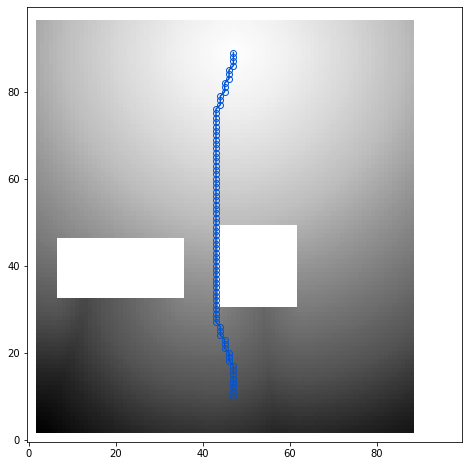

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.05818815529346469 vy:  0.4506587088108063 v:  0.45439975048791503
vx:  0.10723234713077537 vy:  0.5261312127113342 v:  0.5369476969503402
vx:  0.09486862272024138 vy:  0.5050860047340393 v:  0.513918211153321
vx:  0.10955127328634251 vy:  0.48488250374794006 v:  0.4971041379022408
vx:  0.12325084209442136 vy:  0.4654872119426727 v:  0.4815278959303881
vx:  0.13649527728557598 vy:  0.4468676745891571 v:  0.4672490549096778
vx:  0.14919307827949513 vy:  0.42899298667907726 v:  0.454195505510949
vx:  0.1613678932189942 vy:  0.4118333160877228 v:  0.44231920284082954
vx:  0.17304208874702454 vy:  0.3953599333763123 v:  0.4315704361946671
vx:  0.1842368841171264 vy:  0.37954553961753845 v:  0.4218981466097664
vx:  0.1949725598096847 vy:  0.3643637001514435 v:  0.41324956753370246
vx:  0.20526859164237982 vy:  0.3497891724109649 v:  0.4055707827874116
vx:  0.21514339745044714 vy:  0.3357976377010346 v:  0.39880663855070964
vx:  0.22461476922035212 vy

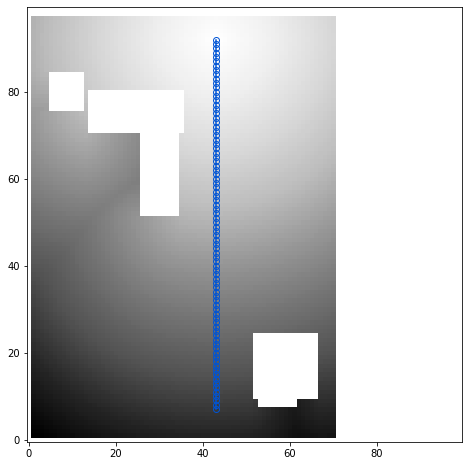

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  0.07734542340040221 vy:  0.625429093837738 v:  0.6301935146759935
vx:  -0.004751117900014035 vy:  0.9299222826957703 v:  0.9299344197175475
vx:  -0.004751117900014035 vy:  0.9299222826957703 v:  0.9299344197175475
vx:  -0.004751117900014035 vy:  0.9299222826957703 v:  0.9299344197175475
vx:  -0.004751117900014035 vy:  0.9299222826957703 v:  0.9299344197175475
vx:  -0.0033042961731553633 vy:  0.9299285411834716 v:  0.9299344117091374
vx:  -0.0033042961731553633 vy:  0.9299285411834716 v:  0.9299344117091374
vx:  -0.0033042961731553633 vy:  0.9299285411834716 v:  0.9299344117091374
vx:  -0.003304295940324664 vy:  0.9299285411834719 v:  0.9299344117083105
vx:  -0.003304295940324664 vy:  0.9299285411834719 v:  0.9299344117083105
vx:  -0.002319079358130749 vy:  0.9299315810203553 v:  0.9299344726958384
vx:  -0.002319079358130749 vy:  0.9299315810203553 v:  0.9299344726958384
vx:  -0.002319079358130749 vy:  0.9299315810203553 v:  0.9299344726958384
vx:

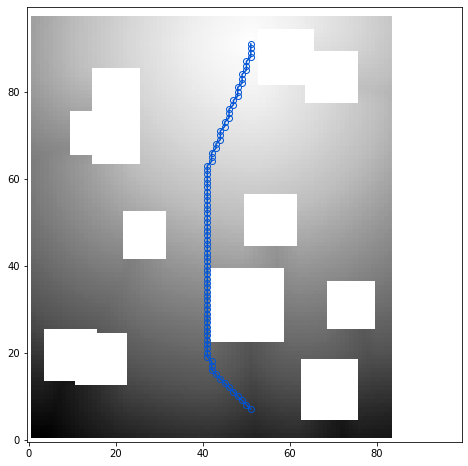

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.004015013575553908 vy:  0.46504276990890503 v:  0.4650601016842432
vx:  -0.3052049577236176 vy:  0.5543707013130188 v:  0.6328324744301318
vx:  -0.38422811031341536 vy:  0.7174820899963379 v:  0.813886841164379
vx:  -0.36371043324470537 vy:  0.7280979752540588 v:  0.8138869336831199
vx:  -0.36371037364006037 vy:  0.7280979156494141 v:  0.8138868537250209
vx:  -0.36371043324470537 vy:  0.7280979752540588 v:  0.8138869336831199
vx:  -0.3637104034423827 vy:  0.7280979752540588 v:  0.813886920365035
vx:  -0.363710343837738 vy:  0.7280979752540588 v:  0.813886893728868
vx:  -0.3637104034423829 vy:  0.7280979156494141 v:  0.8138868670431059
vx:  -0.3637103438377379 vy:  0.7280979156494141 v:  0.8138868404069369
vx:  -0.36371046304702775 vy:  0.7280979156494138 v:  0.8138868936792779
vx:  -0.3637103438377379 vy:  0.7280979156494141 v:  0.8138868404069369
vx:  -0.36371031403541554 vy:  0.7280979752540588 v:  0.8138868804107857
vx:  -0.36371040344238276 

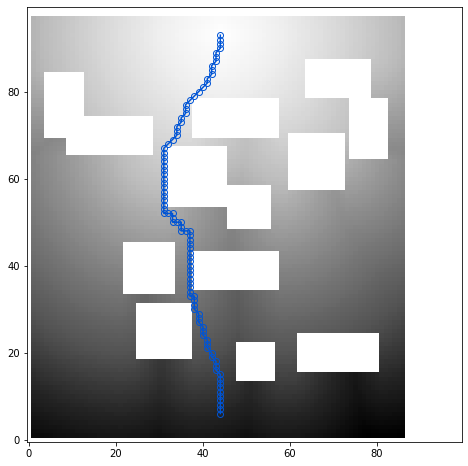

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.17559972405433655 vy:  0.5299499034881592 v:  0.558285019765951
vx:  0.010773154906928761 vy:  0.8929179906845093 v:  0.8929829779759019
vx:  0.010773154906928761 vy:  0.8929179906845093 v:  0.8929829779759019
vx:  0.007741897366940864 vy:  0.8929494619369507 v:  0.892983022542047
vx:  0.007741897366940864 vy:  0.8929494619369507 v:  0.892983022542047
vx:  0.007741896435618623 vy:  0.8929494619369507 v:  0.8929830225339727
vx:  -0.2572231292724608 vy:  0.8551344275474548 v:  0.8929829939084117
vx:  -0.2572231888771056 vy:  0.8551344275474548 v:  0.8929830110774899
vx:  -0.25722315907478344 vy:  0.8551343679428101 v:  0.8929829454146145
vx:  -0.20331263542175293 vy:  0.8695300817489623 v:  0.8929829734034662
vx:  -0.20331263542175293 vy:  0.8695300817489623 v:  0.8929829734034662
vx:  -0.20331263542175293 vy:  0.8695300817489623 v:  0.8929829734034662
vx:  -0.20331263542175293 vy:  0.8695300817489623 v:  0.8929829734034662
vx:  -0.2033126354217

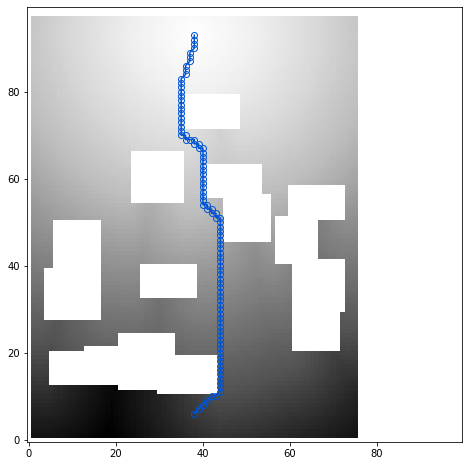

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.31622773408889765 vy:  0.23046326637268066 v:  0.3912969421732857
vx:  0.5729051828384399 vy:  0.6388865113258362 v:  0.8581353756122889
vx:  0.5729051232337952 vy:  0.6388866305351258 v:  0.8581354245712366
vx:  0.5719461441040039 vy:  0.6378173232078552 v:  0.8566990892603258
vx:  0.563367486000061 vy:  0.6282505989074708 v:  0.8438493581852301
vx:  0.5538504719734192 vy:  0.6176372170448303 v:  0.8295939230636047
vx:  0.5433045029640198 vy:  0.6058766841888427 v:  0.8137974805715775
vx:  0.5316396951675414 vy:  0.5928690433502197 v:  0.7963256042856095
vx:  0.5187737345695496 vy:  0.5785208344459534 v:  0.7770537584796046
vx:  0.5046352744102478 vy:  0.5627542734146119 v:  0.7558764002305628
vx:  0.4891735315322876 vy:  0.5455119609832764 v:  0.7327168917990015
vx:  0.4723665714263916 vy:  0.5267563462257385 v:  0.7075326325267368
vx:  0.0355066098272801 vy:  0.8574005365371705 v:  0.8581354201964015
vx:  -0.0014509368920699317 vy:  0.8581342

vx:  0.08631346374750137 vy:  0.03650928288698195 v:  0.09371735037341221
idx:  0
vx:  0.08528535813093185 vy:  0.03504889458417894 v:  0.09220638439443438
idx:  0
vx:  0.0842713713645935 vy:  0.033646948635578156 v:  0.09074018505686697
idx:  0
vx:  0.08323393017053604 vy:  0.032301075756549835 v:  0.08928183816803976
idx:  0
vx:  0.08218391239643098 vy:  0.031009033322334296 v:  0.08783937388420913
idx:  0
vx:  0.08107414096593857 vy:  0.02976866066455841 v:  0.08636659939540578
idx:  0
vx:  0.07987859100103378 vy:  0.028577931225299832 v:  0.0848368284026955
idx:  0
vx:  0.07827001065015794 vy:  0.0274348109960556 v:  0.08293891379542616
idx:  0
vx:  0.07423856109380722 vy:  0.026337414979934682 v:  0.07877197078342166
idx:  0
vx:  0.06733948737382889 vy:  0.02528391778469085 v:  0.07192970914937073
idx:  0
vx:  0.05967993289232255 vy:  0.024272568523883827 v:  0.06442710588547927
idx:  0
vx:  0.05210814252495766 vy:  0.023301653563976284 v:  0.05708086874090889
idx:  0
vx:  0.04504

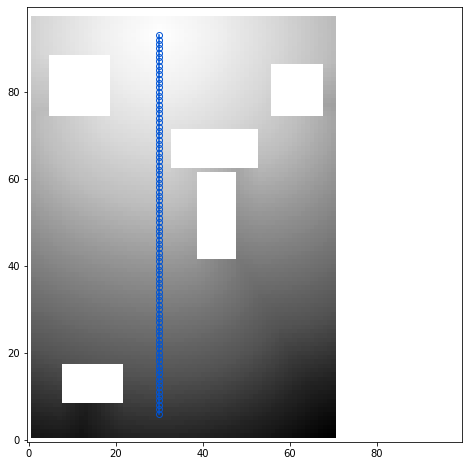

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.011630326509475652 vy:  0.7707808613777161 v:  0.7708686014885358
vx:  0.05437870696187014 vy:  0.8782810568809509 v:  0.8799628734479455
vx:  -0.0038266747724263195 vy:  0.9999926686286926 v:  0.999999990375474
vx:  -0.0038266747724263195 vy:  0.9999926686286926 v:  0.999999990375474
vx:  -0.0038266747724263195 vy:  0.9999926686286926 v:  0.999999990375474
vx:  -0.0038266747724263195 vy:  0.9999926686286926 v:  0.999999990375474
vx:  -0.0027782581746579327 vy:  0.9999961256980896 v:  0.9999999850648371
vx:  -0.0027782581746579327 vy:  0.9999961256980896 v:  0.9999999850648371
vx:  -0.0027782581746579327 vy:  0.9999961256980896 v:  0.9999999850648371
vx:  -0.0027782581746579327 vy:  0.9999961256980896 v:  0.9999999850648371
vx:  -0.0027782581746579327 vy:  0.9999961256980896 v:  0.9999999850648371
vx:  -0.0027782581746579327 vy:  0.9999961256980896 v:  0.9999999850648371
vx:  -0.0019729526247829754 vy:  0.9999980330467224 v:  0.9999999793196865


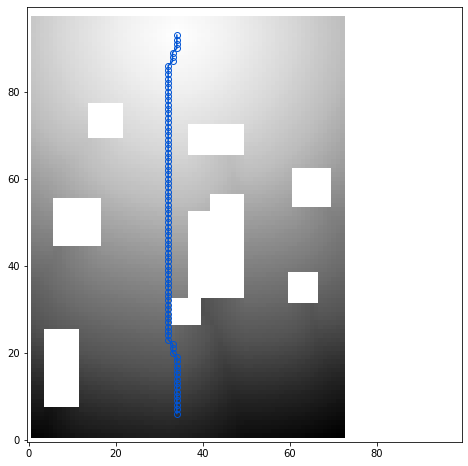

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.17224186658859253 vy:  0.5478081107139587 v:  0.5742481926570769
vx:  -0.09059640765190116 vy:  0.860920250415802 v:  0.8656739493917076
vx:  -0.0048721325583756525 vy:  0.8656601905822755 v:  0.8656739012091147
vx:  -0.005052480846643448 vy:  0.8656591773033141 v:  0.8656739217581619
vx:  -0.005052483640611227 vy:  0.8656592369079591 v:  0.8656739813780987
vx:  -0.005052480846643448 vy:  0.8656591773033141 v:  0.8656739217581619
vx:  -0.005052483640611172 vy:  0.8656591773033143 v:  0.8656739217744691
vx:  -0.005052482709288597 vy:  0.8656591773033142 v:  0.8656739217690333
vx:  -0.005052479915320873 vy:  0.8656591773033142 v:  0.8656739217527264
vx:  -0.005052480380982105 vy:  0.8656591773033142 v:  0.8656739217554442
vx:  -0.005052477587014492 vy:  0.8656592369079589 v:  0.8656739813427667
vx:  -0.005052475258708 vy:  0.8656591773033142 v:  0.8656739217255482
vx:  -0.005052478052675724 vy:  0.8656591176986695 v:  0.8656738621382257
vx:  -0.

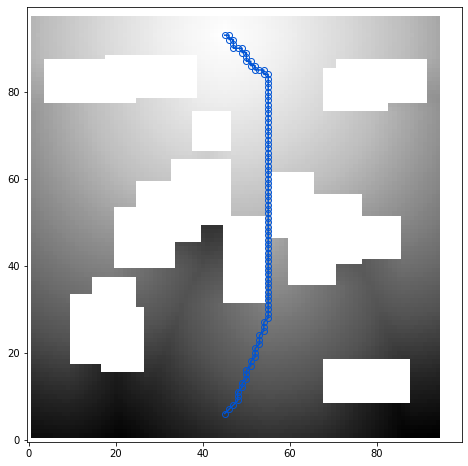

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.008414009585976519 vy:  0.4702973067760468 v:  0.4703725675654523
vx:  0.31331610679626487 vy:  0.7640025615692138 v:  0.825752321741991
vx:  0.2761494517326356 vy:  0.8344871401786804 v:  0.8789922108959941
vx:  0.2761494517326356 vy:  0.8344871401786804 v:  0.8789922108959941
vx:  0.26548129320144637 vy:  0.8379421234130862 v:  0.8789922179575562
vx:  0.29711446166038524 vy:  0.8272547125816345 v:  0.8789922427509035
vx:  0.301137775182724 vy:  0.8257986307144165 v:  0.8789922287095637
vx:  0.30113783478736855 vy:  0.8257986307144167 v:  0.8789922491297805
vx:  0.30113783478736855 vy:  0.8257986307144167 v:  0.8789922491297805
vx:  0.30113783478736855 vy:  0.8257986307144167 v:  0.8789922491297805
vx:  0.3011378049850465 vy:  0.825798511505127 v:  0.8789921269245221
vx:  0.301137804985046 vy:  0.825798571109772 v:  0.8789921829220967
vx:  0.3011377751827241 vy:  0.8257985711097718 v:  0.8789921727119883
vx:  0.30113783478736855 vy:  0.82579863

vx:  0.0005916000809520574 vy:  0.02596027404069901 v:  0.02596701405483452
idx:  0
vx:  0.0003309235326014357 vy:  0.024921864271163944 v:  0.02492406124881632
idx:  0
vx:  -3.6114361137212433e-06 vy:  0.023924991488456726 v:  0.023924991761026745
idx:  0
vx:  -0.00023497898655477488 vy:  0.02296798676252365 v:  0.02296918873290008
idx:  0
vx:  -0.0005403317045420335 vy:  0.022049263119697574 v:  0.022055882718054812
idx:  0
vx:  -0.0007502716034650712 vy:  0.02116729319095612 v:  0.02118058565079973
idx:  0
vx:  -0.0010311200749129107 vy:  0.02032060176134109 v:  0.02034674579759395
idx:  0
vx:  -0.0012199826305732153 vy:  0.01950778067111969 v:  0.019545891239117527
idx:  0
vx:  -0.0014914467465132445 vy:  0.01872747391462326 v:  0.018786769084134174
idx:  0
vx:  -0.0016633878694847226 vy:  0.01797837764024735 v:  0.018055163299723842
idx:  0
vx:  -0.0019286290043964995 vy:  0.017259232699871063 v:  0.017366655499113755
idx:  0
vx:  -0.002096472075209019 vy:  0.016568876802921295 v:

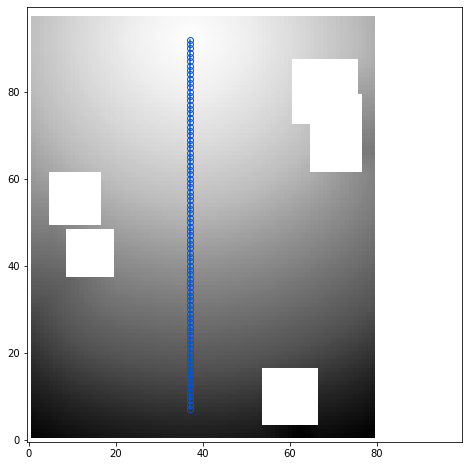

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.10867255926132201 vy:  0.3634933531284332 v:  0.3793904886854142
vx:  0.07264692336320877 vy:  0.6467050909996033 v:  0.6507726563085953
vx:  0.21179586648941037 vy:  0.8665931820869447 v:  0.8920993399288987
vx:  0.18952867388725275 vy:  0.8862684369087219 v:  0.9063072660450703
vx:  0.18674278259277338 vy:  0.8868596553802491 v:  0.9063072962255496
vx:  0.18674282729625696 vy:  0.886859655380249 v:  0.9063073054366128
vx:  0.18674276769161224 vy:  0.8868597149848939 v:  0.9063073514808377
vx:  0.18674278259277338 vy:  0.8868596553802491 v:  0.9063072962255496
vx:  0.1867428421974181 vy:  0.8868595957756042 v:  0.9063072501813267
vx:  0.18674279749393474 vy:  0.8868595957756042 v:  0.9063072409702622
vx:  0.18674279749393463 vy:  0.8868597149848938 v:  0.9063073576215454
vx:  0.17353357374668132 vy:  0.8895387053489685 v:  0.9063073482716633
vx:  0.1542436182498932 vy:  0.8930854797363282 v:  0.9063072149589709
vx:  0.1327796429395675 vy:  0.89

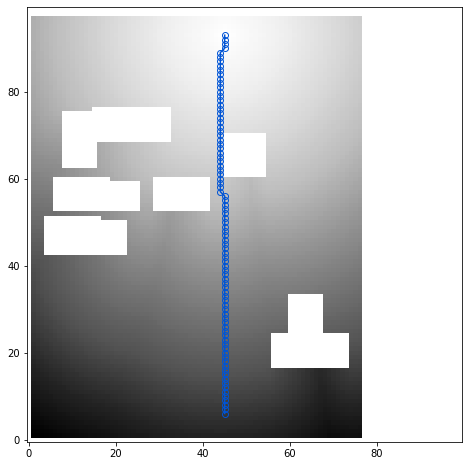

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.007731285877525862 vy:  0.5043060183525087 v:  0.5043652772821309
vx:  0.03970595821738249 vy:  0.7609537839889525 v:  0.7619889923647624
vx:  0.038859777152538244 vy:  0.893174946308136 v:  0.8940198918328868
vx:  -0.0037242637481539886 vy:  0.8940122127532959 v:  0.8940199699629255
vx:  -0.0037242637481539886 vy:  0.8940122127532959 v:  0.8940199699629255
vx:  -0.0037242637481539886 vy:  0.8940122127532959 v:  0.8940199699629255
vx:  -0.003724263515323456 vy:  0.8940122127532959 v:  0.8940199699619555
vx:  -0.002713773632422145 vy:  0.8940157890319826 v:  0.8940199078352823
vx:  -0.002713773632422145 vy:  0.8940157890319826 v:  0.8940199078352823
vx:  -0.002713773632422145 vy:  0.8940157890319826 v:  0.8940199078352823
vx:  -0.002713773632422145 vy:  0.8940157890319826 v:  0.8940199078352823
vx:  -0.002713773632422145 vy:  0.8940157890319826 v:  0.8940199078352823
vx:  -0.001998034771531765 vy:  0.8940176367759705 v:  0.8940198694712771
vx:  

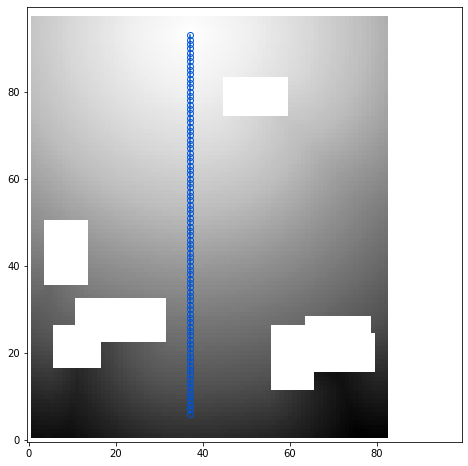

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.04229488223791117 vy:  0.5818649530410767 v:  0.583400103394757
vx:  0.002744813915342037 vy:  0.9999962449073792 v:  1.0000000119161443
vx:  0.002744814148172625 vy:  0.9999962449073794 v:  1.0000000119167838
vx:  0.001999307423830199 vy:  0.9999979734420776 v:  0.9999999720592182
vx:  0.001999307423830199 vy:  0.9999979734420776 v:  0.9999999720592182
vx:  0.001999307423830199 vy:  0.9999979734420776 v:  0.9999999720592182
vx:  0.001999307423830199 vy:  0.9999979734420776 v:  0.9999999720592182
vx:  0.001999307423830199 vy:  0.9999979734420776 v:  0.9999999720592182
vx:  0.0014562836149707992 vy:  0.999998927116394 v:  0.9999999874979532
vx:  0.0014562836149707992 vy:  0.999998927116394 v:  0.9999999874979532
vx:  0.0014562836149707992 vy:  0.999998927116394 v:  0.9999999874979532
vx:  0.0014562836149707992 vy:  0.999998927116394 v:  0.9999999874979532
vx:  0.0014562836149707992 vy:  0.999998927116394 v:  0.9999999874979532
vx:  0.00145628361

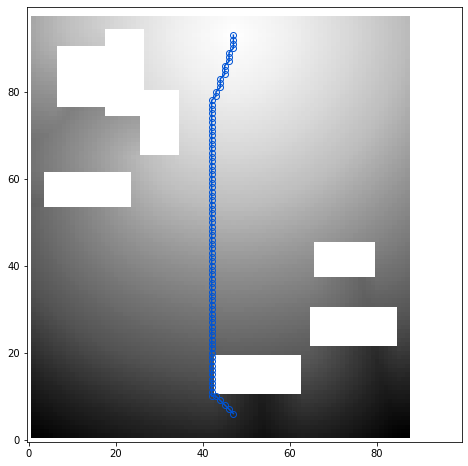

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.30962204933166504 vy:  0.1906148493289948 v:  0.36359295127526253
vx:  -0.4109271466732025 vy:  0.7193974256515503 v:  0.8284888508043168
vx:  -0.4109269678592681 vy:  0.7193976640701296 v:  0.8284889691381359
vx:  -0.4109271466732024 vy:  0.7193976640701294 v:  0.8284890578290931
vx:  -0.41092708706855763 vy:  0.7193976044654846 v:  0.8284889765092398
vx:  -0.4109269976615906 vy:  0.7193976640701295 v:  0.82848898391996
vx:  -0.4109269082546233 vy:  0.7193976640701294 v:  0.8284889395744897


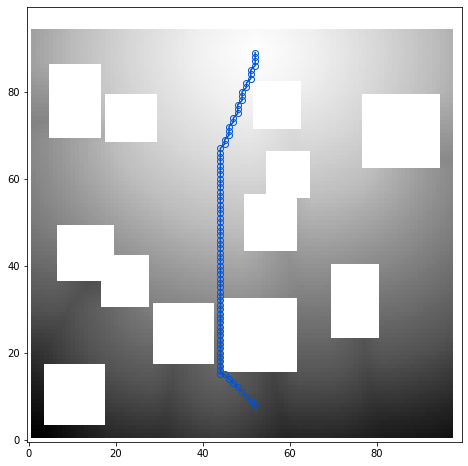

vx:  0.0 vy:  -0.0 v:  0.0
idx:  0
vx:  -0.32743060588836664 vy:  0.27683231234550487 v:  0.428773752497727
vx:  -0.22785133123397824 vy:  0.36619895696640026 v:  0.431297930934494
vx:  -0.2576390206813812 vy:  0.4140732288360596 v:  0.4876827901580914
vx:  -0.25372067093849177 vy:  0.4077757000923157 v:  0.4802657602278728
vx:  -0.24357184767723078 vy:  0.39146462082862854 v:  0.46105508818513435
vx:  -0.2338289916515351 vy:  0.37580606341362 v:  0.442612917384045
vx:  -0.22447583079338068 vy:  0.3607739508152008 v:  0.4249085103845149
vx:  -0.21549680829048154 vy:  0.34634292125701904 v:  0.40791211490740287
vx:  -0.20687690377235418 vy:  0.3324890732765197 v:  0.3915955019694618
vx:  -0.19860184192657465 vy:  0.31918954849243164 v:  0.37593172183713164
vx:  -0.1906577646732331 vy:  0.30642208456993103 v:  0.3608945512783144
vx:  -0.1830314695835114 vy:  0.2941651940345764 v:  0.34645877134126635
vx:  -0.17571020126342776 vy:  0.2823985517024994 v:  0.3326003860967445
vx:  -0.1686817

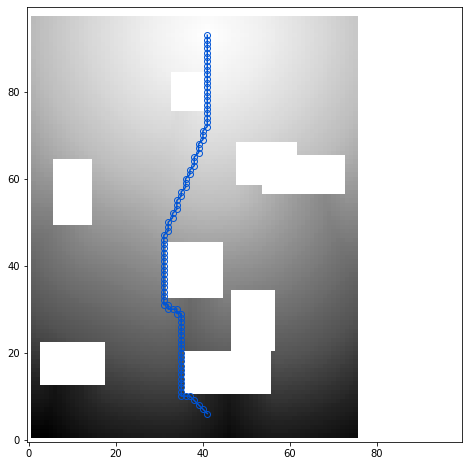

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.3162277638912201 vy:  0.2271269559860229 v:  0.3893413062996502
vx:  -0.47783628106117226 vy:  0.855104386806488 v:  0.9795565444802415
vx:  -0.4764622449874877 vy:  0.852645754814148 v:  0.9767400135660999
vx:  -0.4651493728160856 vy:  0.8324009180068972 v:  0.9535487545636683
vx:  -0.4626803398132323 vy:  0.8279824852943423 v:  0.9484872654937881
vx:  -0.4598145186901094 vy:  0.8228532671928404 v:  0.9426117392267873
vx:  -0.4564697444438933 vy:  0.816867470741272 v:  0.9357548249129769
vx:  -0.4525433182716372 vy:  0.8098423480987549 v:  0.9277068953534889
vx:  -0.4138501286506653 vy:  0.74063777923584 v:  0.8484198542087337
vx:  -0.1741726249456405 vy:  0.9221305847167969 v:  0.9384353566179167
vx:  -0.17346897721290588 vy:  0.9730755090713501 v:  0.9884166289625842
vx:  -0.17320339381694783 vy:  0.9715858697891235 v:  0.9869034998436252
vx:  -0.32797971367836004 vy:  0.9446847438812256 v:  0.9999999789532377
vx:  -0.2460578083992005 vy:  0

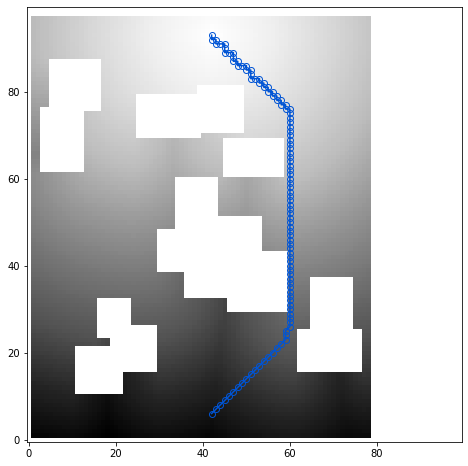

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.1941238939762116 vy:  0.7764955759048462 v:  0.8003933193201241
vx:  0.36369514465332026 vy:  0.712990403175354 v:  0.800393324100441
vx:  0.49235165119171115 vy:  0.6310461163520813 v:  0.8003932467195416
vx:  0.49235165119171115 vy:  0.6310461163520813 v:  0.8003932467195416
vx:  0.49235165119171115 vy:  0.6310461163520813 v:  0.8003932467195416
vx:  0.49235165119171115 vy:  0.6310461163520813 v:  0.8003932467195416
vx:  0.49235165119171115 vy:  0.6310461163520813 v:  0.8003932467195416
vx:  0.49235165119171115 vy:  0.6310461163520813 v:  0.8003932467195416
vx:  0.4028308987617492 vy:  0.6916332840919496 v:  0.800393236266408
vx:  0.4028308987617492 vy:  0.6916332840919496 v:  0.800393236266408
vx:  0.4028308987617492 vy:  0.6916332840919496 v:  0.800393236266408
vx:  0.4028308987617492 vy:  0.6916332840919496 v:  0.800393236266408
vx:  0.4220355451107025 vy:  0.680084764957428 v:  0.8003932089067772
vx:  0.44720652699470514 vy:  0.66380393505

vx:  -0.49475663900375355 vy:  0.6291623115539551 v:  0.8003932446730211
vx:  -0.49475663900375366 vy:  0.6291622519493104 v:  0.800393197819808
vx:  -0.49475651979446417 vy:  0.6291623711585999 v:  0.8003932178379836
vx:  -0.49475651979446417 vy:  0.6291623711585999 v:  0.8003932178379836
vx:  -0.49475651979446417 vy:  0.6291623115539551 v:  0.8003931709847643
vx:  -0.4947565793991089 vy:  0.6291623115539552 v:  0.8003932078288915
vx:  -0.4947566986083984 vy:  0.6291621923446654 v:  0.800393187810733
vx:  -0.4947563409805297 vy:  0.6291624307632446 v:  0.8003931541588526
vx:  -0.49475640058517456 vy:  0.6291624307632446 v:  0.8003931910029671
vx:  -0.49475663900375355 vy:  0.6291623711585999 v:  0.8003932915262361


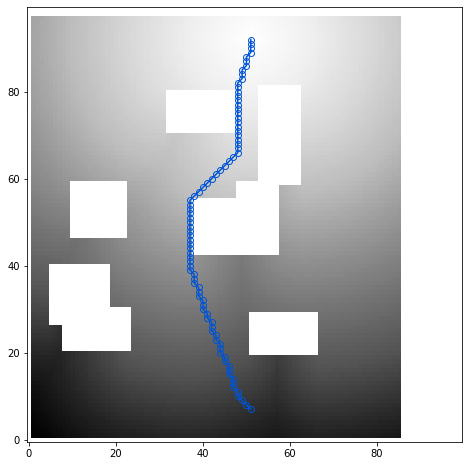

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.07304453849792483 vy:  0.42594540119171137 v:  0.4321631513684881
vx:  -0.2697007358074187 vy:  0.6849590539932251 v:  0.7361435950562614
vx:  -0.3593906164169312 vy:  0.8528291583061218 v:  0.9254616082937585
vx:  -0.32895249128341664 vy:  0.9050469994544982 v:  0.9629744611063975
vx:  -0.26574650406837463 vy:  0.9255801439285278 v:  0.9629744582590531
vx:  -0.24028410017490376 vy:  0.9325146079063416 v:  0.9629745286120402
vx:  -0.23750945925712585 vy:  0.9332250952720641 v:  0.9629744657477505
vx:  -0.23858509957790366 vy:  0.9112392663955687 v:  0.9419553335279399
vx:  -0.23748177289962763 vy:  0.8747896552085876 v:  0.9064516166456487
vx:  -0.18047168850898737 vy:  0.839798092842102 v:  0.8589708185349004
vx:  -0.16347508132457728 vy:  0.8062061667442321 v:  0.8226132052857562
vx:  -0.16152168810367587 vy:  0.7739579677581788 v:  0.7906327792244838
vx:  -0.15911459922790533 vy:  0.7429995536804199 v:  0.7598459004671672
vx:  -0.36673954129

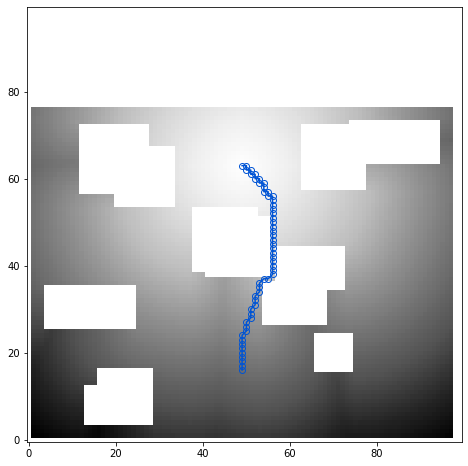

vx:  -0.0 vy:  0.0 v:  0.0
idx:  0
vx:  -0.1754239946603775 vy:  0.39606285095214855 v:  0.43317359084661194
vx:  -0.17025557160377508 vy:  0.7685179710388184 v:  0.7871510855431442
vx:  0.0015756599605083466 vy:  0.7377772331237792 v:  0.7377789156787353
vx:  0.024091482162475614 vy:  0.7082660794258118 v:  0.7086756936554232
vx:  0.02357439696788785 vy:  0.6799354553222655 v:  0.6803440126852709
vx:  0.016566962003707913 vy:  0.6527380347251892 v:  0.6529482415987768
vx:  0.016233444213867243 vy:  0.6266284584999086 v:  0.6268386951305865
vx:  0.015868797898292486 vy:  0.6015633344650269 v:  0.6017726016689515
vx:  0.015474081039428711 vy:  0.5775008201599121 v:  0.5777080962470458
vx:  0.08904286473989492 vy:  0.5544008016586304 v:  0.5615059043686177
vx:  0.12371251732110977 vy:  0.5322247147560121 v:  0.5464137021882268
vx:  0.13828304409980768 vy:  0.5109357833862306 v:  0.5293180282495681
vx:  0.14254021644592285 vy:  0.4904983341693878 v:  0.5107899070336012
vx:  0.141573995351

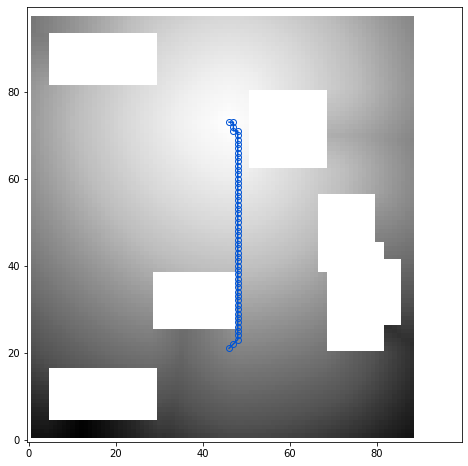

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.11547229439020157 vy:  0.2092055082321167 v:  0.23895772732095447
idx:  0
vx:  0.06402388215065002 vy:  0.3136410713195801 v:  0.320109011282304
vx:  0.07107595354318627 vy:  0.44480016827583313 v:  0.45044309393116755
vx:  0.08154869079589841 vy:  0.5103395581245422 v:  0.51681394481697
vx:  0.0871633589267731 vy:  0.5454766154289246 v:  0.5523967678391976
vx:  0.09006763994693762 vy:  0.5636518597602845 v:  0.5708025917748084
vx:  0.09136351943016055 vy:  0.5717617273330688 v:  0.5790153413559609
vx:  0.09176734089851388 vy:  0.5742887258529663 v:  0.5815744023746295
vx:  0.0917673408985138 vy:  0.5742889046669006 v:  0.581574578948472
vx:  0.09176731854677203 vy:  0.5742887854576111 v:  0.5815744577056688
vx:  0.09176730364561075 vy:  0.5742889046669006 v:  0.5815745730702936
vx:  0.09176734834909436 vy:  0.5742887854576111 v:  0.5815744624082131
vx:  0.09176731854677206 vy:  0.5742889046669006 v:  0.5815745754215647
vx:  0.042135842144489344

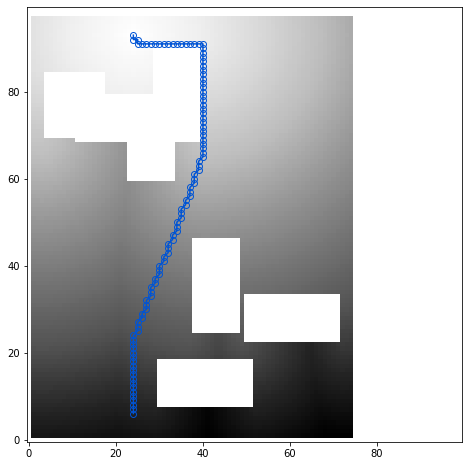

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.1465184092521667 vy:  0.3477210104465485 v:  0.37732949176516023
vx:  0.031301766633987316 vy:  0.8472002744674683 v:  0.8477783352104264
vx:  -0.009703271090984289 vy:  0.9999529123306276 v:  0.9999999901741844
vx:  -0.009703271090984289 vy:  0.9999529123306276 v:  0.9999999901741844
vx:  -0.009703271090984289 vy:  0.9999529123306276 v:  0.9999999901741844
vx:  -0.009703272022307197 vy:  0.9999529123306274 v:  0.9999999901832212
vx:  -0.009703271090984289 vy:  0.9999529123306276 v:  0.9999999901741844
vx:  -0.009703272022307197 vy:  0.9999529123306274 v:  0.9999999901832212
vx:  -0.00690309982746834 vy:  0.9999761581420898 v:  0.9999999848199208
vx:  -0.00690309982746834 vy:  0.9999761581420898 v:  0.9999999848199208
vx:  -0.00690309982746834 vy:  0.9999761581420898 v:  0.9999999848199208
vx:  -0.00690309982746834 vy:  0.9999761581420898 v:  0.9999999848199208
vx:  -0.005019668489694706 vy:  0.9999874234199524 v:  1.0000000220349106
vx:  -0.005

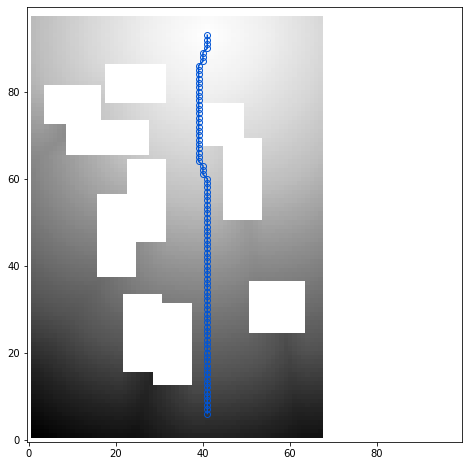

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.2538819015026093 vy:  0.5614768266677856 v:  0.6162079574263117
vx:  0.009782489389181526 vy:  0.9555943608283997 v:  0.9556444315464236
vx:  -0.014263841323554405 vy:  0.9998982548713684 v:  0.9999999886320557
vx:  -0.014263841323554405 vy:  0.9998982548713684 v:  0.9999999886320557
vx:  -0.014263841323554405 vy:  0.9998982548713684 v:  0.9999999886320557
vx:  -0.014263841323554405 vy:  0.9998982548713684 v:  0.9999999886320557
vx:  -0.010603800415993014 vy:  0.9999437928199767 v:  1.0000000146912313
vx:  -0.010603800415993014 vy:  0.9999437928199767 v:  1.0000000146912313
vx:  -0.010603800415993014 vy:  0.9999437928199767 v:  1.0000000146912313
vx:  -0.010603800415993014 vy:  0.9999437928199767 v:  1.0000000146912313
vx:  -0.010603800415993014 vy:  0.9999437928199767 v:  1.0000000146912313
vx:  -0.00788278970867412 vy:  0.9999689459800719 v:  1.0000000156490434
vx:  -0.00788278970867412 vy:  0.9999689459800719 v:  1.0000000156490434
vx:  -0.00

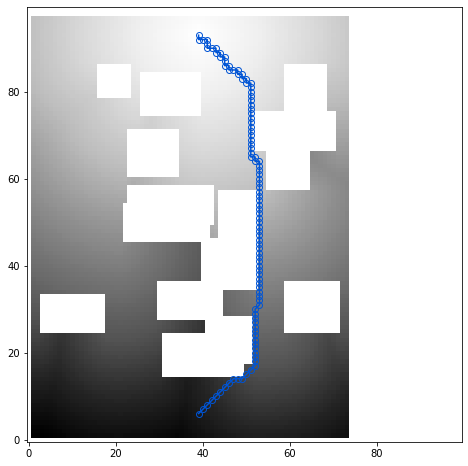

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  0.3162277936935425 vy:  0.40333032608032227 v:  0.5125186527730915
vx:  0.5528277754783629 vy:  0.38719722628593445 v:  0.6749372129197474
vx:  0.6865086555480958 vy:  0.6977152228355407 v:  0.9788261675695549
vx:  0.6589978933334352 vy:  0.6697555780410767 v:  0.9396013823611811
vx:  0.6549422740936278 vy:  0.6656336784362793 v:  0.9338188134020136
vx:  0.6503294706344603 vy:  0.6609454154968262 v:  0.9272417498376405
vx:  0.6450648903846741 vy:  0.6555949449539183 v:  0.919735529734566
vx:  0.6390359401702881 vy:  0.6494677066802979 v:  0.9111395254569354
vx:  0.6218540072441102 vy:  0.6320053935050964 v:  0.8866415418561718
vx:  0.5966039299964905 vy:  0.6063429713249207 v:  0.8506397875495778
vx:  0.5728331208229065 vy:  0.5821840167045593 v:  0.8167472152495932
vx:  0.549970805644989 vy:  0.5589486360549927 v:  0.7841501545045662
vx:  0.528018593788147 vy:  0.5366381406784058 v:  0.7528506687363627
vx:  0.5069389343261719 vy:  0.5152141451835

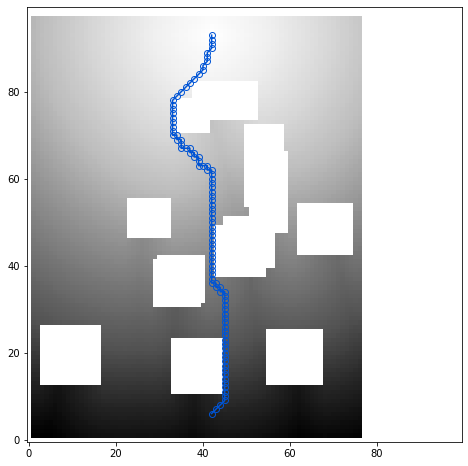

vx:  0.0 vy:  0.0 v:  0.0
idx:  0
vx:  2.7755575615628914e-17 vy:  0.2417616248130798 v:  0.2417616248130798
idx:  0
vx:  -0.24532569944858554 vy:  0.2320911884307862 v:  0.33771440383429374
vx:  0.012562960386276252 vy:  0.2228075563907623 v:  0.22316145536021642
idx:  0
vx:  0.2507473826408386 vy:  0.21389526128768918 v:  0.32958372639218697
vx:  0.41800296306610113 vy:  0.7174273729324341 v:  0.8303183200223719
vx:  0.42884388566017145 vy:  0.7360334396362305 v:  0.8518522774113213
vx:  0.4220435619354248 vy:  0.7243622541427612 v:  0.8383444658360446
vx:  0.41449546813964855 vy:  0.7114070653915405 v:  0.8233507793142059
vx:  0.40612906217575073 vy:  0.697047472000122 v:  0.8067316737091185
vx:  0.3968762457370757 vy:  0.6811673045158387 v:  0.7883524917013512
vx:  0.38667652010917664 vy:  0.6636607646942138 v:  0.7680913629238718
vx:  0.37548038363456726 vy:  0.6444451808929443 v:  0.7458519354875347
vx:  0.3843270540237427 vy:  0.6596285104751587 v:  0.7634245583463014
vx:  0.375

In [7]:
from navrep.envs.e2eenv import E2E1DNavRepEnv
env = E2E1DNavRepEnv(silent=True, scenario='test', adaptive=False, collect_statistics=False)
#env.soadrl_sim.human_num = 7
#env.soadrl_sim.num_walls = 7
#env.soadrl_sim.num_circles = 7

data_reg = play_policy(env,15)

In [6]:
env.soadrl_sim.obstacle_vertices

[[(-1.9222712039705174, -5.322271203970518),
  (-4.077728796029483, -5.322271203970518),
  (-4.077728796029483, -7.477728796029483),
  (-1.9222712039705174, -7.477728796029483)],
 [(0.22671789043425028, 1.6267178904342505),
  (-0.8267178904342504, 1.6267178904342505),
  (-0.8267178904342504, 0.5732821095657498),
  (0.22671789043425028, 0.5732821095657498)],
 [(-1.2027019397565895, 2.697298060243411),
  (-3.197298060243411, 2.697298060243411),
  (-3.197298060243411, 0.7027019397565895),
  (-1.2027019397565895, 0.7027019397565895)],
 [(-1.013347616947582, -2.9133476169475823),
  (-1.986652383052418, -2.9133476169475823),
  (-1.986652383052418, -3.8866523830524184),
  (-1.013347616947582, -3.8866523830524184)],
 [(6.092999461024714, 1.0929994610247142),
  (4.7070005389752865, 1.0929994610247142),
  (4.7070005389752865, -0.2929994610247141),
  (6.092999461024714, -0.2929994610247141)],
 [(-1.280539896681852, 7.919460103318148),
  (-3.719460103318148, 7.919460103318148),
  (-3.7194601033181

[[22 10]]


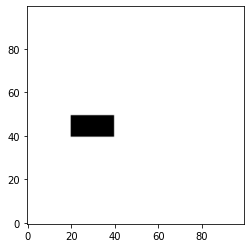

In [4]:
from map2d import gridshow

cmap2d = CMap2D.CMap2D()
cmap2d.set_resolution(0.1)
cmap2d.origin[0] = 0
cmap2d.origin[1] = 0
cmap2d._occupancy[20:40, 40:50] = 1.
coarse = cmap2d.as_coarse_map2d().as_coarse_map2d().as_coarse_map2d()

print(cmap2d.xy_to_ij([[2.26, 1.]]))

# occupancy
plt.figure("occupancy") 
grid = cmap2d.occupancy()
gridshow(grid)
plt.show()

In [5]:
env.reset()
i = 0
for vertex in env.soadrl_sim.obstacle_vertices:
    print(vertex)
    i+=1    
print(i)
env.render()

[(-1.9222712039705174, -5.322271203970518), (-4.077728796029483, -5.322271203970518), (-4.077728796029483, -7.477728796029483), (-1.9222712039705174, -7.477728796029483)]
[(0.22671789043425028, 1.6267178904342505), (-0.8267178904342504, 1.6267178904342505), (-0.8267178904342504, 0.5732821095657498), (0.22671789043425028, 0.5732821095657498)]
[(-1.2027019397565895, 2.697298060243411), (-3.197298060243411, 2.697298060243411), (-3.197298060243411, 0.7027019397565895), (-1.2027019397565895, 0.7027019397565895)]
[(-1.013347616947582, -2.9133476169475823), (-1.986652383052418, -2.9133476169475823), (-1.986652383052418, -3.8866523830524184), (-1.013347616947582, -3.8866523830524184)]
[(6.092999461024714, 1.0929994610247142), (4.7070005389752865, 1.0929994610247142), (4.7070005389752865, -0.2929994610247141), (6.092999461024714, -0.2929994610247141)]
[(-1.280539896681852, 7.919460103318148), (-3.719460103318148, 7.919460103318148), (-3.719460103318148, 5.480539896681853), (-1.280539896681852, 

ArgumentError: argument 2: <class 'TypeError'>: wrong type

In [ ]:
i

In [ ]:
import numpy as np
np.array((1,2))

In [ ]:
amap = CMap2D.CMap2D()
print(dir(env.soadrl_sim.robot))

In [ ]:
data = data_reg
print(data['rewards'][data['rewards']>2].size)
print(data['dones'][data['dones']==True].size)

In [ ]:
#177

#182

# 283 augmented

# 232 not augmented